In [15]:
import numpy as np
import pandas as pd
import os
import glob
import mne
import matplotlib.pyplot as plt

from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder

In [16]:
# https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD,RMSprop,Adam
from keras.utils import np_utils
from keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

In [6]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Independent Component Activations based classification

In [3]:
os.chdir("/DATAHDD/shivam/Thesis/Data/CSV/")
dataset = pd.read_csv("ICs_v1.csv")
dataset

0      1      2      3      4      5      6      7      8      9  \
0        5.87   6.08   6.17   6.14   5.99   5.73   5.38   4.95   4.46   3.94   
1       17.12  16.97  16.71  16.33  15.86  15.32  14.73  14.11  13.49  12.88   
2       10.37  10.29  10.13   9.89   9.58   9.21   8.79   8.33   7.84   7.34   
3        8.23   7.93   7.57   7.19   6.79   6.38   5.98   5.60   5.25   4.94   
4       22.84  22.55  22.19  21.77  21.30  20.81  20.32  19.84  19.39  18.98   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
460795  -0.95  -0.22   0.62   1.55   2.54   3.57   4.61   5.61   6.55   7.40   
460796  -7.21  -8.17  -8.79  -9.09  -9.07  -8.77  -8.21  -7.43  -6.46  -5.36   
460797 -12.40 -13.26 -13.75 -13.89 -13.70 -13.22 -12.49 -11.56 -10.48  -9.30   
460798  -1.75  -3.02  -4.12  -5.05  -5.79  -6.34  -6.70  -6.87  -6.86  -6.67   
460799  -4.30  -5.66  -6.96  -8.18  -9.30 -10.29 -11.12 -11.77 -12.22 -12.45   

        ...   1097   1098   1099   1100   HandPos   Hand  Action  Subject  \
0       ... -20.91 -21.49 -21.94 -22.24  palmDown  Right    Open      P01   
1       ... -32.44 -32.50 -32.51 -32.47  palmDown  Right    Open      P01   
2       ...  -4.45  -4.96  -5.54  -6.14  palmDown  Right    Open      P01   
3       ...  -2.11  -2.23  -2.34  -2.45  palmDown  Right    Open      P01   
4       ...  -8.34  -9.17  -9.99 -10.76  palmDown  Right    Open      P01   
...     ...    ...    ...    ...    ...       ...    ...     ...      ...   
460795  ...  -7.07  -6.69  -6.18  -5.55    palmUp  Right   Close     FP12   
460796  ...  -1.13  -1.44  -1.94  -2.63    palmUp  Right   Close     FP12   
460797  ...   0.38  -0.15  -0.97  -2.05    palmUp  Right   Close     FP12   
460798  ...   0.97   0.51  -0.24  -1.27    palmUp  Right   Close     FP12   
460799  ...  -0.16  -0.96  -2.01  -3.29    palmUp  Right   Close     FP12   

        Component  Trial  
0               1      1  
1               2      1  
2               3      1  
3               4      1  
4               5      1  
...           ...    ...  
460795         60    480  
460796         61    480  
460797         62    480  
460798         63    480  
460799         64    480  

[460800 rows x 1107 columns]

In [4]:
subjects = np.unique(dataset.Subject)
exclusion = ["FP01", "FP10"]
subjects

array(['FP01', 'FP02', 'FP03', 'FP05', 'FP06', 'FP07', 'FP08', 'FP09',
       'FP10', 'FP11', 'FP12', 'FP13', 'P01', 'P02', 'P03'], dtype=object)

# LSTM Based approaches

In [62]:
grasp_dict = {"Open": 0, "Close": 1}
pos_dict = {"palmDown": 0, "palmIn": 1, "palmUp": 2}
hand_dict = {"Left": 0, "Right": 1}

X, y_lr, y_pos, y_act = [], [], [], []
trials = np.unique(dataset[dataset["Subject"] == "FP02"]["Trial"])
for trial in trials:
    pc_eeg = dataset[
        (dataset["Subject"] == "FP02") & 
        (dataset["Component"] == 32) & 
        (dataset["Trial"] == trial)
    ]
    X.append(np.expand_dims(pc_eeg.iloc[0, :500].to_numpy(), axis=0))
    y_act.append(grasp_dict[pc_eeg.iloc[:, -4].to_numpy()[0]])
    y_lr.append(hand_dict[pc_eeg.iloc[:, -5].to_numpy()[0]])
    y_pos.append(pos_dict[pc_eeg.iloc[:, -6].to_numpy()[0]])

label_dict = {"Action": y_act, "Hand": y_lr, "Position": y_pos}
X, y_act, y_lr, y_pos = np.array(X, dtype=np.float64), np.array(y_act), np.array(y_lr), np.array(y_pos)
X.shape

(480, 1, 500)

In [63]:
y = y_act
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y.reshape(-1, 1))
y_oh = enc.transform(y.reshape(-1, 1)).toarray()
y_oh.shape, y.shape

((480, 2), (480,))

In [64]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y_oh, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train.shape, X_eval.shape, X_test.shape, y_train.shape, y_eval.shape, y_test.shape

((307, 1, 500), (96, 1, 500), (77, 1, 500), (307, 2), (96, 2), (77, 2))

In [ ]:
def create_checkpoint():
    checkpoint_filepath = '/tmp/checkpoint/'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    return checkpoint_filepath, model_checkpoint_callback

checkpoint_filepath, model_checkpoint_callback = create_checkpoint()
checkpoint_filepath

In [79]:
n_features = 1
n_class = 2
segment_length = 500
EPOCHS = 50
batch_size = 128
LR = 0.001
n_hidden = 4

In [80]:
model = Sequential()
model.add(LSTM(
    n_hidden, 
    input_shape=(n_features, segment_length),
#     kernel_initializer="glorot_uniform", 
#     recurrent_initializer="orthogonal",
#     dropout=0.5,
#     recurrent_dropout=0.5
))
model.add(Dense(2, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=LR), metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, validation_data=(X_eval, y_eval))

Epoch 1/50
3/3 [==============================] - 2s 166ms/step - loss: 0.7044 - accuracy: 0.4756 - val_loss: 0.7190 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 0s 17ms/step - loss: 0.6784 - accuracy: 0.5733 - val_loss: 0.7212 - val_accuracy: 0.4792
Epoch 3/50
3/3 [==============================] - 0s 16ms/step - loss: 0.6661 - accuracy: 0.5896 - val_loss: 0.7205 - val_accuracy: 0.4688
Epoch 4/50
3/3 [==============================] - 0s 20ms/step - loss: 0.6602 - accuracy: 0.5993 - val_loss: 0.7209 - val_accuracy: 0.4583
Epoch 5/50
3/3 [==============================] - 0s 17ms/step - loss: 0.6544 - accuracy: 0.6287 - val_loss: 0.7177 - val_accuracy: 0.4583
Epoch 6/50
3/3 [==============================] - 0s 23ms/step - loss: 0.6494 - accuracy: 0.6450 - val_loss: 0.7160 - val_accuracy: 0.4896
Epoch 7/50
3/3 [==============================] - 0s 17ms/step - loss: 0.6444 - accuracy: 0.6710 - val_loss: 0.7152 - val_accuracy: 0.4896
Epoch 8/50
3/3 [==========

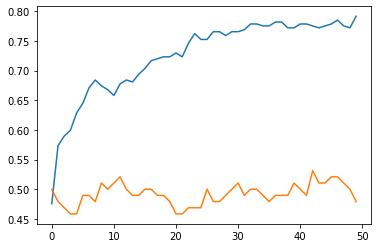

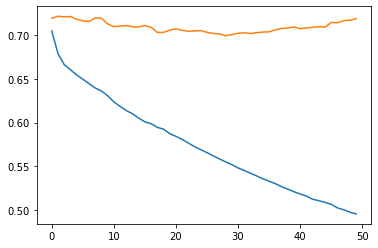

In [81]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [ ]:
print("Max train acc: ", max(history.history["accuracy"]))
print("Max validation acc: ", max(history.history["val_accuracy"]))

In [ ]:
model.load_weights(checkpoint_filepath)
model.save('/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Models/Final/in-up-down')

In [ ]:
new_model = tf.keras.models.load_model('/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Models/Final/in-up-down')

y_pred = np.argmax(new_model.predict(X_test), axis=1)
# y_pred = [1 if x > 0.5 else 0 for x in model.predict(X_test)]  # Binary classification (sigmoid)
y_true = y_test
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy main: {test_acc:.0%}')

In [ ]:
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize = (7,7))
hm1 = sns.heatmap(confusion_matrix, annot=True, cbar=False, vmin=0, vmax=1500,fmt='g')

hm1.set(title='True Position', ylabel='Predicted Position')
hm1.xaxis.tick_top()

hm1.set_xticklabels([int(i.get_text())+1 for i in hm1.get_xticklabels()])
hm1.set_yticklabels([int(i.get_text())+1 for i in hm1.get_yticklabels()])
plt.tight_layout()
# file_name = "beat_classification_confusion_matrix_reverse_sizes"
# os.chdir('/mnt/sda1/shivam/DrummingEEG/FullStudyData/images')
# hm1.get_figure().savefig(file_name + ".png")

In [7]:
clfs = [
    KNeighborsClassifier(5, n_jobs=-1),
    DecisionTreeClassifier(max_depth=5000),
    RandomForestClassifier(max_depth=5000, n_estimators=250, max_features=1, n_jobs=-1),
#     MLPClassifier(alpha=1, max_iter=2000),
    AdaBoostClassifier(),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis()
]

names = [
    "KNN",
    "Decision Tree",
    "Random Forest",
#     "Neural Net",
    "AdaBoost",
#     "Naive Bayes",
#     "QDA",
]

In [13]:
grasp_dict = {"Open": 0, "Close": 1}
pos_dict = {"palmDown": 0, "palmIn": 1, "palmUp": 2}
hand_dict = {"Left": 0, "Right": 1}

fold_acc = np.array(())

# Prediction of open vs close using different hand positions
for comp in range(1, 65):
    for sub in subjects:
        if sub not in exclusion:
            print("##### Component: ", comp, " Subject: ", sub, " #####")
            trials = np.unique(dataset[dataset["Subject"] == sub]["Trial"])

            # Extracting X and ys
            X, y_lr, y_pos, y_act = [], [], [], []
            for trial in trials:
                pc_eeg = dataset[
                    (dataset["Subject"] == sub) & 
                    (dataset["Component"] == comp) & 
                    (dataset["Trial"] == trial)
                ]
                X.append(pc_eeg.iloc[0, :-7].to_numpy())
                y_act.append(grasp_dict[pc_eeg.iloc[:, -4].to_numpy()[0]])
                y_lr.append(hand_dict[pc_eeg.iloc[:, -5].to_numpy()[0]])
                y_pos.append(pos_dict[pc_eeg.iloc[:, -6].to_numpy()[0]])

            X, y_act, y_lr, y_pos = np.array(X, dtype=np.float64), np.array(y_act), np.array(y_lr), np.array(y_pos)
            
            n_splits = 5
            for pos in pos_dict.keys():
                X_pos = X[y_pos==pos_dict[pos]]
                y_ac_pos = y_act[y_pos==pos_dict[pos]]
                kf = KFold(n_splits)
                for i, (train_idx, test_idx) in enumerate(kf.split(X_pos)):
                    X_train, X_test, y_train, y_test = X_pos[train_idx, :], X_pos[test_idx, :], np.array(y_ac_pos)[train_idx], np.array(y_ac_pos)[test_idx]

                    results = []
                    for idx,clf in enumerate(clfs):
                        clf.fit(X_train, y_train)
                        score = clf.score(X_test, y_test)
                        results.append([names[idx], score])
                    
                    results = np.array(results)                    
                    temp = pd.DataFrame(columns=["Accuracy", "Classifier", "Position", "Fold", "Subject", "Component"])
                    temp["Accuracy"] = results[:, 1]
                    temp["Classifier"] = results[:, 0]
                    temp["Position"] = pos
                    temp["Fold"] = i
                    temp["Subject"] = sub
                    temp["Component"] = comp
                    temp.reset_index()

                    if len(fold_acc) == 0:
                        fold_acc = temp.to_numpy()
                    else:
                        fold_acc = np.vstack((fold_acc, temp.to_numpy()))
                    print(fold_acc.shape)
            

##### Component:  1  Subject:  FP02  #####
(4, 6)
(8, 6)
(12, 6)
(16, 6)
(20, 6)
(24, 6)
(28, 6)
(32, 6)
(36, 6)
(40, 6)
(44, 6)
(48, 6)
(52, 6)
(56, 6)
(60, 6)
##### Component:  1  Subject:  FP03  #####
(64, 6)
(68, 6)
(72, 6)
(76, 6)
(80, 6)
(84, 6)
(88, 6)
(92, 6)
(96, 6)
(100, 6)
(104, 6)
(108, 6)
(112, 6)
(116, 6)
(120, 6)
##### Component:  1  Subject:  FP05  #####
(124, 6)
(128, 6)
(132, 6)
(136, 6)
(140, 6)
(144, 6)
(148, 6)
(152, 6)
(156, 6)
(160, 6)
(164, 6)
(168, 6)
(172, 6)
(176, 6)
(180, 6)
##### Component:  1  Subject:  FP06  #####
(184, 6)
(188, 6)
(192, 6)
(196, 6)
(200, 6)
(204, 6)
(208, 6)
(212, 6)
(216, 6)
(220, 6)
(224, 6)
(228, 6)
(232, 6)
(236, 6)
(240, 6)
##### Component:  1  Subject:  FP07  #####
(244, 6)
(248, 6)
(252, 6)
(256, 6)
(260, 6)
(264, 6)
(268, 6)
(272, 6)
(276, 6)
(280, 6)
(284, 6)
(288, 6)
(292, 6)
(296, 6)
(300, 6)
##### Component:  1  Subject:  FP08  #####
(304, 6)
(308, 6)
(312, 6)
(316, 6)
(320, 6)
(324, 6)
(328, 6)
(332, 6)
(336, 6)
(340, 6)
(34

(2640, 6)
##### Component:  4  Subject:  FP08  #####
(2644, 6)
(2648, 6)
(2652, 6)
(2656, 6)
(2660, 6)
(2664, 6)
(2668, 6)
(2672, 6)
(2676, 6)
(2680, 6)
(2684, 6)
(2688, 6)
(2692, 6)
(2696, 6)
(2700, 6)
##### Component:  4  Subject:  FP09  #####
(2704, 6)
(2708, 6)
(2712, 6)
(2716, 6)
(2720, 6)
(2724, 6)
(2728, 6)
(2732, 6)
(2736, 6)
(2740, 6)
(2744, 6)
(2748, 6)
(2752, 6)
(2756, 6)
(2760, 6)
##### Component:  4  Subject:  FP11  #####
(2764, 6)
(2768, 6)
(2772, 6)
(2776, 6)
(2780, 6)
(2784, 6)
(2788, 6)
(2792, 6)
(2796, 6)
(2800, 6)
(2804, 6)
(2808, 6)
(2812, 6)
(2816, 6)
(2820, 6)
##### Component:  4  Subject:  FP12  #####
(2824, 6)
(2828, 6)
(2832, 6)
(2836, 6)
(2840, 6)
(2844, 6)
(2848, 6)
(2852, 6)
(2856, 6)
(2860, 6)
(2864, 6)
(2868, 6)
(2872, 6)
(2876, 6)
(2880, 6)
##### Component:  4  Subject:  FP13  #####
(2884, 6)
(2888, 6)
(2892, 6)
(2896, 6)
(2900, 6)
(2904, 6)
(2908, 6)
(2912, 6)
(2916, 6)
(2920, 6)
(2924, 6)
(2928, 6)
(2932, 6)
(2936, 6)
(2940, 6)
##### Component:  4  Subj

(5184, 6)
(5188, 6)
(5192, 6)
(5196, 6)
(5200, 6)
(5204, 6)
(5208, 6)
(5212, 6)
(5216, 6)
(5220, 6)
##### Component:  7  Subject:  FP13  #####
(5224, 6)
(5228, 6)
(5232, 6)
(5236, 6)
(5240, 6)
(5244, 6)
(5248, 6)
(5252, 6)
(5256, 6)
(5260, 6)
(5264, 6)
(5268, 6)
(5272, 6)
(5276, 6)
(5280, 6)
##### Component:  7  Subject:  P01  #####
(5284, 6)
(5288, 6)
(5292, 6)
(5296, 6)
(5300, 6)
(5304, 6)
(5308, 6)
(5312, 6)
(5316, 6)
(5320, 6)
(5324, 6)
(5328, 6)
(5332, 6)
(5336, 6)
(5340, 6)
##### Component:  7  Subject:  P02  #####
(5344, 6)
(5348, 6)
(5352, 6)
(5356, 6)
(5360, 6)
(5364, 6)
(5368, 6)
(5372, 6)
(5376, 6)
(5380, 6)
(5384, 6)
(5388, 6)
(5392, 6)
(5396, 6)
(5400, 6)
##### Component:  7  Subject:  P03  #####
(5404, 6)
(5408, 6)
(5412, 6)
(5416, 6)
(5420, 6)
(5424, 6)
(5428, 6)
(5432, 6)
(5436, 6)
(5440, 6)
(5444, 6)
(5448, 6)
(5452, 6)
(5456, 6)
(5460, 6)
##### Component:  8  Subject:  FP02  #####
(5464, 6)
(5468, 6)
(5472, 6)
(5476, 6)
(5480, 6)
(5484, 6)
(5488, 6)
(5492, 6)
(5496, 6

(7740, 6)
##### Component:  10  Subject:  P03  #####
(7744, 6)
(7748, 6)
(7752, 6)
(7756, 6)
(7760, 6)
(7764, 6)
(7768, 6)
(7772, 6)
(7776, 6)
(7780, 6)
(7784, 6)
(7788, 6)
(7792, 6)
(7796, 6)
(7800, 6)
##### Component:  11  Subject:  FP02  #####
(7804, 6)
(7808, 6)
(7812, 6)
(7816, 6)
(7820, 6)
(7824, 6)
(7828, 6)
(7832, 6)
(7836, 6)
(7840, 6)
(7844, 6)
(7848, 6)
(7852, 6)
(7856, 6)
(7860, 6)
##### Component:  11  Subject:  FP03  #####
(7864, 6)
(7868, 6)
(7872, 6)
(7876, 6)
(7880, 6)
(7884, 6)
(7888, 6)
(7892, 6)
(7896, 6)
(7900, 6)
(7904, 6)
(7908, 6)
(7912, 6)
(7916, 6)
(7920, 6)
##### Component:  11  Subject:  FP05  #####
(7924, 6)
(7928, 6)
(7932, 6)
(7936, 6)
(7940, 6)
(7944, 6)
(7948, 6)
(7952, 6)
(7956, 6)
(7960, 6)
(7964, 6)
(7968, 6)
(7972, 6)
(7976, 6)
(7980, 6)
##### Component:  11  Subject:  FP06  #####
(7984, 6)
(7988, 6)
(7992, 6)
(7996, 6)
(8000, 6)
(8004, 6)
(8008, 6)
(8012, 6)
(8016, 6)
(8020, 6)
(8024, 6)
(8028, 6)
(8032, 6)
(8036, 6)
(8040, 6)
##### Component:  11 

(10260, 6)
##### Component:  14  Subject:  FP05  #####
(10264, 6)
(10268, 6)
(10272, 6)
(10276, 6)
(10280, 6)
(10284, 6)
(10288, 6)
(10292, 6)
(10296, 6)
(10300, 6)
(10304, 6)
(10308, 6)
(10312, 6)
(10316, 6)
(10320, 6)
##### Component:  14  Subject:  FP06  #####
(10324, 6)
(10328, 6)
(10332, 6)
(10336, 6)
(10340, 6)
(10344, 6)
(10348, 6)
(10352, 6)
(10356, 6)
(10360, 6)
(10364, 6)
(10368, 6)
(10372, 6)
(10376, 6)
(10380, 6)
##### Component:  14  Subject:  FP07  #####
(10384, 6)
(10388, 6)
(10392, 6)
(10396, 6)
(10400, 6)
(10404, 6)
(10408, 6)
(10412, 6)
(10416, 6)
(10420, 6)
(10424, 6)
(10428, 6)
(10432, 6)
(10436, 6)
(10440, 6)
##### Component:  14  Subject:  FP08  #####
(10444, 6)
(10448, 6)
(10452, 6)
(10456, 6)
(10460, 6)
(10464, 6)
(10468, 6)
(10472, 6)
(10476, 6)
(10480, 6)
(10484, 6)
(10488, 6)
(10492, 6)
(10496, 6)
(10500, 6)
##### Component:  14  Subject:  FP09  #####
(10504, 6)
(10508, 6)
(10512, 6)
(10516, 6)
(10520, 6)
(10524, 6)
(10528, 6)
(10532, 6)
(10536, 6)
(10540, 6)

(12604, 6)
(12608, 6)
(12612, 6)
(12616, 6)
(12620, 6)
(12624, 6)
(12628, 6)
(12632, 6)
(12636, 6)
(12640, 6)
(12644, 6)
(12648, 6)
(12652, 6)
(12656, 6)
(12660, 6)
##### Component:  17  Subject:  FP06  #####
(12664, 6)
(12668, 6)
(12672, 6)
(12676, 6)
(12680, 6)
(12684, 6)
(12688, 6)
(12692, 6)
(12696, 6)
(12700, 6)
(12704, 6)
(12708, 6)
(12712, 6)
(12716, 6)
(12720, 6)
##### Component:  17  Subject:  FP07  #####
(12724, 6)
(12728, 6)
(12732, 6)
(12736, 6)
(12740, 6)
(12744, 6)
(12748, 6)
(12752, 6)
(12756, 6)
(12760, 6)
(12764, 6)
(12768, 6)
(12772, 6)
(12776, 6)
(12780, 6)
##### Component:  17  Subject:  FP08  #####
(12784, 6)
(12788, 6)
(12792, 6)
(12796, 6)
(12800, 6)
(12804, 6)
(12808, 6)
(12812, 6)
(12816, 6)
(12820, 6)
(12824, 6)
(12828, 6)
(12832, 6)
(12836, 6)
(12840, 6)
##### Component:  17  Subject:  FP09  #####
(12844, 6)
(12848, 6)
(12852, 6)
(12856, 6)
(12860, 6)
(12864, 6)
(12868, 6)
(12872, 6)
(12876, 6)
(12880, 6)
(12884, 6)
(12888, 6)
(12892, 6)
(12896, 6)
(12900, 6)

(14964, 6)
(14968, 6)
(14972, 6)
(14976, 6)
(14980, 6)
(14984, 6)
(14988, 6)
(14992, 6)
(14996, 6)
(15000, 6)
##### Component:  20  Subject:  FP06  #####
(15004, 6)
(15008, 6)
(15012, 6)
(15016, 6)
(15020, 6)
(15024, 6)
(15028, 6)
(15032, 6)
(15036, 6)
(15040, 6)
(15044, 6)
(15048, 6)
(15052, 6)
(15056, 6)
(15060, 6)
##### Component:  20  Subject:  FP07  #####
(15064, 6)
(15068, 6)
(15072, 6)
(15076, 6)
(15080, 6)
(15084, 6)
(15088, 6)
(15092, 6)
(15096, 6)
(15100, 6)
(15104, 6)
(15108, 6)
(15112, 6)
(15116, 6)
(15120, 6)
##### Component:  20  Subject:  FP08  #####
(15124, 6)
(15128, 6)
(15132, 6)
(15136, 6)
(15140, 6)
(15144, 6)
(15148, 6)
(15152, 6)
(15156, 6)
(15160, 6)
(15164, 6)
(15168, 6)
(15172, 6)
(15176, 6)
(15180, 6)
##### Component:  20  Subject:  FP09  #####
(15184, 6)
(15188, 6)
(15192, 6)
(15196, 6)
(15200, 6)
(15204, 6)
(15208, 6)
(15212, 6)
(15216, 6)
(15220, 6)
(15224, 6)
(15228, 6)
(15232, 6)
(15236, 6)
(15240, 6)
##### Component:  20  Subject:  FP11  #####
(15244, 6)

(17324, 6)
(17328, 6)
(17332, 6)
(17336, 6)
(17340, 6)
##### Component:  23  Subject:  FP06  #####
(17344, 6)
(17348, 6)
(17352, 6)
(17356, 6)
(17360, 6)
(17364, 6)
(17368, 6)
(17372, 6)
(17376, 6)
(17380, 6)
(17384, 6)
(17388, 6)
(17392, 6)
(17396, 6)
(17400, 6)
##### Component:  23  Subject:  FP07  #####
(17404, 6)
(17408, 6)
(17412, 6)
(17416, 6)
(17420, 6)
(17424, 6)
(17428, 6)
(17432, 6)
(17436, 6)
(17440, 6)
(17444, 6)
(17448, 6)
(17452, 6)
(17456, 6)
(17460, 6)
##### Component:  23  Subject:  FP08  #####
(17464, 6)
(17468, 6)
(17472, 6)
(17476, 6)
(17480, 6)
(17484, 6)
(17488, 6)
(17492, 6)
(17496, 6)
(17500, 6)
(17504, 6)
(17508, 6)
(17512, 6)
(17516, 6)
(17520, 6)
##### Component:  23  Subject:  FP09  #####
(17524, 6)
(17528, 6)
(17532, 6)
(17536, 6)
(17540, 6)
(17544, 6)
(17548, 6)
(17552, 6)
(17556, 6)
(17560, 6)
(17564, 6)
(17568, 6)
(17572, 6)
(17576, 6)
(17580, 6)
##### Component:  23  Subject:  FP11  #####
(17584, 6)
(17588, 6)
(17592, 6)
(17596, 6)
(17600, 6)
(17604, 6)

(19684, 6)
(19688, 6)
(19692, 6)
(19696, 6)
(19700, 6)
(19704, 6)
(19708, 6)
(19712, 6)
(19716, 6)
(19720, 6)
(19724, 6)
(19728, 6)
(19732, 6)
(19736, 6)
(19740, 6)
##### Component:  26  Subject:  FP07  #####
(19744, 6)
(19748, 6)
(19752, 6)
(19756, 6)
(19760, 6)
(19764, 6)
(19768, 6)
(19772, 6)
(19776, 6)
(19780, 6)
(19784, 6)
(19788, 6)
(19792, 6)
(19796, 6)
(19800, 6)
##### Component:  26  Subject:  FP08  #####
(19804, 6)
(19808, 6)
(19812, 6)
(19816, 6)
(19820, 6)
(19824, 6)
(19828, 6)
(19832, 6)
(19836, 6)
(19840, 6)
(19844, 6)
(19848, 6)
(19852, 6)
(19856, 6)
(19860, 6)
##### Component:  26  Subject:  FP09  #####
(19864, 6)
(19868, 6)
(19872, 6)
(19876, 6)
(19880, 6)
(19884, 6)
(19888, 6)
(19892, 6)
(19896, 6)
(19900, 6)
(19904, 6)
(19908, 6)
(19912, 6)
(19916, 6)
(19920, 6)
##### Component:  26  Subject:  FP11  #####
(19924, 6)
(19928, 6)
(19932, 6)
(19936, 6)
(19940, 6)
(19944, 6)
(19948, 6)
(19952, 6)
(19956, 6)
(19960, 6)
(19964, 6)
(19968, 6)
(19972, 6)
(19976, 6)
(19980, 6)

(22044, 6)
(22048, 6)
(22052, 6)
(22056, 6)
(22060, 6)
(22064, 6)
(22068, 6)
(22072, 6)
(22076, 6)
(22080, 6)
##### Component:  29  Subject:  FP07  #####
(22084, 6)
(22088, 6)
(22092, 6)
(22096, 6)
(22100, 6)
(22104, 6)
(22108, 6)
(22112, 6)
(22116, 6)
(22120, 6)
(22124, 6)
(22128, 6)
(22132, 6)
(22136, 6)
(22140, 6)
##### Component:  29  Subject:  FP08  #####
(22144, 6)
(22148, 6)
(22152, 6)
(22156, 6)
(22160, 6)
(22164, 6)
(22168, 6)
(22172, 6)
(22176, 6)
(22180, 6)
(22184, 6)
(22188, 6)
(22192, 6)
(22196, 6)
(22200, 6)
##### Component:  29  Subject:  FP09  #####
(22204, 6)
(22208, 6)
(22212, 6)
(22216, 6)
(22220, 6)
(22224, 6)
(22228, 6)
(22232, 6)
(22236, 6)
(22240, 6)
(22244, 6)
(22248, 6)
(22252, 6)
(22256, 6)
(22260, 6)
##### Component:  29  Subject:  FP11  #####
(22264, 6)
(22268, 6)
(22272, 6)
(22276, 6)
(22280, 6)
(22284, 6)
(22288, 6)
(22292, 6)
(22296, 6)
(22300, 6)
(22304, 6)
(22308, 6)
(22312, 6)
(22316, 6)
(22320, 6)
##### Component:  29  Subject:  FP12  #####
(22324, 6)

(24404, 6)
(24408, 6)
(24412, 6)
(24416, 6)
(24420, 6)
##### Component:  32  Subject:  FP07  #####
(24424, 6)
(24428, 6)
(24432, 6)
(24436, 6)
(24440, 6)
(24444, 6)
(24448, 6)
(24452, 6)
(24456, 6)
(24460, 6)
(24464, 6)
(24468, 6)
(24472, 6)
(24476, 6)
(24480, 6)
##### Component:  32  Subject:  FP08  #####
(24484, 6)
(24488, 6)
(24492, 6)
(24496, 6)
(24500, 6)
(24504, 6)
(24508, 6)
(24512, 6)
(24516, 6)
(24520, 6)
(24524, 6)
(24528, 6)
(24532, 6)
(24536, 6)
(24540, 6)
##### Component:  32  Subject:  FP09  #####
(24544, 6)
(24548, 6)
(24552, 6)
(24556, 6)
(24560, 6)
(24564, 6)
(24568, 6)
(24572, 6)
(24576, 6)
(24580, 6)
(24584, 6)
(24588, 6)
(24592, 6)
(24596, 6)
(24600, 6)
##### Component:  32  Subject:  FP11  #####
(24604, 6)
(24608, 6)
(24612, 6)
(24616, 6)
(24620, 6)
(24624, 6)
(24628, 6)
(24632, 6)
(24636, 6)
(24640, 6)
(24644, 6)
(24648, 6)
(24652, 6)
(24656, 6)
(24660, 6)
##### Component:  32  Subject:  FP12  #####
(24664, 6)
(24668, 6)
(24672, 6)
(24676, 6)
(24680, 6)
(24684, 6)

(26764, 6)
(26768, 6)
(26772, 6)
(26776, 6)
(26780, 6)
(26784, 6)
(26788, 6)
(26792, 6)
(26796, 6)
(26800, 6)
(26804, 6)
(26808, 6)
(26812, 6)
(26816, 6)
(26820, 6)
##### Component:  35  Subject:  FP08  #####
(26824, 6)
(26828, 6)
(26832, 6)
(26836, 6)
(26840, 6)
(26844, 6)
(26848, 6)
(26852, 6)
(26856, 6)
(26860, 6)
(26864, 6)
(26868, 6)
(26872, 6)
(26876, 6)
(26880, 6)
##### Component:  35  Subject:  FP09  #####
(26884, 6)
(26888, 6)
(26892, 6)
(26896, 6)
(26900, 6)
(26904, 6)
(26908, 6)
(26912, 6)
(26916, 6)
(26920, 6)
(26924, 6)
(26928, 6)
(26932, 6)
(26936, 6)
(26940, 6)
##### Component:  35  Subject:  FP11  #####
(26944, 6)
(26948, 6)
(26952, 6)
(26956, 6)
(26960, 6)
(26964, 6)
(26968, 6)
(26972, 6)
(26976, 6)
(26980, 6)
(26984, 6)
(26988, 6)
(26992, 6)
(26996, 6)
(27000, 6)
##### Component:  35  Subject:  FP12  #####
(27004, 6)
(27008, 6)
(27012, 6)
(27016, 6)
(27020, 6)
(27024, 6)
(27028, 6)
(27032, 6)
(27036, 6)
(27040, 6)
(27044, 6)
(27048, 6)
(27052, 6)
(27056, 6)
(27060, 6)

(29124, 6)
(29128, 6)
(29132, 6)
(29136, 6)
(29140, 6)
(29144, 6)
(29148, 6)
(29152, 6)
(29156, 6)
(29160, 6)
##### Component:  38  Subject:  FP08  #####
(29164, 6)
(29168, 6)
(29172, 6)
(29176, 6)
(29180, 6)
(29184, 6)
(29188, 6)
(29192, 6)
(29196, 6)
(29200, 6)
(29204, 6)
(29208, 6)
(29212, 6)
(29216, 6)
(29220, 6)
##### Component:  38  Subject:  FP09  #####
(29224, 6)
(29228, 6)
(29232, 6)
(29236, 6)
(29240, 6)
(29244, 6)
(29248, 6)
(29252, 6)
(29256, 6)
(29260, 6)
(29264, 6)
(29268, 6)
(29272, 6)
(29276, 6)
(29280, 6)
##### Component:  38  Subject:  FP11  #####
(29284, 6)
(29288, 6)
(29292, 6)
(29296, 6)
(29300, 6)
(29304, 6)
(29308, 6)
(29312, 6)
(29316, 6)
(29320, 6)
(29324, 6)
(29328, 6)
(29332, 6)
(29336, 6)
(29340, 6)
##### Component:  38  Subject:  FP12  #####
(29344, 6)
(29348, 6)
(29352, 6)
(29356, 6)
(29360, 6)
(29364, 6)
(29368, 6)
(29372, 6)
(29376, 6)
(29380, 6)
(29384, 6)
(29388, 6)
(29392, 6)
(29396, 6)
(29400, 6)
##### Component:  38  Subject:  FP13  #####
(29404, 6)

(31484, 6)
(31488, 6)
(31492, 6)
(31496, 6)
(31500, 6)
##### Component:  41  Subject:  FP08  #####
(31504, 6)
(31508, 6)
(31512, 6)
(31516, 6)
(31520, 6)
(31524, 6)
(31528, 6)
(31532, 6)
(31536, 6)
(31540, 6)
(31544, 6)
(31548, 6)
(31552, 6)
(31556, 6)
(31560, 6)
##### Component:  41  Subject:  FP09  #####
(31564, 6)
(31568, 6)
(31572, 6)
(31576, 6)
(31580, 6)
(31584, 6)
(31588, 6)
(31592, 6)
(31596, 6)
(31600, 6)
(31604, 6)
(31608, 6)
(31612, 6)
(31616, 6)
(31620, 6)
##### Component:  41  Subject:  FP11  #####
(31624, 6)
(31628, 6)
(31632, 6)
(31636, 6)
(31640, 6)
(31644, 6)
(31648, 6)
(31652, 6)
(31656, 6)
(31660, 6)
(31664, 6)
(31668, 6)
(31672, 6)
(31676, 6)
(31680, 6)
##### Component:  41  Subject:  FP12  #####
(31684, 6)
(31688, 6)
(31692, 6)
(31696, 6)
(31700, 6)
(31704, 6)
(31708, 6)
(31712, 6)
(31716, 6)
(31720, 6)
(31724, 6)
(31728, 6)
(31732, 6)
(31736, 6)
(31740, 6)
##### Component:  41  Subject:  FP13  #####
(31744, 6)
(31748, 6)
(31752, 6)
(31756, 6)
(31760, 6)
(31764, 6)

(33844, 6)
(33848, 6)
(33852, 6)
(33856, 6)
(33860, 6)
(33864, 6)
(33868, 6)
(33872, 6)
(33876, 6)
(33880, 6)
(33884, 6)
(33888, 6)
(33892, 6)
(33896, 6)
(33900, 6)
##### Component:  44  Subject:  FP09  #####
(33904, 6)
(33908, 6)
(33912, 6)
(33916, 6)
(33920, 6)
(33924, 6)
(33928, 6)
(33932, 6)
(33936, 6)
(33940, 6)
(33944, 6)
(33948, 6)
(33952, 6)
(33956, 6)
(33960, 6)
##### Component:  44  Subject:  FP11  #####
(33964, 6)
(33968, 6)
(33972, 6)
(33976, 6)
(33980, 6)
(33984, 6)
(33988, 6)
(33992, 6)
(33996, 6)
(34000, 6)
(34004, 6)
(34008, 6)
(34012, 6)
(34016, 6)
(34020, 6)
##### Component:  44  Subject:  FP12  #####
(34024, 6)
(34028, 6)
(34032, 6)
(34036, 6)
(34040, 6)
(34044, 6)
(34048, 6)
(34052, 6)
(34056, 6)
(34060, 6)
(34064, 6)
(34068, 6)
(34072, 6)
(34076, 6)
(34080, 6)
##### Component:  44  Subject:  FP13  #####
(34084, 6)
(34088, 6)
(34092, 6)
(34096, 6)
(34100, 6)
(34104, 6)
(34108, 6)
(34112, 6)
(34116, 6)
(34120, 6)
(34124, 6)
(34128, 6)
(34132, 6)
(34136, 6)
(34140, 6)

(36204, 6)
(36208, 6)
(36212, 6)
(36216, 6)
(36220, 6)
(36224, 6)
(36228, 6)
(36232, 6)
(36236, 6)
(36240, 6)
##### Component:  47  Subject:  FP09  #####
(36244, 6)
(36248, 6)
(36252, 6)
(36256, 6)
(36260, 6)
(36264, 6)
(36268, 6)
(36272, 6)
(36276, 6)
(36280, 6)
(36284, 6)
(36288, 6)
(36292, 6)
(36296, 6)
(36300, 6)
##### Component:  47  Subject:  FP11  #####
(36304, 6)
(36308, 6)
(36312, 6)
(36316, 6)
(36320, 6)
(36324, 6)
(36328, 6)
(36332, 6)
(36336, 6)
(36340, 6)
(36344, 6)
(36348, 6)
(36352, 6)
(36356, 6)
(36360, 6)
##### Component:  47  Subject:  FP12  #####
(36364, 6)
(36368, 6)
(36372, 6)
(36376, 6)
(36380, 6)
(36384, 6)
(36388, 6)
(36392, 6)
(36396, 6)
(36400, 6)
(36404, 6)
(36408, 6)
(36412, 6)
(36416, 6)
(36420, 6)
##### Component:  47  Subject:  FP13  #####
(36424, 6)
(36428, 6)
(36432, 6)
(36436, 6)
(36440, 6)
(36444, 6)
(36448, 6)
(36452, 6)
(36456, 6)
(36460, 6)
(36464, 6)
(36468, 6)
(36472, 6)
(36476, 6)
(36480, 6)
##### Component:  47  Subject:  P01  #####
(36484, 6)


(38564, 6)
(38568, 6)
(38572, 6)
(38576, 6)
(38580, 6)
##### Component:  50  Subject:  FP09  #####
(38584, 6)
(38588, 6)
(38592, 6)
(38596, 6)
(38600, 6)
(38604, 6)
(38608, 6)
(38612, 6)
(38616, 6)
(38620, 6)
(38624, 6)
(38628, 6)
(38632, 6)
(38636, 6)
(38640, 6)
##### Component:  50  Subject:  FP11  #####
(38644, 6)
(38648, 6)
(38652, 6)
(38656, 6)
(38660, 6)
(38664, 6)
(38668, 6)
(38672, 6)
(38676, 6)
(38680, 6)
(38684, 6)
(38688, 6)
(38692, 6)
(38696, 6)
(38700, 6)
##### Component:  50  Subject:  FP12  #####
(38704, 6)
(38708, 6)
(38712, 6)
(38716, 6)
(38720, 6)
(38724, 6)
(38728, 6)
(38732, 6)
(38736, 6)
(38740, 6)
(38744, 6)
(38748, 6)
(38752, 6)
(38756, 6)
(38760, 6)
##### Component:  50  Subject:  FP13  #####
(38764, 6)
(38768, 6)
(38772, 6)
(38776, 6)
(38780, 6)
(38784, 6)
(38788, 6)
(38792, 6)
(38796, 6)
(38800, 6)
(38804, 6)
(38808, 6)
(38812, 6)
(38816, 6)
(38820, 6)
##### Component:  50  Subject:  P01  #####
(38824, 6)
(38828, 6)
(38832, 6)
(38836, 6)
(38840, 6)
(38844, 6)


(40924, 6)
(40928, 6)
(40932, 6)
(40936, 6)
(40940, 6)
(40944, 6)
(40948, 6)
(40952, 6)
(40956, 6)
(40960, 6)
(40964, 6)
(40968, 6)
(40972, 6)
(40976, 6)
(40980, 6)
##### Component:  53  Subject:  FP11  #####
(40984, 6)
(40988, 6)
(40992, 6)
(40996, 6)
(41000, 6)
(41004, 6)
(41008, 6)
(41012, 6)
(41016, 6)
(41020, 6)
(41024, 6)
(41028, 6)
(41032, 6)
(41036, 6)
(41040, 6)
##### Component:  53  Subject:  FP12  #####
(41044, 6)
(41048, 6)
(41052, 6)
(41056, 6)
(41060, 6)
(41064, 6)
(41068, 6)
(41072, 6)
(41076, 6)
(41080, 6)
(41084, 6)
(41088, 6)
(41092, 6)
(41096, 6)
(41100, 6)
##### Component:  53  Subject:  FP13  #####
(41104, 6)
(41108, 6)
(41112, 6)
(41116, 6)
(41120, 6)
(41124, 6)
(41128, 6)
(41132, 6)
(41136, 6)
(41140, 6)
(41144, 6)
(41148, 6)
(41152, 6)
(41156, 6)
(41160, 6)
##### Component:  53  Subject:  P01  #####
(41164, 6)
(41168, 6)
(41172, 6)
(41176, 6)
(41180, 6)
(41184, 6)
(41188, 6)
(41192, 6)
(41196, 6)
(41200, 6)
(41204, 6)
(41208, 6)
(41212, 6)
(41216, 6)
(41220, 6)


(43284, 6)
(43288, 6)
(43292, 6)
(43296, 6)
(43300, 6)
(43304, 6)
(43308, 6)
(43312, 6)
(43316, 6)
(43320, 6)
##### Component:  56  Subject:  FP11  #####
(43324, 6)
(43328, 6)
(43332, 6)
(43336, 6)
(43340, 6)
(43344, 6)
(43348, 6)
(43352, 6)
(43356, 6)
(43360, 6)
(43364, 6)
(43368, 6)
(43372, 6)
(43376, 6)
(43380, 6)
##### Component:  56  Subject:  FP12  #####
(43384, 6)
(43388, 6)
(43392, 6)
(43396, 6)
(43400, 6)
(43404, 6)
(43408, 6)
(43412, 6)
(43416, 6)
(43420, 6)
(43424, 6)
(43428, 6)
(43432, 6)
(43436, 6)
(43440, 6)
##### Component:  56  Subject:  FP13  #####
(43444, 6)
(43448, 6)
(43452, 6)
(43456, 6)
(43460, 6)
(43464, 6)
(43468, 6)
(43472, 6)
(43476, 6)
(43480, 6)
(43484, 6)
(43488, 6)
(43492, 6)
(43496, 6)
(43500, 6)
##### Component:  56  Subject:  P01  #####
(43504, 6)
(43508, 6)
(43512, 6)
(43516, 6)
(43520, 6)
(43524, 6)
(43528, 6)
(43532, 6)
(43536, 6)
(43540, 6)
(43544, 6)
(43548, 6)
(43552, 6)
(43556, 6)
(43560, 6)
##### Component:  56  Subject:  P02  #####
(43564, 6)
(

(45644, 6)
(45648, 6)
(45652, 6)
(45656, 6)
(45660, 6)
##### Component:  59  Subject:  FP11  #####
(45664, 6)
(45668, 6)
(45672, 6)
(45676, 6)
(45680, 6)
(45684, 6)
(45688, 6)
(45692, 6)
(45696, 6)
(45700, 6)
(45704, 6)
(45708, 6)
(45712, 6)
(45716, 6)
(45720, 6)
##### Component:  59  Subject:  FP12  #####
(45724, 6)
(45728, 6)
(45732, 6)
(45736, 6)
(45740, 6)
(45744, 6)
(45748, 6)
(45752, 6)
(45756, 6)
(45760, 6)
(45764, 6)
(45768, 6)
(45772, 6)
(45776, 6)
(45780, 6)
##### Component:  59  Subject:  FP13  #####
(45784, 6)
(45788, 6)
(45792, 6)
(45796, 6)
(45800, 6)
(45804, 6)
(45808, 6)
(45812, 6)
(45816, 6)
(45820, 6)
(45824, 6)
(45828, 6)
(45832, 6)
(45836, 6)
(45840, 6)
##### Component:  59  Subject:  P01  #####
(45844, 6)
(45848, 6)
(45852, 6)
(45856, 6)
(45860, 6)
(45864, 6)
(45868, 6)
(45872, 6)
(45876, 6)
(45880, 6)
(45884, 6)
(45888, 6)
(45892, 6)
(45896, 6)
(45900, 6)
##### Component:  59  Subject:  P02  #####
(45904, 6)
(45908, 6)
(45912, 6)
(45916, 6)
(45920, 6)
(45924, 6)
(

(48004, 6)
(48008, 6)
(48012, 6)
(48016, 6)
(48020, 6)
(48024, 6)
(48028, 6)
(48032, 6)
(48036, 6)
(48040, 6)
(48044, 6)
(48048, 6)
(48052, 6)
(48056, 6)
(48060, 6)
##### Component:  62  Subject:  FP12  #####
(48064, 6)
(48068, 6)
(48072, 6)
(48076, 6)
(48080, 6)
(48084, 6)
(48088, 6)
(48092, 6)
(48096, 6)
(48100, 6)
(48104, 6)
(48108, 6)
(48112, 6)
(48116, 6)
(48120, 6)
##### Component:  62  Subject:  FP13  #####
(48124, 6)
(48128, 6)
(48132, 6)
(48136, 6)
(48140, 6)
(48144, 6)
(48148, 6)
(48152, 6)
(48156, 6)
(48160, 6)
(48164, 6)
(48168, 6)
(48172, 6)
(48176, 6)
(48180, 6)
##### Component:  62  Subject:  P01  #####
(48184, 6)
(48188, 6)
(48192, 6)
(48196, 6)
(48200, 6)
(48204, 6)
(48208, 6)
(48212, 6)
(48216, 6)
(48220, 6)
(48224, 6)
(48228, 6)
(48232, 6)
(48236, 6)
(48240, 6)
##### Component:  62  Subject:  P02  #####
(48244, 6)
(48248, 6)
(48252, 6)
(48256, 6)
(48260, 6)
(48264, 6)
(48268, 6)
(48272, 6)
(48276, 6)
(48280, 6)
(48284, 6)
(48288, 6)
(48292, 6)
(48296, 6)
(48300, 6)
#

In [15]:
fold_acc.shape

(49920, 6)

In [16]:
df = pd.DataFrame(fold_acc, columns=["Accuracy", "Classifier", "Position", "Fold", "Subject", "Component"])
df.to_csv("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Results/final/ica_results_hand_pos.csv", header=["Accuracy", "Classifier", "Position", "Fold", "Subject", "Component"], index=None)
df

Accuracy     Classifier  Position Fold Subject Component
0          0.5            KNN  palmDown    0    FP02         1
1      0.46875  Decision Tree  palmDown    0    FP02         1
2       0.5625  Random Forest  palmDown    0    FP02         1
3      0.53125       AdaBoost  palmDown    0    FP02         1
4       0.4375            KNN  palmDown    1    FP02         1
...        ...            ...       ...  ...     ...       ...
49915  0.40625       AdaBoost    palmUp    3     P03        64
49916   0.4375            KNN    palmUp    4     P03        64
49917  0.53125  Decision Tree    palmUp    4     P03        64
49918      0.5  Random Forest    palmUp    4     P03        64
49919   0.4375       AdaBoost    palmUp    4     P03        64

[49920 rows x 6 columns]

In [ ]:

grasp_dict = {"Open": 0, "Close": 1}
pos_dict = {"palmDown": 0, "palmIn": 1, "palmUp": 2}
hand_dict = {"Left": 0, "Right": 1}

fold_acc = np.array(())
for comp in range(1, 65):
    for sub in subjects:
        if sub not in exclusion:
            print("##### Component: ", comp, " Subject: ", sub, " #####")
            trials = np.unique(dataset[dataset["Subject"] == sub]["Trial"])

            # Extracting X and ys
            X, y_lr, y_pos, y_act = [], [], [], []
            for trial in trials:
                pc_eeg = dataset[
                    (dataset["Subject"] == sub) & 
                    (dataset["Component"] == comp) & 
                    (dataset["Trial"] == trial)
                ]
                X.append(pc_eeg.iloc[0, :-6].to_numpy())
                y_act.append(grasp_dict[pc_eeg.iloc[:, -4].to_numpy()[0]])
                y_lr.append(hand_dict[pc_eeg.iloc[:, -5].to_numpy()[0]])
                y_pos.append(pos_dict[pc_eeg.iloc[:, -6].to_numpy()[0]])

            label_dict = {"Action": y_act, "Hand": y_lr, "Position": y_pos}
            X, y_act, y_lr, y_pos = np.array(X, dtype=np.float64), np.array(y_act), np.array(y_lr), np.array(y_pos)
            
            n_splits = 5
            for key, y in label_dict.items():
                print("%%%%%", key, "%%%%")
                kf = KFold(n_splits)
                for i, (train_idx, test_idx) in enumerate(kf.split(X)):
                    X_train, X_test, y_train, y_test = X[train_idx, :], X[test_idx, :], np.array(y)[train_idx], np.array(y)[test_idx]

                    results = []
                    for idx,clf in enumerate(clfs):
                        clf.fit(X_train, y_train)
                        score = clf.score(X_test, y_test)
                        results.append([names[idx], score])
                    
                    results = np.array(results)                    
                    temp = pd.DataFrame(columns=['Accuracy', 'Classifier', "Task", "Fold", "Subject", "Component"])
                    temp["Accuracy"] = results[:, 1]
                    temp["Classifier"] = results[:, 0]
                    temp["Task"] = key
                    temp["Fold"] = i
                    temp["Subject"] = sub
                    temp["Component"] = comp
                    temp.reset_index()

                    if len(fold_acc) == 0:
                        fold_acc = temp.to_numpy()
                    else:
                        fold_acc = np.vstack((fold_acc, temp.to_numpy()))
                    print(fold_acc.shape)
            

##### Component:  1  Subject:  FP02  #####
%%%%% Action %%%%
(4, 6)
(8, 6)
(12, 6)
(16, 6)
(20, 6)
%%%%% Hand %%%%
(24, 6)
(28, 6)
(32, 6)
(36, 6)
(40, 6)
%%%%% Position %%%%
(44, 6)
(48, 6)
(52, 6)
(56, 6)
(60, 6)
##### Component:  1  Subject:  FP03  #####
%%%%% Action %%%%
(64, 6)
(68, 6)
(72, 6)
(76, 6)
(80, 6)
%%%%% Hand %%%%
(84, 6)
(88, 6)
(92, 6)
(96, 6)
(100, 6)
%%%%% Position %%%%
(104, 6)
(108, 6)
(112, 6)
(116, 6)
(120, 6)
##### Component:  1  Subject:  FP05  #####
%%%%% Action %%%%
(124, 6)
(128, 6)
(132, 6)
(136, 6)
(140, 6)
%%%%% Hand %%%%
(144, 6)
(148, 6)
(152, 6)
(156, 6)
(160, 6)
%%%%% Position %%%%
(164, 6)
(168, 6)
(172, 6)
(176, 6)
(180, 6)
##### Component:  1  Subject:  FP06  #####
%%%%% Action %%%%
(184, 6)
(188, 6)
(192, 6)
(196, 6)
(200, 6)
%%%%% Hand %%%%
(204, 6)
(208, 6)
(212, 6)
(216, 6)
(220, 6)
%%%%% Position %%%%
(224, 6)
(228, 6)
(232, 6)
(236, 6)
(240, 6)
##### Component:  1  Subject:  FP07  #####
%%%%% Action %%%%
(244, 6)
(248, 6)
(252, 6)
(256, 6)
(

(2052, 6)
(2056, 6)
(2060, 6)
%%%%% Hand %%%%
(2064, 6)
(2068, 6)
(2072, 6)
(2076, 6)
(2080, 6)
%%%%% Position %%%%
(2084, 6)
(2088, 6)
(2092, 6)
(2096, 6)
(2100, 6)
##### Component:  3  Subject:  FP13  #####
%%%%% Action %%%%
(2104, 6)
(2108, 6)
(2112, 6)
(2116, 6)
(2120, 6)
%%%%% Hand %%%%
(2124, 6)
(2128, 6)
(2132, 6)
(2136, 6)
(2140, 6)
%%%%% Position %%%%
(2144, 6)
(2148, 6)
(2152, 6)
(2156, 6)
(2160, 6)
##### Component:  3  Subject:  P01  #####
%%%%% Action %%%%
(2164, 6)
(2168, 6)
(2172, 6)
(2176, 6)
(2180, 6)
%%%%% Hand %%%%
(2184, 6)
(2188, 6)
(2192, 6)
(2196, 6)
(2200, 6)
%%%%% Position %%%%
(2204, 6)
(2208, 6)
(2212, 6)
(2216, 6)
(2220, 6)
##### Component:  3  Subject:  P02  #####
%%%%% Action %%%%
(2224, 6)
(2228, 6)
(2232, 6)
(2236, 6)
(2240, 6)
%%%%% Hand %%%%
(2244, 6)
(2248, 6)
(2252, 6)
(2256, 6)
(2260, 6)
%%%%% Position %%%%
(2264, 6)
(2268, 6)
(2272, 6)
(2276, 6)
(2280, 6)
##### Component:  3  Subject:  P03  #####
%%%%% Action %%%%
(2284, 6)
(2288, 6)
(2292, 6)
(2296

(4048, 6)
(4052, 6)
(4056, 6)
(4060, 6)
%%%%% Position %%%%
(4064, 6)
(4068, 6)
(4072, 6)
(4076, 6)
(4080, 6)
##### Component:  6  Subject:  FP06  #####
%%%%% Action %%%%
(4084, 6)
(4088, 6)
(4092, 6)
(4096, 6)
(4100, 6)
%%%%% Hand %%%%
(4104, 6)
(4108, 6)
(4112, 6)
(4116, 6)
(4120, 6)
%%%%% Position %%%%
(4124, 6)
(4128, 6)
(4132, 6)
(4136, 6)
(4140, 6)
##### Component:  6  Subject:  FP07  #####
%%%%% Action %%%%
(4144, 6)
(4148, 6)
(4152, 6)
(4156, 6)
(4160, 6)
%%%%% Hand %%%%
(4164, 6)
(4168, 6)
(4172, 6)
(4176, 6)
(4180, 6)
%%%%% Position %%%%
(4184, 6)
(4188, 6)
(4192, 6)
(4196, 6)
(4200, 6)
##### Component:  6  Subject:  FP08  #####
%%%%% Action %%%%
(4204, 6)
(4208, 6)
(4212, 6)
(4216, 6)
(4220, 6)
%%%%% Hand %%%%
(4224, 6)
(4228, 6)
(4232, 6)
(4236, 6)
(4240, 6)
%%%%% Position %%%%
(4244, 6)
(4248, 6)
(4252, 6)
(4256, 6)
(4260, 6)
##### Component:  6  Subject:  FP09  #####
%%%%% Action %%%%
(4264, 6)
(4268, 6)
(4272, 6)
(4276, 6)
(4280, 6)
%%%%% Hand %%%%
(4284, 6)
(4288, 6)
(4

(6044, 6)
(6048, 6)
(6052, 6)
(6056, 6)
(6060, 6)
##### Component:  8  Subject:  P01  #####
%%%%% Action %%%%
(6064, 6)
(6068, 6)
(6072, 6)
(6076, 6)
(6080, 6)
%%%%% Hand %%%%
(6084, 6)
(6088, 6)
(6092, 6)
(6096, 6)
(6100, 6)
%%%%% Position %%%%
(6104, 6)
(6108, 6)
(6112, 6)
(6116, 6)
(6120, 6)
##### Component:  8  Subject:  P02  #####
%%%%% Action %%%%
(6124, 6)
(6128, 6)
(6132, 6)
(6136, 6)
(6140, 6)
%%%%% Hand %%%%
(6144, 6)
(6148, 6)
(6152, 6)
(6156, 6)
(6160, 6)
%%%%% Position %%%%
(6164, 6)
(6168, 6)
(6172, 6)
(6176, 6)
(6180, 6)
##### Component:  8  Subject:  P03  #####
%%%%% Action %%%%
(6184, 6)
(6188, 6)
(6192, 6)
(6196, 6)
(6200, 6)
%%%%% Hand %%%%
(6204, 6)
(6208, 6)
(6212, 6)
(6216, 6)
(6220, 6)
%%%%% Position %%%%
(6224, 6)
(6228, 6)
(6232, 6)
(6236, 6)
(6240, 6)
##### Component:  9  Subject:  FP02  #####
%%%%% Action %%%%
(6244, 6)
(6248, 6)
(6252, 6)
(6256, 6)
(6260, 6)
%%%%% Hand %%%%
(6264, 6)
(6268, 6)
(6272, 6)
(6276, 6)
(6280, 6)
%%%%% Position %%%%
(6284, 6)
(6288

In [ ]:
# Out of 87,360

In [201]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y_act), test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37, 1101), (10, 1101), (37,), (10,))

In [207]:
res = np.array(results)
res[:, 1]

array(['0.6', '0.6', '0.7', '0.7', '0.6', '0.6', '0.6'], dtype='<U32')

In [208]:
# results = []
# for idx,clf in enumerate(clfs):
#     clf.fit(X_train, y_train)
#     score = clf.score(X_test, y_test)
#     results.append([names[idx], score])
#     print(names[idx], score)
results = np.array(results)
temp = pd.DataFrame(columns=['Accuracy', 'Classifier', "Task", "Fold", "Subject", "Component"])
temp["Accuracy"] = results[:, 1]
temp["Classifier"] = results[:, 0]
temp["Task"] = key
temp["Fold"] = i
temp["Subject"] = sub
temp["Component"] = comp
temp.reset_index()

if len(fold_acc) == 0:
    fold_acc = temp.to_numpy()
else:
    fold_acc = np.vstack((fold_acc, temp.to_numpy()))
print(fold_acc.shape)

(7, 6)


In [209]:
fold_acc

array([['0.6', 'KNN', 'Position', 4, 'FP03', 1],
       ['0.6', 'Decision Tree', 'Position', 4, 'FP03', 1],
       ['0.7', 'Random Forest', 'Position', 4, 'FP03', 1],
       ['0.7', 'Neural Net', 'Position', 4, 'FP03', 1],
       ['0.6', 'AdaBoost', 'Position', 4, 'FP03', 1],
       ['0.6', 'Naive Bayes', 'Position', 4, 'FP03', 1],
       ['0.6', 'QDA', 'Position', 4, 'FP03', 1]], dtype=object)

In [90]:
# grasp_dict = {"Open": 0, "Close": 1}
# pos_dict = {"palmDown": 0, "palmIn": 1, "palmUp": 2}
# hand_dict = {"Left": 0, "Right": 1}

# fold_acc = np.array(())
# for comp in range(1, 65):
#     print("### Component ", comp, "###")
#     for sub in subjects:
#         if sub not in exclusion:
#             print("### Subject ", sub, "###")
#             trials = np.unique(dataset[dataset["Subject"] == sub]["Trial"])

#             # Extracting X and ys
#             X, y_lr, y_pos, y_act = [], [], [], []
#             for trial in trials:
#                 pc_eeg = dataset[
#                     (dataset["Subject"] == sub) & 
#                     (dataset["Component"] == 12) & 
#                     (dataset["Trial"] == trial)
#                 ]
#                 X.append(pc_eeg.iloc[0, :-6].to_numpy())
#                 y_act.append(grasp_dict[pc_eeg.iloc[:, -4].to_numpy()[0]])
#                 y_lr.append(hand_dict[pc_eeg.iloc[:, -5].to_numpy()[0]])
#                 y_pos.append(pos_dict[pc_eeg.iloc[:, -6].to_numpy()[0]])

#             label_dict = {"Action": y_act, "Hand": y_lr, "Position": y_pos}
#             X, y_act, y_lr, y_pos = np.array(X, dtype=np.float64), np.array(y_act), np.array(y_lr), np.array(y_pos)
            
#             n_splits = 5
#             for key, y in label_dict.items():
#                 print("%%%%%", key, "%%%%")
#                 kf = KFold(n_splits)
#                 for i, (train_idx, test_idx) in enumerate(kf.split(X)):
#                     X_train, X_test, y_train, y_test = X[train_idx, :], X[test_idx, :], np.array(y)[train_idx], np.array(y)[test_idx]
#                     clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
#                     models, predictions = clf.fit(X_train, X_test, y_train, y_test)
#                     temp = pd.DataFrame(columns=['Accuracy', 'Classifier', "Task", "Fold", "Subject", "Component"])
#                     temp["Accuracy"] = models["Balanced Accuracy"]
#                     temp["Classifier"] = models.index
#                     temp["Task"] = key
#                     temp["Fold"] = i
#                     temp["Subject"] = sub
#                     temp["Component"] = comp
#                     temp.reset_index()

#                     if len(fold_acc) == 0:
#                         fold_acc = temp.to_numpy()
#                     else:
#                         fold_acc = np.vstack((fold_acc, temp.to_numpy()))
#                     print(fold_acc.shape)
            

### Component  1 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:27<00:00,  1.04it/s]


(27, 6)


100%|███████████████████████████████████████████| 29/29 [00:36<00:00,  1.27s/it]


(54, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.15it/s]


(81, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(108, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.14it/s]


(135, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:27<00:00,  1.07it/s]


(162, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(189, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(216, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(243, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(270, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:39<00:00,  1.37s/it]


(297, 6)


100%|███████████████████████████████████████████| 29/29 [01:08<00:00,  2.36s/it]


(324, 6)


100%|███████████████████████████████████████████| 29/29 [01:09<00:00,  2.38s/it]


(351, 6)


100%|███████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


(378, 6)


100%|███████████████████████████████████████████| 29/29 [01:03<00:00,  2.19s/it]


(405, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(432, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(459, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(486, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(513, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(540, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.94it/s]


(567, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(594, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(621, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  2.00it/s]


(648, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(675, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:47<00:00,  1.65s/it]


(702, 6)


100%|███████████████████████████████████████████| 29/29 [00:44<00:00,  1.55s/it]


(729, 6)


100%|███████████████████████████████████████████| 29/29 [00:31<00:00,  1.08s/it]


(756, 6)


100%|███████████████████████████████████████████| 29/29 [00:27<00:00,  1.04it/s]


(783, 6)


100%|███████████████████████████████████████████| 29/29 [00:34<00:00,  1.19s/it]


(810, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.08it/s]


(837, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.23it/s]


(864, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.82it/s]


(891, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.29it/s]


(918, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


(945, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(972, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(999, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.97it/s]


(1026, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.29it/s]


(1053, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.30it/s]


(1080, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(1107, 6)


100%|███████████████████████████████████████████| 29/29 [00:29<00:00,  1.03s/it]


(1134, 6)


100%|███████████████████████████████████████████| 29/29 [00:33<00:00,  1.15s/it]


(1161, 6)


100%|███████████████████████████████████████████| 29/29 [00:30<00:00,  1.05s/it]


(1188, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.10it/s]


(1215, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(1242, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(1269, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(1296, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.39it/s]


(1323, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(1350, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(1377, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(1404, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(1431, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(1458, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(1485, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(1512, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(1539, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(1566, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(1593, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(1620, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(1647, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(1674, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  2.01it/s]


(1701, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(1728, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.11it/s]


(1755, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(1782, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.81it/s]


(1809, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(1836, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(1863, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(1890, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.32it/s]


(1917, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(1944, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(1971, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(1998, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(2025, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(2052, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(2079, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(2106, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(2133, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(2160, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(2187, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(2214, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(2241, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(2268, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(2295, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(2322, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(2349, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(2376, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(2403, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(2430, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(2457, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(2484, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(2511, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(2538, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(2565, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(2592, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(2619, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(2646, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(2673, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(2700, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(2727, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(2754, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(2781, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(2808, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(2835, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(2862, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(2889, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.28it/s]


(2916, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(2943, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(2970, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(2997, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(3024, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(3051, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(3078, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(3105, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(3132, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(3159, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(3186, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(3213, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(3240, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(3267, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(3294, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(3321, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(3348, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(3375, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(3402, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(3429, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(3456, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(3483, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(3510, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(3537, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(3564, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(3591, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.26it/s]


(3618, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.10it/s]


(3645, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(3672, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.09it/s]


(3699, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(3726, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(3753, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.31it/s]


(3780, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(3807, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(3834, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(3861, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(3888, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(3915, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.10it/s]


(3942, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.11it/s]


(3969, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.15it/s]


(3996, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(4023, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.12it/s]


(4050, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(4077, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.28it/s]


(4104, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.30it/s]


(4131, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.26it/s]


(4158, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.17it/s]


(4185, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(4212, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(4239, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(4266, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(4293, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(4320, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


(4347, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.15it/s]


(4374, 6)


100%|███████████████████████████████████████████| 29/29 [00:28<00:00,  1.03it/s]


(4401, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(4428, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(4455, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.18it/s]


(4482, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.16it/s]


(4509, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(4536, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.26it/s]


(4563, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(4590, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(4617, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(4644, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(4671, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(4698, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(4725, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(4752, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.10it/s]


(4779, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.14it/s]


(4806, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.10it/s]


(4833, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(4860, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(4887, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.39it/s]


(4914, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(4941, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(4968, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(4995, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(5022, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(5049, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(5076, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(5103, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(5130, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(5157, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.14it/s]


(5184, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.26it/s]


(5211, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(5238, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(5265, 6)
### Component  2 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(5292, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(5319, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(5346, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(5373, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(5400, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(5427, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(5454, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(5481, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(5508, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(5535, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(5562, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


(5589, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(5616, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(5643, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(5670, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(5697, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(5724, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(5751, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(5778, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(5805, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(5832, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(5859, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(5886, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(5913, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(5940, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(5967, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(5994, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(6021, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(6048, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(6075, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(6102, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(6129, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(6156, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(6183, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(6210, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(6237, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(6264, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(6291, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(6318, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(6345, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(6372, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(6399, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(6426, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(6453, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(6480, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(6507, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(6534, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(6561, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(6588, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(6615, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(6642, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(6669, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(6696, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(6723, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(6750, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(6777, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(6804, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.12it/s]


(6831, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(6858, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(6885, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(6912, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(6939, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(6966, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(6993, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(7020, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(7047, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(7074, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(7101, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(7128, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(7155, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(7182, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.12it/s]


(7209, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(7236, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.13it/s]


(7263, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(7290, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(7317, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(7344, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(7371, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(7398, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(7425, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(7452, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(7479, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(7506, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(7533, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(7560, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(7587, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(7614, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.21it/s]


(7641, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(7668, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.14it/s]


(7695, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(7722, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(7749, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(7776, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(7803, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(7830, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(7857, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(7884, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(7911, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(7938, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(7965, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


(7992, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(8019, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(8046, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(8073, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(8100, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.26it/s]


(8127, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.29it/s]


(8154, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.32it/s]


(8181, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(8208, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.18it/s]


(8235, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(8262, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(8289, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(8316, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(8343, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(8370, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.16it/s]


(8397, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.14it/s]


(8424, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.11it/s]


(8451, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(8478, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.16it/s]


(8505, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.27it/s]


(8532, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(8559, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(8586, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(8613, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(8640, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.23it/s]


(8667, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(8694, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(8721, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(8748, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(8775, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(8802, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(8829, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(8856, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(8883, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(8910, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.29it/s]


(8937, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.24it/s]


(8964, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.21it/s]


(8991, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(9018, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(9045, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(9072, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(9099, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(9126, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(9153, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(9180, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(9207, 6)


100%|███████████████████████████████████████████| 29/29 [00:27<00:00,  1.05it/s]


(9234, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(9261, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(9288, 6)


100%|███████████████████████████████████████████| 29/29 [00:27<00:00,  1.07it/s]


(9315, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(9342, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.22it/s]


(9369, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(9396, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(9423, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(9450, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(9477, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(9504, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(9531, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(9558, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.31it/s]


(9585, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.32it/s]


(9612, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(9639, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(9666, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(9693, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(9720, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(9747, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(9774, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.29it/s]


(9801, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.32it/s]


(9828, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(9855, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(9882, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(9909, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(9936, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(9963, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(9990, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(10017, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(10044, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(10071, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.17it/s]


(10098, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.26it/s]


(10125, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(10152, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(10179, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(10206, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(10233, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(10260, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(10287, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(10314, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(10341, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(10368, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(10395, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(10422, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(10449, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(10476, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(10503, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(10530, 6)
### Component  3 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(10557, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(10584, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(10611, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.64it/s]


(10638, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(10665, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(10692, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(10719, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(10746, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(10773, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(10800, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(10827, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(10854, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(10881, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(10908, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(10935, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(10962, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(10989, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(11016, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(11043, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(11070, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.05it/s]


(11097, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(11124, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(11151, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(11178, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(11205, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:28<00:00,  1.01it/s]


(11232, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(11259, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(11286, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.14it/s]


(11313, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(11340, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(11367, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.39it/s]


(11394, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.90it/s]


(11421, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.27it/s]


(11448, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(11475, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.24it/s]


(11502, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(11529, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(11556, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(11583, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(11610, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(11637, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.16it/s]


(11664, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(11691, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.12it/s]


(11718, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(11745, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(11772, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  2.06it/s]


(11799, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(11826, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(11853, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(11880, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(11907, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(11934, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(11961, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(11988, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(12015, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(12042, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(12069, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(12096, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(12123, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(12150, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(12177, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(12204, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(12231, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(12258, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(12285, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(12312, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.68it/s]


(12339, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(12366, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(12393, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(12420, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(12447, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(12474, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(12501, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.26it/s]


(12528, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(12555, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(12582, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(12609, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(12636, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.29it/s]


(12663, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(12690, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(12717, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(12744, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(12771, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(12798, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(12825, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(12852, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(12879, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(12906, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(12933, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(12960, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(12987, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(13014, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.32it/s]


(13041, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(13068, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(13095, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(13122, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(13149, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(13176, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(13203, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(13230, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.14it/s]


(13257, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.14it/s]


(13284, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(13311, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(13338, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(13365, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.42it/s]


(13392, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.32it/s]


(13419, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(13446, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(13473, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.24it/s]


(13500, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(13527, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.22it/s]


(13554, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(13581, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(13608, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(13635, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


(13662, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(13689, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(13716, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(13743, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(13770, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(13797, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.28it/s]


(13824, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.30it/s]


(13851, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.17it/s]


(13878, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.25it/s]


(13905, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.24it/s]


(13932, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(13959, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(13986, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(14013, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(14040, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.10it/s]


(14067, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(14094, 6)


100%|███████████████████████████████████████████| 29/29 [00:27<00:00,  1.06it/s]


(14121, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(14148, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(14175, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(14202, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.16it/s]


(14229, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.11it/s]


(14256, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.21it/s]


(14283, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(14310, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(14337, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(14364, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(14391, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(14418, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(14445, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


(14472, 6)


100%|███████████████████████████████████████████| 29/29 [00:28<00:00,  1.01it/s]


(14499, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.16it/s]


(14526, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.14it/s]


(14553, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.14it/s]


(14580, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(14607, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.23it/s]


(14634, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(14661, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(14688, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.29it/s]


(14715, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(14742, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(14769, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(14796, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(14823, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(14850, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(14877, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(14904, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(14931, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(14958, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(14985, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(15012, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(15039, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(15066, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(15093, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(15120, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(15147, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(15174, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(15201, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(15228, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(15255, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.17it/s]


(15282, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.32it/s]


(15309, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.13it/s]


(15336, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(15363, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.11it/s]


(15390, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(15417, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  2.02it/s]


(15444, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(15471, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(15498, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(15525, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(15552, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(15579, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(15606, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(15633, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(15660, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.16it/s]


(15687, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(15714, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(15741, 6)


100%|███████████████████████████████████████████| 29/29 [00:29<00:00,  1.03s/it]


(15768, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.10it/s]


(15795, 6)
### Component  4 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(15822, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(15849, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(15876, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.31it/s]


(15903, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(15930, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(15957, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(15984, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(16011, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(16038, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(16065, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.16it/s]


(16092, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.14it/s]


(16119, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.15it/s]


(16146, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.26it/s]


(16173, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.16it/s]


(16200, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(16227, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.39it/s]


(16254, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(16281, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(16308, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(16335, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(16362, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(16389, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(16416, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(16443, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(16470, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.14it/s]


(16497, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(16524, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(16551, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(16578, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(16605, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(16632, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(16659, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(16686, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(16713, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(16740, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(16767, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(16794, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(16821, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(16848, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(16875, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(16902, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(16929, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(16956, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.12it/s]


(16983, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(17010, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(17037, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(17064, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(17091, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.16it/s]


(17118, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(17145, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(17172, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(17199, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(17226, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(17253, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(17280, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(17307, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(17334, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(17361, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(17388, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(17415, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(17442, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(17469, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(17496, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(17523, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(17550, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(17577, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(17604, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(17631, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.01it/s]


(17658, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(17685, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(17712, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(17739, 6)


100%|███████████████████████████████████████████| 29/29 [00:29<00:00,  1.02s/it]


(17766, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(17793, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(17820, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(17847, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(17874, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(17901, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(17928, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(17955, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(17982, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(18009, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(18036, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(18063, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(18090, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(18117, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(18144, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(18171, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(18198, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(18225, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(18252, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(18279, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(18306, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(18333, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(18360, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(18387, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(18414, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(18441, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(18468, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(18495, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(18522, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(18549, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(18576, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(18603, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(18630, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(18657, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(18684, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(18711, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(18738, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(18765, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(18792, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(18819, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(18846, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(18873, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(18900, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(18927, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(18954, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(18981, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(19008, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(19035, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.15it/s]


(19062, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(19089, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(19116, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(19143, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(19170, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(19197, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(19224, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(19251, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(19278, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(19305, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(19332, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(19359, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(19386, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.11it/s]


(19413, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(19440, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(19467, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(19494, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(19521, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(19548, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(19575, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(19602, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(19629, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(19656, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(19683, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(19710, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(19737, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.12it/s]


(19764, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(19791, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(19818, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(19845, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(19872, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(19899, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(19926, 6)


100%|███████████████████████████████████████████| 29/29 [00:28<00:00,  1.03it/s]


(19953, 6)


100%|███████████████████████████████████████████| 29/29 [00:29<00:00,  1.00s/it]


(19980, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:27<00:00,  1.06it/s]


(20007, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.08it/s]


(20034, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.17it/s]


(20061, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.13it/s]


(20088, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(20115, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [01:00<00:00,  2.10s/it]


(20142, 6)


100%|███████████████████████████████████████████| 29/29 [00:55<00:00,  1.91s/it]


(20169, 6)


100%|███████████████████████████████████████████| 29/29 [00:40<00:00,  1.39s/it]


(20196, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.13it/s]


(20223, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(20250, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.20it/s]


(20277, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.22it/s]


(20304, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.16it/s]


(20331, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(20358, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(20385, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(20412, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(20439, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(20466, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(20493, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(20520, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


(20547, 6)


100%|███████████████████████████████████████████| 29/29 [00:32<00:00,  1.11s/it]


(20574, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.15it/s]


(20601, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.09it/s]


(20628, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.09it/s]


(20655, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  2.07it/s]


(20682, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(20709, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(20736, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(20763, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(20790, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(20817, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(20844, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(20871, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(20898, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(20925, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.26it/s]


(20952, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(20979, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.09it/s]


(21006, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.16it/s]


(21033, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(21060, 6)
### Component  5 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(21087, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(21114, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(21141, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(21168, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(21195, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(21222, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(21249, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(21276, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(21303, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(21330, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(21357, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(21384, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(21411, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(21438, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(21465, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(21492, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(21519, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(21546, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(21573, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(21600, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(21627, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(21654, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(21681, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(21708, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(21735, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(21762, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(21789, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(21816, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(21843, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(21870, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(21897, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(21924, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(21951, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(21978, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(22005, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(22032, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(22059, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(22086, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(22113, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(22140, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.16it/s]


(22167, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(22194, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(22221, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(22248, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(22275, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(22302, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  2.04it/s]


(22329, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.23it/s]


(22356, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(22383, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(22410, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(22437, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(22464, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(22491, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(22518, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(22545, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.32it/s]


(22572, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(22599, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(22626, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(22653, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(22680, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(22707, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(22734, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(22761, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(22788, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(22815, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(22842, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(22869, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(22896, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(22923, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(22950, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.21it/s]


(22977, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(23004, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(23031, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.26it/s]


(23058, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.16it/s]


(23085, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(23112, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(23139, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(23166, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(23193, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.09it/s]


(23220, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(23247, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(23274, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(23301, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.22it/s]


(23328, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(23355, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(23382, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(23409, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(23436, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(23463, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(23490, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(23517, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  2.01it/s]


(23544, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(23571, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(23598, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(23625, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(23652, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(23679, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(23706, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(23733, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(23760, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(23787, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(23814, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(23841, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(23868, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(23895, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(23922, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.32it/s]


(23949, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(23976, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(24003, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(24030, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(24057, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(24084, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(24111, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(24138, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(24165, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(24192, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(24219, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(24246, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(24273, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(24300, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.30it/s]


(24327, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(24354, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(24381, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(24408, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(24435, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(24462, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(24489, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(24516, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(24543, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(24570, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(24597, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(24624, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(24651, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(24678, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(24705, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.12it/s]


(24732, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(24759, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.22it/s]


(24786, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(24813, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(24840, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(24867, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(24894, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(24921, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(24948, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(24975, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:27<00:00,  1.06it/s]


(25002, 6)


100%|███████████████████████████████████████████| 29/29 [00:29<00:00,  1.01s/it]


(25029, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(25056, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.09it/s]


(25083, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(25110, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(25137, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(25164, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(25191, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(25218, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


(25245, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(25272, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.12it/s]


(25299, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(25326, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(25353, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(25380, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(25407, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(25434, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(25461, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.11it/s]


(25488, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.32it/s]


(25515, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(25542, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(25569, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(25596, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.42it/s]


(25623, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(25650, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(25677, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(25704, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(25731, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(25758, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(25785, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.16it/s]


(25812, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.15it/s]


(25839, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(25866, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(25893, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(25920, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(25947, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(25974, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(26001, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(26028, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(26055, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(26082, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(26109, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(26136, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(26163, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(26190, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(26217, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(26244, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.12it/s]


(26271, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.14it/s]


(26298, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.16it/s]


(26325, 6)
### Component  6 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(26352, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(26379, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(26406, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(26433, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(26460, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(26487, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(26514, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(26541, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(26568, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(26595, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(26622, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(26649, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(26676, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(26703, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(26730, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(26757, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.26it/s]


(26784, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.28it/s]


(26811, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(26838, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(26865, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(26892, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.70it/s]


(26919, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(26946, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(26973, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(27000, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(27027, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(27054, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(27081, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(27108, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(27135, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(27162, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(27189, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(27216, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(27243, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(27270, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(27297, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(27324, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(27351, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(27378, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(27405, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(27432, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(27459, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(27486, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(27513, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(27540, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(27567, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(27594, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(27621, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(27648, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(27675, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(27702, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(27729, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(27756, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(27783, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(27810, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(27837, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(27864, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(27891, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(27918, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(27945, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(27972, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(27999, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(28026, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.22it/s]


(28053, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(28080, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(28107, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(28134, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(28161, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(28188, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(28215, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.26it/s]


(28242, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(28269, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(28296, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(28323, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(28350, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(28377, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(28404, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(28431, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(28458, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(28485, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(28512, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(28539, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(28566, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(28593, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(28620, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(28647, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(28674, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(28701, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(28728, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(28755, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(28782, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(28809, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(28836, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(28863, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(28890, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(28917, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(28944, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(28971, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(28998, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(29025, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(29052, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(29079, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(29106, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(29133, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(29160, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(29187, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.23it/s]


(29214, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(29241, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(29268, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(29295, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(29322, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(29349, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(29376, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(29403, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(29430, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:29<00:00,  1.03s/it]


(29457, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(29484, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.10it/s]


(29511, 6)


100%|███████████████████████████████████████████| 29/29 [00:27<00:00,  1.05it/s]


(29538, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.15it/s]


(29565, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(29592, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(29619, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(29646, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.32it/s]


(29673, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.31it/s]


(29700, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(29727, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(29754, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(29781, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.11it/s]


(29808, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(29835, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:37<00:00,  1.28s/it]


(29862, 6)


100%|███████████████████████████████████████████| 29/29 [00:37<00:00,  1.29s/it]


(29889, 6)


100%|███████████████████████████████████████████| 29/29 [00:39<00:00,  1.35s/it]


(29916, 6)


100%|███████████████████████████████████████████| 29/29 [00:38<00:00,  1.31s/it]


(29943, 6)


100%|███████████████████████████████████████████| 29/29 [00:41<00:00,  1.44s/it]


(29970, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(29997, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(30024, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(30051, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(30078, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(30105, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(30132, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.09it/s]


(30159, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.98it/s]


(30186, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(30213, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(30240, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:39<00:00,  1.35s/it]


(30267, 6)


100%|███████████████████████████████████████████| 29/29 [00:37<00:00,  1.29s/it]


(30294, 6)


100%|███████████████████████████████████████████| 29/29 [00:42<00:00,  1.47s/it]


(30321, 6)


100%|███████████████████████████████████████████| 29/29 [00:45<00:00,  1.56s/it]


(30348, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.16it/s]


(30375, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(30402, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(30429, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(30456, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(30483, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(30510, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(30537, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(30564, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(30591, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(30618, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(30645, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(30672, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(30699, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.09it/s]


(30726, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.26it/s]


(30753, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.26it/s]


(30780, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.31it/s]


(30807, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(30834, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(30861, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(30888, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(30915, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(30942, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(30969, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(30996, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(31023, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(31050, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(31077, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(31104, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(31131, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


(31158, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.17it/s]


(31185, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(31212, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(31239, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(31266, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(31293, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(31320, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(31347, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(31374, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(31401, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(31428, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(31455, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(31482, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(31509, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(31536, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(31563, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(31590, 6)
### Component  7 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(31617, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(31644, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(31671, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(31698, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(31725, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(31752, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(31779, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(31806, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(31833, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(31860, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(31887, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(31914, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(31941, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(31968, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(31995, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(32022, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(32049, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(32076, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(32103, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.22it/s]


(32130, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(32157, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(32184, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(32211, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(32238, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(32265, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(32292, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(32319, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(32346, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(32373, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.26it/s]


(32400, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(32427, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(32454, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(32481, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(32508, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(32535, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(32562, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(32589, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(32616, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(32643, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(32670, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(32697, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.26it/s]


(32724, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(32751, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(32778, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(32805, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(32832, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(32859, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.28it/s]


(32886, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(32913, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(32940, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(32967, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(32994, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(33021, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(33048, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(33075, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(33102, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(33129, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(33156, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(33183, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(33210, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.28it/s]


(33237, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(33264, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.31it/s]


(33291, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(33318, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(33345, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(33372, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(33399, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(33426, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(33453, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(33480, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(33507, 6)


100%|███████████████████████████████████████████| 29/29 [00:27<00:00,  1.04it/s]


(33534, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(33561, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(33588, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(33615, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(33642, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(33669, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(33696, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(33723, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(33750, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(33777, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(33804, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(33831, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(33858, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(33885, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(33912, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(33939, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(33966, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.32it/s]


(33993, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.32it/s]


(34020, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(34047, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(34074, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(34101, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(34128, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(34155, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(34182, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(34209, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(34236, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(34263, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(34290, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(34317, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.16it/s]


(34344, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.17it/s]


(34371, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(34398, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


(34425, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(34452, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(34479, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(34506, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.22it/s]


(34533, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(34560, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(34587, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(34614, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(34641, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(34668, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(34695, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


(34722, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.17it/s]


(34749, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(34776, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(34803, 6)


100%|███████████████████████████████████████████| 29/29 [00:28<00:00,  1.01it/s]


(34830, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(34857, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(34884, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(34911, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(34938, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(34965, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.30it/s]


(34992, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(35019, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(35046, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(35073, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(35100, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(35127, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(35154, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(35181, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(35208, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(35235, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(35262, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(35289, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(35316, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(35343, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(35370, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(35397, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(35424, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(35451, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(35478, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(35505, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(35532, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(35559, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(35586, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(35613, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(35640, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(35667, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(35694, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(35721, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(35748, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(35775, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(35802, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(35829, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(35856, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(35883, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(35910, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.17it/s]


(35937, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(35964, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(35991, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(36018, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(36045, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(36072, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(36099, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(36126, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(36153, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(36180, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(36207, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(36234, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(36261, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(36288, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.86it/s]


(36315, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(36342, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(36369, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.08it/s]


(36396, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(36423, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.26it/s]


(36450, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.32it/s]


(36477, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(36504, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(36531, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(36558, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(36585, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(36612, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(36639, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(36666, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(36693, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(36720, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(36747, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(36774, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(36801, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.10it/s]


(36828, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(36855, 6)
### Component  8 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(36882, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(36909, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(36936, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(36963, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(36990, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(37017, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(37044, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(37071, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(37098, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(37125, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:54<00:00,  1.89s/it]


(37152, 6)


100%|███████████████████████████████████████████| 29/29 [00:56<00:00,  1.94s/it]


(37179, 6)


100%|███████████████████████████████████████████| 29/29 [00:54<00:00,  1.88s/it]


(37206, 6)


100%|███████████████████████████████████████████| 29/29 [00:51<00:00,  1.76s/it]


(37233, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(37260, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(37287, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(37314, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.31it/s]


(37341, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(37368, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.32it/s]


(37395, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(37422, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(37449, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(37476, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(37503, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(37530, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(37557, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(37584, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(37611, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(37638, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(37665, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(37692, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.26it/s]


(37719, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(37746, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(37773, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(37800, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(37827, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(37854, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(37881, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(37908, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(37935, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(37962, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(37989, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(38016, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(38043, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(38070, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(38097, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(38124, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(38151, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(38178, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.10it/s]


(38205, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(38232, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(38259, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(38286, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(38313, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(38340, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(38367, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(38394, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(38421, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(38448, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(38475, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(38502, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(38529, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.12it/s]


(38556, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(38583, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.39it/s]


(38610, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(38637, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(38664, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(38691, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(38718, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(38745, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(38772, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.08it/s]


(38799, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(38826, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(38853, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(38880, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(38907, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(38934, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(38961, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(38988, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(39015, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(39042, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(39069, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(39096, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(39123, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(39150, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(39177, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(39204, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(39231, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(39258, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(39285, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(39312, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(39339, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(39366, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(39393, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(39420, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(39447, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(39474, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(39501, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(39528, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(39555, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(39582, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(39609, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(39636, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(39663, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(39690, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(39717, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(39744, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.24it/s]


(39771, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.31it/s]


(39798, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(39825, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(39852, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(39879, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(39906, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(39933, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(39960, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(39987, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(40014, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(40041, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(40068, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(40095, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(40122, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.17it/s]


(40149, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.32it/s]


(40176, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(40203, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(40230, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(40257, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(40284, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(40311, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(40338, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.27it/s]


(40365, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(40392, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(40419, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.26it/s]


(40446, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(40473, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(40500, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(40527, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(40554, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(40581, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.42it/s]


(40608, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(40635, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(40662, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(40689, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(40716, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(40743, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(40770, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(40797, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(40824, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.13it/s]


(40851, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(40878, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.14it/s]


(40905, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(40932, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(40959, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(40986, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(41013, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(41040, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(41067, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(41094, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(41121, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(41148, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(41175, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(41202, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(41229, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(41256, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(41283, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(41310, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(41337, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(41364, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(41391, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(41418, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(41445, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(41472, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(41499, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(41526, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(41553, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(41580, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(41607, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(41634, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


(41661, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(41688, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.15it/s]


(41715, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(41742, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(41769, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(41796, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(41823, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(41850, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(41877, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(41904, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(41931, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(41958, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(41985, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(42012, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(42039, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(42066, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(42093, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(42120, 6)
### Component  9 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(42147, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(42174, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.21it/s]


(42201, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(42228, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(42255, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(42282, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(42309, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(42336, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(42363, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(42390, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(42417, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(42444, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(42471, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(42498, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(42525, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(42552, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(42579, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(42606, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(42633, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(42660, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(42687, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(42714, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(42741, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(42768, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(42795, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(42822, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(42849, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.26it/s]


(42876, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(42903, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(42930, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(42957, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(42984, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(43011, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(43038, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(43065, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(43092, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(43119, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(43146, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(43173, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(43200, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(43227, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.16it/s]


(43254, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.21it/s]


(43281, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(43308, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(43335, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(43362, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(43389, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(43416, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(43443, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(43470, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(43497, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.22it/s]


(43524, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(43551, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(43578, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(43605, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(43632, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(43659, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(43686, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(43713, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(43740, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(43767, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(43794, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(43821, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(43848, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(43875, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(43902, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(43929, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(43956, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(43983, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(44010, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(44037, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(44064, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(44091, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(44118, 6)


100%|███████████████████████████████████████████| 29/29 [00:38<00:00,  1.34s/it]


(44145, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  2.02it/s]


(44172, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(44199, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(44226, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


(44253, 6)


100%|███████████████████████████████████████████| 29/29 [00:27<00:00,  1.04it/s]


(44280, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(44307, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(44334, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.21it/s]


(44361, 6)


100%|███████████████████████████████████████████| 29/29 [00:28<00:00,  1.00it/s]


(44388, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(44415, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [01:01<00:00,  2.12s/it]


(44442, 6)


100%|███████████████████████████████████████████| 29/29 [00:59<00:00,  2.04s/it]


(44469, 6)


100%|███████████████████████████████████████████| 29/29 [01:04<00:00,  2.23s/it]


(44496, 6)


100%|███████████████████████████████████████████| 29/29 [01:05<00:00,  2.26s/it]


(44523, 6)


100%|███████████████████████████████████████████| 29/29 [00:40<00:00,  1.41s/it]


(44550, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(44577, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.25it/s]


(44604, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(44631, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.14it/s]


(44658, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.31it/s]


(44685, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(44712, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(44739, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(44766, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(44793, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(44820, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(44847, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(44874, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(44901, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(44928, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(44955, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(44982, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(45009, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(45036, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(45063, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(45090, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(45117, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(45144, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(45171, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(45198, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(45225, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(45252, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(45279, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.15it/s]


(45306, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(45333, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(45360, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(45387, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(45414, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.39it/s]


(45441, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.28it/s]


(45468, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(45495, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.30it/s]


(45522, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(45549, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(45576, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(45603, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(45630, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(45657, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(45684, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(45711, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(45738, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(45765, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(45792, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(45819, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(45846, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(45873, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(45900, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(45927, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(45954, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(45981, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(46008, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(46035, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(46062, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(46089, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.32it/s]


(46116, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(46143, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(46170, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(46197, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(46224, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(46251, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(46278, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(46305, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(46332, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(46359, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(46386, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(46413, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(46440, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(46467, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(46494, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(46521, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.26it/s]


(46548, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(46575, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(46602, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(46629, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(46656, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(46683, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(46710, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(46737, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(46764, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(46791, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(46818, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(46845, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(46872, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(46899, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(46926, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(46953, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.15it/s]


(46980, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.26it/s]


(47007, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(47034, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(47061, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(47088, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(47115, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(47142, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(47169, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(47196, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(47223, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(47250, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(47277, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(47304, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(47331, 6)


100%|███████████████████████████████████████████| 29/29 [00:30<00:00,  1.05s/it]


(47358, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(47385, 6)
### Component  10 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(47412, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(47439, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(47466, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(47493, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(47520, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(47547, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(47574, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(47601, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(47628, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(47655, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(47682, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.17it/s]


(47709, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.14it/s]


(47736, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(47763, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.21it/s]


(47790, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(47817, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(47844, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(47871, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(47898, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(47925, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(47952, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(47979, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(48006, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(48033, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(48060, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(48087, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(48114, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.16it/s]


(48141, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(48168, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(48195, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(48222, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(48249, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(48276, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.19it/s]


(48303, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(48330, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(48357, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(48384, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(48411, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(48438, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(48465, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.26it/s]


(48492, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(48519, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.32it/s]


(48546, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(48573, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(48600, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(48627, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(48654, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(48681, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(48708, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(48735, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(48762, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(48789, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(48816, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(48843, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(48870, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(48897, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(48924, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.26it/s]


(48951, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(48978, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(49005, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(49032, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.26it/s]


(49059, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(49086, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(49113, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(49140, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(49167, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.99it/s]


(49194, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  2.06it/s]


(49221, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(49248, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(49275, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:40<00:00,  1.40s/it]


(49302, 6)


100%|███████████████████████████████████████████| 29/29 [00:43<00:00,  1.52s/it]


(49329, 6)


100%|███████████████████████████████████████████| 29/29 [00:37<00:00,  1.31s/it]


(49356, 6)


100%|███████████████████████████████████████████| 29/29 [00:35<00:00,  1.22s/it]


(49383, 6)


100%|███████████████████████████████████████████| 29/29 [00:36<00:00,  1.26s/it]


(49410, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(49437, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.81it/s]


(49464, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(49491, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(49518, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(49545, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.90it/s]


(49572, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(49599, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.86it/s]


(49626, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(49653, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(49680, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(49707, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(49734, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(49761, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(49788, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(49815, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(49842, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(49869, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(49896, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(49923, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(49950, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(49977, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(50004, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.88it/s]


(50031, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(50058, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(50085, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(50112, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(50139, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(50166, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(50193, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(50220, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(50247, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(50274, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(50301, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(50328, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(50355, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.68it/s]


(50382, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(50409, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(50436, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(50463, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(50490, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(50517, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(50544, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(50571, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(50598, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(50625, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(50652, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(50679, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(50706, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(50733, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(50760, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(50787, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(50814, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(50841, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(50868, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(50895, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(50922, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(50949, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(50976, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(51003, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(51030, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(51057, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.32it/s]


(51084, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(51111, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.20it/s]


(51138, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(51165, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(51192, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(51219, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(51246, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(51273, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(51300, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(51327, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(51354, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(51381, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(51408, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(51435, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(51462, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(51489, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(51516, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(51543, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.42it/s]


(51570, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(51597, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(51624, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(51651, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(51678, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(51705, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(51732, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(51759, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(51786, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(51813, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(51840, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.28it/s]


(51867, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(51894, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(51921, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(51948, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(51975, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(52002, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(52029, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(52056, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(52083, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(52110, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(52137, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(52164, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(52191, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(52218, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(52245, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(52272, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(52299, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(52326, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(52353, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(52380, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(52407, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(52434, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(52461, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(52488, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(52515, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(52542, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(52569, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(52596, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.14it/s]


(52623, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(52650, 6)
### Component  11 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(52677, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(52704, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(52731, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(52758, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(52785, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(52812, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(52839, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(52866, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(52893, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(52920, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(52947, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(52974, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(53001, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(53028, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(53055, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(53082, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(53109, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(53136, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(53163, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(53190, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(53217, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(53244, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(53271, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(53298, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(53325, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(53352, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(53379, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(53406, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(53433, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(53460, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.31it/s]


(53487, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.32it/s]


(53514, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(53541, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(53568, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.26it/s]


(53595, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(53622, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(53649, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(53676, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(53703, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(53730, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(53757, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(53784, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(53811, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(53838, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(53865, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(53892, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(53919, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(53946, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.29it/s]


(53973, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(54000, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(54027, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(54054, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(54081, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(54108, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(54135, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:41<00:00,  1.42s/it]


(54162, 6)


100%|███████████████████████████████████████████| 29/29 [00:46<00:00,  1.62s/it]


(54189, 6)


100%|███████████████████████████████████████████| 29/29 [00:32<00:00,  1.13s/it]


(54216, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(54243, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(54270, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(54297, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(54324, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(54351, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(54378, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(54405, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(54432, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(54459, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(54486, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(54513, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(54540, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(54567, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(54594, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(54621, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(54648, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(54675, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(54702, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(54729, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(54756, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(54783, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(54810, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(54837, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(54864, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(54891, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(54918, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(54945, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(54972, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(54999, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(55026, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(55053, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(55080, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(55107, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(55134, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(55161, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(55188, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(55215, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(55242, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(55269, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.07it/s]


(55296, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(55323, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(55350, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(55377, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(55404, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(55431, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(55458, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(55485, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(55512, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(55539, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(55566, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(55593, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(55620, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(55647, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(55674, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(55701, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(55728, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(55755, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(55782, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(55809, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(55836, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(55863, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(55890, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(55917, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(55944, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(55971, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(55998, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(56025, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(56052, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(56079, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(56106, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(56133, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(56160, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(56187, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(56214, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(56241, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(56268, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(56295, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(56322, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(56349, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(56376, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(56403, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(56430, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(56457, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(56484, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(56511, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(56538, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(56565, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(56592, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(56619, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(56646, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(56673, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(56700, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(56727, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(56754, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(56781, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(56808, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(56835, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(56862, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(56889, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(56916, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(56943, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(56970, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(56997, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(57024, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(57051, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(57078, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(57105, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(57132, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(57159, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(57186, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(57213, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(57240, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(57267, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.91it/s]


(57294, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(57321, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(57348, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(57375, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(57402, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(57429, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(57456, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(57483, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(57510, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(57537, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(57564, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(57591, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(57618, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(57645, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(57672, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(57699, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(57726, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(57753, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(57780, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(57807, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(57834, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(57861, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(57888, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(57915, 6)
### Component  12 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(57942, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(57969, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(57996, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(58023, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(58050, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(58077, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(58104, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(58131, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(58158, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(58185, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(58212, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(58239, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(58266, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(58293, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(58320, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(58347, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(58374, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(58401, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(58428, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(58455, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(58482, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.72it/s]


(58509, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(58536, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(58563, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.04it/s]


(58590, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(58617, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(58644, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(58671, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(58698, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(58725, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(58752, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(58779, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(58806, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(58833, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(58860, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(58887, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(58914, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(58941, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(58968, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(58995, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(59022, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(59049, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(59076, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(59103, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(59130, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(59157, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(59184, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(59211, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(59238, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(59265, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(59292, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(59319, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(59346, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(59373, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.95it/s]


(59400, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(59427, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(59454, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(59481, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(59508, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(59535, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(59562, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.39it/s]


(59589, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(59616, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(59643, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(59670, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(59697, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(59724, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.72it/s]


(59751, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(59778, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(59805, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.26it/s]


(59832, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(59859, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(59886, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(59913, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(59940, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(59967, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(59994, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(60021, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(60048, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(60075, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(60102, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(60129, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(60156, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(60183, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(60210, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(60237, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(60264, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(60291, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(60318, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(60345, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(60372, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(60399, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(60426, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(60453, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(60480, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(60507, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(60534, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(60561, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(60588, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(60615, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(60642, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(60669, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(60696, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(60723, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(60750, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(60777, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(60804, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(60831, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(60858, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(60885, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(60912, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.64it/s]


(60939, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(60966, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(60993, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(61020, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.17it/s]


(61047, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(61074, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(61101, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(61128, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(61155, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(61182, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(61209, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(61236, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(61263, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(61290, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(61317, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(61344, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(61371, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(61398, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(61425, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(61452, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(61479, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(61506, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(61533, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(61560, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(61587, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(61614, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(61641, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(61668, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(61695, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(61722, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(61749, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(61776, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(61803, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(61830, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(61857, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(61884, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(61911, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.14it/s]


(61938, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


(61965, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(61992, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(62019, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(62046, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(62073, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(62100, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(62127, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(62154, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(62181, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(62208, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(62235, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(62262, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(62289, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(62316, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(62343, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(62370, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(62397, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(62424, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(62451, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(62478, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(62505, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(62532, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(62559, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(62586, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.88it/s]


(62613, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(62640, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(62667, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(62694, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(62721, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(62748, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(62775, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(62802, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(62829, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(62856, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(62883, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(62910, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(62937, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(62964, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(62991, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(63018, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.83it/s]


(63045, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(63072, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(63099, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(63126, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(63153, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(63180, 6)
### Component  13 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(63207, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(63234, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(63261, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(63288, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(63315, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(63342, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(63369, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(63396, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(63423, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(63450, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(63477, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(63504, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(63531, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(63558, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(63585, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(63612, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(63639, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(63666, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(63693, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(63720, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(63747, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(63774, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(63801, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(63828, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(63855, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(63882, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(63909, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(63936, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(63963, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(63990, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(64017, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(64044, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(64071, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(64098, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(64125, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(64152, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(64179, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(64206, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(64233, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(64260, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(64287, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(64314, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(64341, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(64368, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(64395, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(64422, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(64449, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(64476, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(64503, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(64530, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(64557, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(64584, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(64611, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(64638, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(64665, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(64692, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(64719, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(64746, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(64773, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(64800, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(64827, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(64854, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(64881, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(64908, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(64935, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.68it/s]


(64962, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(64989, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(65016, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(65043, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(65070, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(65097, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(65124, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(65151, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(65178, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(65205, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(65232, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(65259, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(65286, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(65313, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(65340, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(65367, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(65394, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(65421, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(65448, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(65475, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(65502, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(65529, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(65556, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(65583, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(65610, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(65637, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(65664, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(65691, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(65718, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(65745, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(65772, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(65799, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(65826, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(65853, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(65880, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(65907, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(65934, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(65961, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(65988, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(66015, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.30it/s]


(66042, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(66069, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(66096, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(66123, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(66150, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(66177, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(66204, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(66231, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(66258, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(66285, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(66312, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(66339, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(66366, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(66393, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(66420, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(66447, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(66474, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(66501, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(66528, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(66555, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(66582, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(66609, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(66636, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(66663, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(66690, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(66717, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(66744, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(66771, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(66798, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(66825, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(66852, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(66879, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(66906, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(66933, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(66960, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(66987, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(67014, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(67041, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(67068, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.64it/s]


(67095, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(67122, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(67149, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(67176, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(67203, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(67230, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(67257, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(67284, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(67311, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(67338, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(67365, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(67392, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(67419, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(67446, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(67473, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(67500, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(67527, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(67554, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(67581, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(67608, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.26it/s]


(67635, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(67662, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(67689, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(67716, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(67743, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(67770, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.12it/s]


(67797, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(67824, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(67851, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(67878, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(67905, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(67932, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(67959, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(67986, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(68013, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(68040, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(68067, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(68094, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(68121, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(68148, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(68175, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(68202, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(68229, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(68256, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(68283, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(68310, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(68337, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(68364, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.53it/s]


(68391, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(68418, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(68445, 6)
### Component  14 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(68472, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(68499, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(68526, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(68553, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(68580, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(68607, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(68634, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(68661, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(68688, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.68it/s]


(68715, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(68742, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(68769, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(68796, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(68823, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(68850, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(68877, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(68904, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(68931, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(68958, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(68985, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.94it/s]


(69012, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(69039, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(69066, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.88it/s]


(69093, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.26it/s]


(69120, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(69147, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(69174, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(69201, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(69228, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(69255, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(69282, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(69309, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(69336, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(69363, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(69390, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(69417, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(69444, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(69471, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(69498, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(69525, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(69552, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(69579, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(69606, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(69633, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


(69660, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(69687, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(69714, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(69741, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(69768, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.39it/s]


(69795, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(69822, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(69849, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(69876, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(69903, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(69930, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(69957, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.26it/s]


(69984, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(70011, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(70038, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(70065, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(70092, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(70119, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(70146, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(70173, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(70200, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(70227, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(70254, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(70281, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(70308, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(70335, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(70362, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(70389, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(70416, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(70443, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(70470, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(70497, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(70524, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(70551, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(70578, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(70605, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(70632, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(70659, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(70686, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(70713, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(70740, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(70767, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(70794, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(70821, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(70848, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(70875, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(70902, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(70929, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(70956, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(70983, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(71010, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.87it/s]


(71037, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.09it/s]


(71064, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.70it/s]


(71091, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(71118, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(71145, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(71172, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(71199, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(71226, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(71253, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(71280, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(71307, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(71334, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(71361, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(71388, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(71415, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.98it/s]


(71442, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.08it/s]


(71469, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(71496, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.02it/s]


(71523, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(71550, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(71577, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(71604, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(71631, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(71658, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(71685, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(71712, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(71739, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(71766, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(71793, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(71820, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(71847, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(71874, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(71901, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(71928, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(71955, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(71982, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(72009, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(72036, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(72063, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(72090, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(72117, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(72144, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(72171, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(72198, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(72225, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(72252, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(72279, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(72306, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(72333, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(72360, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(72387, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(72414, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(72441, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(72468, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(72495, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(72522, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(72549, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(72576, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(72603, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(72630, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(72657, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(72684, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(72711, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(72738, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(72765, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(72792, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(72819, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(72846, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(72873, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(72900, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(72927, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(72954, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(72981, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(73008, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(73035, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.05it/s]


(73062, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.91it/s]


(73089, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.14it/s]


(73116, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.96it/s]


(73143, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.15it/s]


(73170, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(73197, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(73224, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(73251, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(73278, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(73305, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(73332, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(73359, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(73386, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(73413, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(73440, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.78it/s]


(73467, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(73494, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(73521, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(73548, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(73575, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(73602, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(73629, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(73656, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(73683, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(73710, 6)
### Component  15 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(73737, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(73764, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(73791, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(73818, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(73845, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(73872, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.64it/s]


(73899, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(73926, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(73953, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(73980, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(74007, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(74034, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(74061, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(74088, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(74115, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(74142, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(74169, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(74196, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(74223, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(74250, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(74277, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(74304, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.10it/s]


(74331, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(74358, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(74385, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(74412, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(74439, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(74466, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(74493, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(74520, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(74547, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(74574, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(74601, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(74628, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(74655, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(74682, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(74709, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(74736, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(74763, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(74790, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(74817, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(74844, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(74871, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(74898, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(74925, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(74952, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(74979, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(75006, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(75033, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(75060, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(75087, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(75114, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(75141, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(75168, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(75195, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(75222, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(75249, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(75276, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(75303, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(75330, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(75357, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(75384, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(75411, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(75438, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(75465, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(75492, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(75519, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(75546, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(75573, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(75600, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(75627, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(75654, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(75681, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(75708, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(75735, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(75762, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(75789, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(75816, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(75843, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(75870, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(75897, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(75924, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(75951, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(75978, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(76005, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(76032, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(76059, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(76086, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(76113, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(76140, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(76167, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(76194, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(76221, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(76248, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(76275, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(76302, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.01it/s]


(76329, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.04it/s]


(76356, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(76383, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.06it/s]


(76410, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(76437, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(76464, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(76491, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(76518, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(76545, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(76572, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(76599, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(76626, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(76653, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(76680, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.86it/s]


(76707, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(76734, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.64it/s]


(76761, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(76788, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(76815, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(76842, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(76869, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(76896, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(76923, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(76950, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(76977, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(77004, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(77031, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(77058, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(77085, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(77112, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(77139, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(77166, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(77193, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(77220, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(77247, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(77274, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(77301, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(77328, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(77355, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(77382, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(77409, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(77436, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(77463, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(77490, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(77517, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(77544, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(77571, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(77598, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(77625, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(77652, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(77679, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(77706, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(77733, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(77760, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(77787, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(77814, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(77841, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(77868, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(77895, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(77922, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(77949, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(77976, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(78003, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(78030, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(78057, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(78084, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(78111, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(78138, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(78165, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(78192, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(78219, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(78246, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(78273, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(78300, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.03it/s]


(78327, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.28it/s]


(78354, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.93it/s]


(78381, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(78408, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(78435, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(78462, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(78489, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(78516, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(78543, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(78570, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(78597, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(78624, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(78651, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(78678, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(78705, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(78732, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(78759, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(78786, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(78813, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(78840, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(78867, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(78894, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(78921, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(78948, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(78975, 6)
### Component  16 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(79002, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(79029, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(79056, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(79083, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(79110, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(79137, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(79164, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(79191, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(79218, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(79245, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(79272, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(79299, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(79326, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(79353, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(79380, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(79407, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(79434, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(79461, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(79488, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(79515, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.15it/s]


(79542, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(79569, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.68it/s]


(79596, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(79623, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(79650, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(79677, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(79704, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(79731, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(79758, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.11it/s]


(79785, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(79812, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(79839, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(79866, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(79893, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(79920, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(79947, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(79974, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(80001, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(80028, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(80055, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(80082, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(80109, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(80136, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(80163, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(80190, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(80217, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(80244, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(80271, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(80298, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(80325, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(80352, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(80379, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(80406, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(80433, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(80460, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(80487, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(80514, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(80541, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(80568, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(80595, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(80622, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(80649, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(80676, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(80703, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(80730, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(80757, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(80784, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(80811, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.70it/s]


(80838, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(80865, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(80892, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(80919, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(80946, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(80973, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(81000, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(81027, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(81054, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(81081, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(81108, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(81135, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(81162, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(81189, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(81216, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(81243, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(81270, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(81297, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(81324, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(81351, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(81378, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(81405, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(81432, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(81459, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(81486, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(81513, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(81540, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.87it/s]


(81567, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(81594, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(81621, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(81648, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.21it/s]


(81675, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(81702, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(81729, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(81756, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(81783, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(81810, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(81837, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(81864, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(81891, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(81918, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(81945, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.01it/s]


(81972, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.02it/s]


(81999, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(82026, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(82053, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.64it/s]


(82080, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(82107, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(82134, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(82161, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(82188, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(82215, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(82242, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(82269, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(82296, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(82323, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(82350, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.42it/s]


(82377, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(82404, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(82431, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(82458, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(82485, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(82512, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(82539, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(82566, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(82593, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(82620, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(82647, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(82674, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(82701, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(82728, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(82755, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.72it/s]


(82782, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(82809, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(82836, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(82863, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(82890, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(82917, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(82944, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(82971, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(82998, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(83025, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(83052, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(83079, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(83106, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(83133, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(83160, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(83187, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(83214, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(83241, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(83268, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(83295, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(83322, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(83349, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(83376, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(83403, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(83430, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(83457, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(83484, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(83511, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(83538, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(83565, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(83592, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(83619, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.24it/s]


(83646, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.17it/s]


(83673, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(83700, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(83727, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(83754, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(83781, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(83808, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(83835, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(83862, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(83889, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(83916, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(83943, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(83970, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.72it/s]


(83997, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(84024, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(84051, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(84078, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(84105, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(84132, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(84159, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(84186, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(84213, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(84240, 6)
### Component  17 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(84267, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(84294, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(84321, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(84348, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(84375, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(84402, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(84429, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(84456, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(84483, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(84510, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(84537, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(84564, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(84591, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(84618, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(84645, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(84672, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(84699, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(84726, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(84753, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(84780, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(84807, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(84834, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(84861, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(84888, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(84915, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(84942, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(84969, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(84996, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(85023, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(85050, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(85077, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(85104, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(85131, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(85158, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(85185, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(85212, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(85239, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(85266, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(85293, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(85320, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(85347, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(85374, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(85401, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(85428, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(85455, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(85482, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(85509, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(85536, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(85563, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(85590, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(85617, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(85644, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(85671, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(85698, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(85725, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(85752, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(85779, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(85806, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(85833, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(85860, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(85887, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(85914, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(85941, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.64it/s]


(85968, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(85995, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(86022, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(86049, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(86076, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(86103, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(86130, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(86157, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(86184, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(86211, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(86238, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(86265, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(86292, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(86319, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(86346, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(86373, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(86400, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(86427, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(86454, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(86481, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(86508, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(86535, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(86562, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(86589, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(86616, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(86643, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(86670, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(86697, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(86724, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(86751, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(86778, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(86805, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(86832, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(86859, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(86886, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(86913, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(86940, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(86967, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(86994, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(87021, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(87048, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(87075, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(87102, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(87129, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(87156, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(87183, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(87210, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.16it/s]


(87237, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(87264, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(87291, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(87318, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.01it/s]


(87345, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(87372, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(87399, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(87426, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(87453, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(87480, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(87507, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(87534, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(87561, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(87588, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(87615, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(87642, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(87669, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(87696, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(87723, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(87750, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(87777, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(87804, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(87831, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(87858, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(87885, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(87912, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(87939, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(87966, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(87993, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(88020, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(88047, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(88074, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(88101, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(88128, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(88155, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(88182, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(88209, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(88236, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(88263, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.53it/s]


(88290, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.28it/s]


(88317, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(88344, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(88371, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(88398, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(88425, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(88452, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(88479, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(88506, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(88533, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(88560, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(88587, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(88614, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(88641, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(88668, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(88695, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(88722, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(88749, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(88776, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(88803, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(88830, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(88857, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.10it/s]


(88884, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(88911, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.39it/s]


(88938, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(88965, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(88992, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(89019, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(89046, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(89073, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(89100, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(89127, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(89154, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(89181, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(89208, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(89235, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(89262, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(89289, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(89316, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(89343, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(89370, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(89397, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(89424, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(89451, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(89478, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(89505, 6)
### Component  18 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(89532, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(89559, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(89586, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(89613, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(89640, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(89667, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(89694, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(89721, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(89748, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(89775, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(89802, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(89829, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(89856, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(89883, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(89910, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(89937, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(89964, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(89991, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(90018, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(90045, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.29it/s]


(90072, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(90099, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.04it/s]


(90126, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(90153, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.13it/s]


(90180, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(90207, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(90234, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(90261, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(90288, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(90315, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(90342, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(90369, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(90396, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(90423, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(90450, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(90477, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(90504, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(90531, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(90558, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(90585, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(90612, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(90639, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(90666, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(90693, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.53it/s]


(90720, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(90747, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(90774, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(90801, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(90828, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(90855, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(90882, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(90909, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(90936, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(90963, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(90990, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(91017, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(91044, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(91071, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(91098, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(91125, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(91152, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(91179, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(91206, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(91233, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(91260, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.87it/s]


(91287, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.87it/s]


(91314, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(91341, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.08it/s]


(91368, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(91395, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(91422, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(91449, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(91476, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(91503, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(91530, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(91557, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(91584, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(91611, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(91638, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(91665, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(91692, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(91719, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(91746, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(91773, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(91800, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(91827, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(91854, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(91881, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(91908, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.53it/s]


(91935, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(91962, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(91989, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(92016, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(92043, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(92070, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(92097, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(92124, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(92151, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(92178, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.09it/s]


(92205, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(92232, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(92259, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(92286, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(92313, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(92340, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(92367, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(92394, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(92421, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(92448, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(92475, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(92502, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(92529, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.81it/s]


(92556, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(92583, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(92610, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(92637, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(92664, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(92691, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(92718, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(92745, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(92772, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(92799, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(92826, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(92853, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(92880, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(92907, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(92934, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(92961, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(92988, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(93015, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(93042, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(93069, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(93096, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(93123, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(93150, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(93177, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(93204, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(93231, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(93258, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(93285, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(93312, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(93339, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(93366, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(93393, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(93420, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(93447, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(93474, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(93501, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(93528, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(93555, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(93582, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(93609, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(93636, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(93663, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(93690, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(93717, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(93744, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(93771, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(93798, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(93825, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(93852, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(93879, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(93906, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(93933, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


(93960, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(93987, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(94014, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(94041, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(94068, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(94095, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(94122, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.12it/s]


(94149, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.95it/s]


(94176, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(94203, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.07it/s]


(94230, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(94257, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(94284, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(94311, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(94338, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(94365, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(94392, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(94419, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(94446, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(94473, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(94500, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(94527, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(94554, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(94581, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(94608, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.68it/s]


(94635, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(94662, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(94689, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(94716, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(94743, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(94770, 6)
### Component  19 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(94797, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(94824, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(94851, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(94878, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(94905, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(94932, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(94959, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(94986, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(95013, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(95040, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.17it/s]


(95067, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(95094, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(95121, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(95148, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(95175, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(95202, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(95229, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(95256, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(95283, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(95310, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.07it/s]


(95337, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(95364, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(95391, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.78it/s]


(95418, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.42it/s]


(95445, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(95472, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(95499, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(95526, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(95553, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(95580, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(95607, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(95634, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(95661, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(95688, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(95715, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(95742, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(95769, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(95796, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(95823, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(95850, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(95877, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(95904, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(95931, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(95958, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(95985, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(96012, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(96039, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(96066, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(96093, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(96120, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(96147, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(96174, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(96201, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(96228, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(96255, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(96282, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(96309, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.17it/s]


(96336, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(96363, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(96390, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(96417, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(96444, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(96471, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(96498, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(96525, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(96552, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(96579, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(96606, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(96633, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(96660, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(96687, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(96714, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(96741, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(96768, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(96795, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(96822, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(96849, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(96876, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(96903, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(96930, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(96957, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(96984, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(97011, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(97038, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(97065, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(97092, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(97119, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(97146, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(97173, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(97200, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(97227, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(97254, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(97281, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(97308, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(97335, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(97362, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(97389, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(97416, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.28it/s]


(97443, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(97470, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(97497, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(97524, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(97551, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(97578, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(97605, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(97632, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(97659, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(97686, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(97713, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(97740, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(97767, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(97794, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(97821, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(97848, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(97875, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(97902, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(97929, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(97956, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(97983, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(98010, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(98037, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(98064, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(98091, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(98118, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(98145, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(98172, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(98199, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(98226, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(98253, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(98280, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(98307, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(98334, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(98361, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.09it/s]


(98388, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(98415, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.64it/s]


(98442, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(98469, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(98496, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(98523, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(98550, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(98577, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(98604, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(98631, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(98658, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(98685, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(98712, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(98739, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(98766, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(98793, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(98820, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(98847, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.31it/s]


(98874, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(98901, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(98928, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.32it/s]


(98955, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(98982, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(99009, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(99036, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(99063, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(99090, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(99117, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(99144, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(99171, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(99198, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(99225, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(99252, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(99279, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(99306, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(99333, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(99360, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(99387, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(99414, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(99441, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(99468, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(99495, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(99522, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(99549, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(99576, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(99603, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.21it/s]


(99630, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(99657, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(99684, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(99711, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(99738, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(99765, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(99792, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(99819, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(99846, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(99873, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(99900, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(99927, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(99954, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(99981, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(100008, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(100035, 6)
### Component  20 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(100062, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(100089, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.09it/s]


(100116, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(100143, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(100170, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(100197, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(100224, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(100251, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(100278, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(100305, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(100332, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(100359, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(100386, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(100413, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(100440, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(100467, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(100494, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(100521, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(100548, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(100575, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(100602, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(100629, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(100656, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(100683, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(100710, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(100737, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.16it/s]


(100764, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(100791, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(100818, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(100845, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(100872, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(100899, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(100926, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(100953, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(100980, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(101007, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(101034, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(101061, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(101088, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(101115, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(101142, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.11it/s]


(101169, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(101196, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(101223, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(101250, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(101277, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(101304, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(101331, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(101358, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(101385, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(101412, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(101439, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(101466, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(101493, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(101520, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(101547, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(101574, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(101601, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(101628, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(101655, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(101682, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(101709, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.11it/s]


(101736, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(101763, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(101790, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(101817, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(101844, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(101871, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(101898, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(101925, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(101952, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(101979, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(102006, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(102033, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(102060, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(102087, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(102114, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(102141, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(102168, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(102195, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(102222, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(102249, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(102276, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(102303, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(102330, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(102357, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(102384, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(102411, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(102438, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(102465, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(102492, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(102519, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(102546, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(102573, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(102600, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(102627, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.96it/s]


(102654, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(102681, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(102708, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.98it/s]


(102735, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(102762, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(102789, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(102816, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(102843, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(102870, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(102897, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(102924, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(102951, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(102978, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(103005, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.83it/s]


(103032, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(103059, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(103086, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(103113, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(103140, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(103167, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(103194, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(103221, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(103248, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(103275, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(103302, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(103329, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(103356, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(103383, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(103410, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(103437, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(103464, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(103491, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(103518, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(103545, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(103572, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(103599, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(103626, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(103653, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(103680, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.29it/s]


(103707, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(103734, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(103761, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(103788, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(103815, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(103842, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(103869, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(103896, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(103923, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(103950, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(103977, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(104004, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.14it/s]


(104031, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(104058, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(104085, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(104112, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(104139, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(104166, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(104193, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(104220, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(104247, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.86it/s]


(104274, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(104301, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(104328, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(104355, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(104382, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(104409, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(104436, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(104463, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(104490, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(104517, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(104544, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(104571, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(104598, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(104625, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(104652, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.04it/s]


(104679, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.14it/s]


(104706, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.25it/s]


(104733, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(104760, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(104787, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(104814, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(104841, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(104868, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(104895, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(104922, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(104949, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(104976, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(105003, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(105030, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(105057, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(105084, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(105111, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(105138, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(105165, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(105192, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(105219, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(105246, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(105273, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(105300, 6)
### Component  21 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.32it/s]


(105327, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(105354, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(105381, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(105408, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(105435, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(105462, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(105489, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(105516, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(105543, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(105570, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(105597, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.11it/s]


(105624, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(105651, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(105678, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(105705, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(105732, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(105759, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.94it/s]


(105786, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(105813, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.30it/s]


(105840, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(105867, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(105894, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(105921, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(105948, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(105975, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.21it/s]


(106002, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(106029, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(106056, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.21it/s]


(106083, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(106110, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.27it/s]


(106137, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.26it/s]


(106164, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(106191, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(106218, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.22it/s]


(106245, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.25it/s]


(106272, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(106299, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(106326, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(106353, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(106380, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(106407, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(106434, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(106461, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(106488, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(106515, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.17it/s]


(106542, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(106569, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(106596, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(106623, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(106650, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(106677, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(106704, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(106731, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.22it/s]


(106758, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(106785, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(106812, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(106839, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(106866, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(106893, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(106920, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.27it/s]


(106947, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(106974, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(107001, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.28it/s]


(107028, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(107055, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(107082, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(107109, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(107136, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(107163, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(107190, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(107217, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(107244, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(107271, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(107298, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(107325, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(107352, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(107379, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(107406, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(107433, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(107460, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(107487, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(107514, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(107541, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(107568, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(107595, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(107622, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(107649, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(107676, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(107703, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(107730, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(107757, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(107784, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  2.06it/s]


(107811, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.26it/s]


(107838, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(107865, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(107892, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(107919, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(107946, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(107973, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(108000, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.16it/s]


(108027, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(108054, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(108081, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.17it/s]


(108108, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(108135, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(108162, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


(108189, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.24it/s]


(108216, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(108243, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(108270, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(108297, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(108324, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(108351, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(108378, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(108405, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(108432, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(108459, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(108486, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(108513, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(108540, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(108567, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(108594, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.23it/s]


(108621, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(108648, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(108675, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(108702, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(108729, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(108756, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(108783, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(108810, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(108837, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(108864, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(108891, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(108918, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(108945, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(108972, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(108999, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(109026, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(109053, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(109080, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(109107, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(109134, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(109161, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(109188, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(109215, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(109242, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(109269, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(109296, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(109323, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.12it/s]


(109350, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(109377, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(109404, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.12it/s]


(109431, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(109458, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(109485, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(109512, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(109539, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(109566, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(109593, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(109620, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(109647, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(109674, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(109701, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(109728, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(109755, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(109782, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(109809, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.26it/s]


(109836, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(109863, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(109890, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(109917, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(109944, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(109971, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(109998, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(110025, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


(110052, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(110079, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(110106, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(110133, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.21it/s]


(110160, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(110187, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(110214, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(110241, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.21it/s]


(110268, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.15it/s]


(110295, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(110322, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(110349, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(110376, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(110403, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(110430, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(110457, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.10it/s]


(110484, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(110511, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.21it/s]


(110538, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(110565, 6)
### Component  22 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(110592, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(110619, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.29it/s]


(110646, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.11it/s]


(110673, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(110700, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(110727, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(110754, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(110781, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(110808, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(110835, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(110862, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(110889, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(110916, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.16it/s]


(110943, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(110970, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(110997, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(111024, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(111051, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(111078, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(111105, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(111132, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(111159, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(111186, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(111213, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(111240, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(111267, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


(111294, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(111321, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.12it/s]


(111348, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(111375, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(111402, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(111429, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(111456, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(111483, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(111510, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.25it/s]


(111537, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(111564, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.32it/s]


(111591, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(111618, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(111645, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(111672, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(111699, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(111726, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(111753, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.32it/s]


(111780, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(111807, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(111834, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.27it/s]


(111861, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(111888, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(111915, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(111942, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(111969, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(111996, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(112023, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(112050, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(112077, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(112104, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(112131, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(112158, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(112185, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(112212, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(112239, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(112266, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(112293, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(112320, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(112347, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(112374, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(112401, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(112428, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(112455, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(112482, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(112509, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(112536, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(112563, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(112590, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(112617, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(112644, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(112671, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(112698, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(112725, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(112752, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(112779, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(112806, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(112833, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(112860, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(112887, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(112914, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(112941, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(112968, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(112995, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(113022, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(113049, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(113076, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(113103, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(113130, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(113157, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(113184, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(113211, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(113238, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(113265, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(113292, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(113319, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(113346, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(113373, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(113400, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(113427, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(113454, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(113481, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(113508, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(113535, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(113562, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(113589, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(113616, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(113643, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.70it/s]


(113670, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(113697, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(113724, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(113751, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.16it/s]


(113778, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(113805, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(113832, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(113859, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(113886, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(113913, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.11it/s]


(113940, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(113967, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(113994, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(114021, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(114048, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(114075, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(114102, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(114129, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(114156, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(114183, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(114210, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(114237, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.18it/s]


(114264, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.31it/s]


(114291, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(114318, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(114345, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(114372, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(114399, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(114426, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(114453, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(114480, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(114507, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(114534, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(114561, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(114588, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(114615, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(114642, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.31it/s]


(114669, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(114696, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(114723, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(114750, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(114777, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(114804, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(114831, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(114858, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(114885, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(114912, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(114939, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(114966, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(114993, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(115020, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(115047, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(115074, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(115101, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(115128, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(115155, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(115182, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.64it/s]


(115209, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(115236, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(115263, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(115290, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(115317, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(115344, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(115371, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(115398, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(115425, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(115452, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.28it/s]


(115479, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(115506, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(115533, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(115560, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(115587, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(115614, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(115641, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.64it/s]


(115668, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(115695, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(115722, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(115749, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(115776, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.26it/s]


(115803, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.17it/s]


(115830, 6)
### Component  23 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(115857, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(115884, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(115911, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(115938, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(115965, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(115992, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(116019, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(116046, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(116073, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(116100, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(116127, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(116154, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(116181, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(116208, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(116235, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(116262, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(116289, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(116316, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(116343, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(116370, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(116397, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(116424, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(116451, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(116478, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(116505, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(116532, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(116559, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(116586, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(116613, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(116640, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(116667, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(116694, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(116721, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(116748, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(116775, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(116802, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(116829, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(116856, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(116883, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(116910, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(116937, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(116964, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(116991, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(117018, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(117045, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(117072, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(117099, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(117126, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(117153, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(117180, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(117207, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(117234, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(117261, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(117288, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(117315, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(117342, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(117369, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(117396, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.13it/s]


(117423, 6)


100%|███████████████████████████████████████████| 29/29 [00:27<00:00,  1.07it/s]


(117450, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(117477, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(117504, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(117531, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(117558, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(117585, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(117612, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(117639, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(117666, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(117693, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.70it/s]


(117720, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(117747, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(117774, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(117801, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(117828, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(117855, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(117882, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(117909, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(117936, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(117963, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(117990, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(118017, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(118044, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(118071, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(118098, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(118125, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(118152, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(118179, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(118206, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(118233, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(118260, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(118287, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(118314, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(118341, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.29it/s]


(118368, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(118395, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(118422, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(118449, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(118476, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(118503, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(118530, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(118557, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(118584, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(118611, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(118638, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(118665, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(118692, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(118719, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(118746, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(118773, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(118800, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(118827, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.22it/s]


(118854, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(118881, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(118908, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(118935, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(118962, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(118989, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(119016, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(119043, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(119070, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(119097, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(119124, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(119151, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(119178, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(119205, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(119232, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(119259, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(119286, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(119313, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(119340, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(119367, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(119394, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(119421, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(119448, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(119475, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.64it/s]


(119502, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(119529, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(119556, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(119583, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(119610, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(119637, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(119664, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(119691, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(119718, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(119745, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(119772, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(119799, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(119826, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.08it/s]


(119853, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(119880, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(119907, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(119934, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(119961, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(119988, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(120015, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(120042, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(120069, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(120096, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(120123, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(120150, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(120177, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(120204, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(120231, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(120258, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(120285, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(120312, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(120339, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(120366, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(120393, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(120420, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.22it/s]


(120447, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(120474, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(120501, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(120528, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(120555, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(120582, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(120609, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(120636, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(120663, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.15it/s]


(120690, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(120717, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(120744, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.15it/s]


(120771, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(120798, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(120825, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(120852, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(120879, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(120906, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(120933, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(120960, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.08it/s]


(120987, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.14it/s]


(121014, 6)


100%|███████████████████████████████████████████| 29/29 [00:29<00:00,  1.03s/it]


(121041, 6)


100%|███████████████████████████████████████████| 29/29 [00:30<00:00,  1.05s/it]


(121068, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(121095, 6)
### Component  24 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(121122, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(121149, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(121176, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(121203, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(121230, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(121257, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(121284, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(121311, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(121338, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(121365, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(121392, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(121419, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(121446, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(121473, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(121500, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(121527, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(121554, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(121581, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(121608, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(121635, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(121662, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(121689, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(121716, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(121743, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(121770, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.11it/s]


(121797, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(121824, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(121851, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(121878, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(121905, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(121932, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(121959, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(121986, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(122013, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(122040, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(122067, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(122094, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(122121, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(122148, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(122175, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(122202, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(122229, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(122256, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(122283, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.26it/s]


(122310, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(122337, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(122364, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(122391, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(122418, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(122445, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(122472, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(122499, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(122526, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(122553, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(122580, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(122607, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(122634, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(122661, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(122688, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(122715, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(122742, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.23it/s]


(122769, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(122796, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(122823, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(122850, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(122877, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(122904, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(122931, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(122958, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(122985, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(123012, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.14it/s]


(123039, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(123066, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(123093, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(123120, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(123147, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(123174, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(123201, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.27it/s]


(123228, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(123255, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(123282, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(123309, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(123336, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(123363, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(123390, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(123417, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(123444, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(123471, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(123498, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(123525, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(123552, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(123579, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.23it/s]


(123606, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(123633, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(123660, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(123687, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(123714, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(123741, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(123768, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(123795, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(123822, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(123849, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(123876, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(123903, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(123930, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(123957, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(123984, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(124011, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(124038, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(124065, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(124092, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.64it/s]


(124119, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.94it/s]


(124146, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(124173, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(124200, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(124227, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(124254, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(124281, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(124308, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(124335, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(124362, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(124389, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(124416, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(124443, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(124470, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(124497, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(124524, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(124551, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(124578, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(124605, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(124632, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.13it/s]


(124659, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(124686, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.08it/s]


(124713, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(124740, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(124767, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(124794, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(124821, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(124848, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(124875, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(124902, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(124929, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(124956, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(124983, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(125010, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(125037, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(125064, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(125091, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(125118, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(125145, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(125172, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(125199, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(125226, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(125253, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(125280, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(125307, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(125334, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(125361, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(125388, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(125415, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(125442, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(125469, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(125496, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(125523, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(125550, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.32it/s]


(125577, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(125604, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(125631, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.97it/s]


(125658, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(125685, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(125712, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(125739, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(125766, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(125793, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(125820, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(125847, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(125874, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.21it/s]


(125901, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(125928, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


(125955, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(125982, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(126009, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(126036, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(126063, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(126090, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(126117, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(126144, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(126171, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(126198, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(126225, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(126252, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(126279, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(126306, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(126333, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(126360, 6)
### Component  25 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(126387, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(126414, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(126441, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.18it/s]


(126468, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(126495, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(126522, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(126549, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(126576, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(126603, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(126630, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(126657, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(126684, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(126711, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(126738, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(126765, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(126792, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(126819, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(126846, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(126873, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(126900, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.83it/s]


(126927, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(126954, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(126981, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.70it/s]


(127008, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.00it/s]


(127035, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(127062, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(127089, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(127116, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(127143, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(127170, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(127197, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(127224, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(127251, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(127278, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(127305, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(127332, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(127359, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(127386, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(127413, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(127440, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(127467, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(127494, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(127521, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(127548, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(127575, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(127602, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(127629, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(127656, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(127683, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(127710, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(127737, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(127764, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(127791, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(127818, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(127845, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(127872, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(127899, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(127926, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(127953, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(127980, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(128007, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(128034, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(128061, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(128088, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(128115, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.68it/s]


(128142, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(128169, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(128196, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(128223, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(128250, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(128277, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(128304, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(128331, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(128358, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(128385, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(128412, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(128439, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(128466, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(128493, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(128520, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(128547, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(128574, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(128601, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(128628, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(128655, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(128682, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(128709, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(128736, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(128763, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(128790, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(128817, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(128844, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(128871, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(128898, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(128925, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(128952, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(128979, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(129006, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(129033, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(129060, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(129087, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(129114, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(129141, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(129168, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(129195, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(129222, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(129249, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(129276, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(129303, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.28it/s]


(129330, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(129357, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(129384, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(129411, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(129438, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(129465, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(129492, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(129519, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(129546, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(129573, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(129600, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(129627, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(129654, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(129681, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(129708, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(129735, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(129762, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(129789, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(129816, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(129843, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(129870, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(129897, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(129924, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.26it/s]


(129951, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(129978, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(130005, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(130032, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(130059, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(130086, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(130113, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(130140, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(130167, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(130194, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(130221, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(130248, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(130275, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(130302, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(130329, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(130356, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(130383, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(130410, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(130437, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(130464, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(130491, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(130518, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(130545, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(130572, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(130599, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(130626, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(130653, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(130680, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(130707, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(130734, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(130761, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(130788, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(130815, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(130842, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(130869, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(130896, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.29it/s]


(130923, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(130950, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(130977, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(131004, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.83it/s]


(131031, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(131058, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(131085, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(131112, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(131139, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(131166, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(131193, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(131220, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(131247, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(131274, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(131301, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(131328, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(131355, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(131382, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(131409, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(131436, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(131463, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(131490, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.13it/s]


(131517, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.21it/s]


(131544, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(131571, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(131598, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(131625, 6)
### Component  26 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(131652, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(131679, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(131706, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(131733, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(131760, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(131787, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(131814, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(131841, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(131868, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.64it/s]


(131895, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(131922, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.08it/s]


(131949, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(131976, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(132003, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(132030, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(132057, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(132084, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(132111, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(132138, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(132165, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(132192, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(132219, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.93it/s]


(132246, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(132273, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(132300, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(132327, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.26it/s]


(132354, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(132381, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(132408, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(132435, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(132462, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(132489, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(132516, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(132543, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(132570, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(132597, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(132624, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(132651, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(132678, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(132705, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(132732, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(132759, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(132786, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(132813, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(132840, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(132867, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(132894, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(132921, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(132948, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(132975, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(133002, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(133029, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(133056, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(133083, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(133110, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(133137, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(133164, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(133191, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.26it/s]


(133218, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(133245, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(133272, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(133299, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(133326, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(133353, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.28it/s]


(133380, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(133407, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(133434, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(133461, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(133488, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(133515, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(133542, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(133569, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(133596, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(133623, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(133650, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(133677, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(133704, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(133731, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(133758, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(133785, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(133812, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(133839, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(133866, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(133893, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(133920, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(133947, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(133974, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(134001, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(134028, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(134055, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(134082, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(134109, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.21it/s]


(134136, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(134163, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(134190, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(134217, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(134244, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(134271, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(134298, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.68it/s]


(134325, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(134352, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(134379, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(134406, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(134433, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(134460, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(134487, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(134514, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(134541, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(134568, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(134595, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(134622, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(134649, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(134676, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(134703, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(134730, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(134757, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(134784, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(134811, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.16it/s]


(134838, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(134865, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(134892, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(134919, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(134946, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(134973, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(135000, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(135027, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(135054, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(135081, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(135108, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(135135, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(135162, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(135189, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(135216, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(135243, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(135270, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(135297, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(135324, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(135351, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.27it/s]


(135378, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(135405, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(135432, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(135459, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(135486, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(135513, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(135540, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(135567, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(135594, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(135621, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(135648, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(135675, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(135702, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(135729, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(135756, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(135783, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(135810, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(135837, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(135864, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(135891, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(135918, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(135945, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(135972, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(135999, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(136026, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(136053, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(136080, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(136107, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(136134, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(136161, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(136188, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(136215, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(136242, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(136269, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(136296, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(136323, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(136350, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(136377, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(136404, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(136431, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(136458, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(136485, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(136512, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(136539, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(136566, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(136593, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(136620, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(136647, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(136674, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(136701, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(136728, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(136755, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(136782, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(136809, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(136836, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(136863, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(136890, 6)
### Component  27 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(136917, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(136944, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(136971, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(136998, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(137025, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(137052, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(137079, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(137106, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(137133, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(137160, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(137187, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(137214, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(137241, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(137268, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(137295, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(137322, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(137349, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(137376, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(137403, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(137430, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.06it/s]


(137457, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(137484, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(137511, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(137538, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(137565, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(137592, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(137619, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(137646, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(137673, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(137700, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(137727, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(137754, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(137781, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(137808, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(137835, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(137862, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(137889, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(137916, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(137943, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(137970, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(137997, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(138024, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(138051, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(138078, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(138105, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(138132, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(138159, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(138186, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(138213, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(138240, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(138267, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(138294, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(138321, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(138348, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(138375, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(138402, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(138429, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(138456, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(138483, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(138510, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(138537, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(138564, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(138591, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(138618, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(138645, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(138672, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(138699, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(138726, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(138753, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(138780, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(138807, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(138834, 6)


100%|███████████████████████████████████████████| 29/29 [00:27<00:00,  1.05it/s]


(138861, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(138888, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.26it/s]


(138915, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.26it/s]


(138942, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(138969, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(138996, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.25it/s]


(139023, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.20it/s]


(139050, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(139077, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(139104, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(139131, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(139158, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(139185, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(139212, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(139239, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(139266, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(139293, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(139320, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(139347, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(139374, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(139401, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(139428, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(139455, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(139482, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(139509, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(139536, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(139563, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(139590, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(139617, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.14it/s]


(139644, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(139671, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(139698, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(139725, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.97it/s]


(139752, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(139779, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(139806, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(139833, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(139860, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(139887, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(139914, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(139941, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(139968, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(139995, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.26it/s]


(140022, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(140049, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(140076, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.26it/s]


(140103, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(140130, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(140157, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.09it/s]


(140184, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.18it/s]


(140211, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(140238, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(140265, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(140292, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(140319, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(140346, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(140373, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(140400, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(140427, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(140454, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(140481, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(140508, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(140535, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(140562, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(140589, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(140616, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(140643, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(140670, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(140697, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(140724, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(140751, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.70it/s]


(140778, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(140805, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(140832, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(140859, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(140886, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(140913, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(140940, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(140967, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(140994, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(141021, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(141048, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(141075, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(141102, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(141129, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(141156, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(141183, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(141210, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(141237, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(141264, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(141291, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(141318, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(141345, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(141372, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(141399, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(141426, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(141453, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(141480, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(141507, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(141534, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(141561, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(141588, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(141615, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(141642, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(141669, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(141696, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(141723, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(141750, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(141777, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(141804, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(141831, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(141858, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(141885, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(141912, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(141939, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(141966, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(141993, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(142020, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(142047, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(142074, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(142101, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(142128, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(142155, 6)
### Component  28 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(142182, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(142209, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.11it/s]


(142236, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(142263, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(142290, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(142317, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(142344, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(142371, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(142398, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(142425, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(142452, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(142479, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(142506, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(142533, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(142560, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(142587, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(142614, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(142641, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(142668, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(142695, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.87it/s]


(142722, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(142749, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(142776, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(142803, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(142830, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(142857, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(142884, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(142911, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(142938, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(142965, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(142992, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(143019, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(143046, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(143073, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(143100, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(143127, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(143154, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(143181, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(143208, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(143235, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(143262, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(143289, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(143316, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(143343, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(143370, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(143397, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(143424, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(143451, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(143478, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(143505, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(143532, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(143559, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(143586, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(143613, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(143640, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(143667, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(143694, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(143721, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(143748, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(143775, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(143802, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(143829, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(143856, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(143883, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(143910, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(143937, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(143964, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(143991, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(144018, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(144045, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(144072, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(144099, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.53it/s]


(144126, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(144153, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(144180, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.30it/s]


(144207, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(144234, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(144261, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(144288, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(144315, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(144342, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(144369, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(144396, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(144423, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(144450, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.86it/s]


(144477, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(144504, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(144531, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(144558, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(144585, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(144612, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(144639, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(144666, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(144693, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(144720, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(144747, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(144774, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(144801, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(144828, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(144855, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(144882, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(144909, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(144936, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(144963, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(144990, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(145017, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(145044, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(145071, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(145098, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(145125, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(145152, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(145179, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(145206, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(145233, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(145260, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(145287, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(145314, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(145341, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.17it/s]


(145368, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(145395, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(145422, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(145449, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(145476, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(145503, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(145530, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(145557, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(145584, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(145611, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(145638, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(145665, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(145692, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(145719, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(145746, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(145773, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.17it/s]


(145800, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.18it/s]


(145827, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(145854, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.29it/s]


(145881, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(145908, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(145935, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(145962, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(145989, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(146016, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(146043, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(146070, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(146097, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(146124, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(146151, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(146178, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(146205, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(146232, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.39it/s]


(146259, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(146286, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(146313, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(146340, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(146367, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(146394, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.22it/s]


(146421, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(146448, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(146475, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(146502, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(146529, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(146556, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(146583, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(146610, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.24it/s]


(146637, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(146664, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(146691, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.30it/s]


(146718, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(146745, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(146772, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(146799, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(146826, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.88it/s]


(146853, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(146880, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(146907, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(146934, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(146961, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(146988, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(147015, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(147042, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(147069, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(147096, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(147123, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(147150, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(147177, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(147204, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(147231, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(147258, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(147285, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(147312, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(147339, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(147366, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(147393, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(147420, 6)
### Component  29 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(147447, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(147474, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(147501, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(147528, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(147555, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(147582, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(147609, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(147636, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(147663, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(147690, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(147717, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(147744, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(147771, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(147798, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(147825, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(147852, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(147879, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(147906, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(147933, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.32it/s]


(147960, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(147987, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.70it/s]


(148014, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.16it/s]


(148041, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(148068, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(148095, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [01:11<00:00,  2.45s/it]


(148122, 6)


100%|███████████████████████████████████████████| 29/29 [00:58<00:00,  2.02s/it]


(148149, 6)


100%|███████████████████████████████████████████| 29/29 [00:52<00:00,  1.82s/it]


(148176, 6)


100%|███████████████████████████████████████████| 29/29 [00:40<00:00,  1.41s/it]


(148203, 6)


100%|███████████████████████████████████████████| 29/29 [00:35<00:00,  1.21s/it]


(148230, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(148257, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(148284, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(148311, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(148338, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(148365, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(148392, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(148419, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(148446, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(148473, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(148500, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(148527, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(148554, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(148581, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(148608, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(148635, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(148662, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(148689, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(148716, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(148743, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(148770, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(148797, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(148824, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(148851, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(148878, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(148905, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(148932, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(148959, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(148986, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(149013, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(149040, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(149067, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(149094, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(149121, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(149148, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(149175, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(149202, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(149229, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(149256, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.83it/s]


(149283, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(149310, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(149337, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(149364, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(149391, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(149418, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(149445, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(149472, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(149499, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(149526, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(149553, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.28it/s]


(149580, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(149607, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(149634, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(149661, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(149688, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(149715, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(149742, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(149769, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(149796, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(149823, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(149850, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(149877, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(149904, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(149931, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(149958, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(149985, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.07it/s]


(150012, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.12it/s]


(150039, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.44it/s]


(150066, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.22it/s]


(150093, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.17it/s]


(150120, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(150147, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(150174, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(150201, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(150228, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(150255, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(150282, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(150309, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(150336, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(150363, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(150390, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(150417, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(150444, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(150471, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(150498, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.46it/s]


(150525, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(150552, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(150579, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(150606, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(150633, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(150660, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(150687, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(150714, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(150741, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(150768, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(150795, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(150822, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(150849, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(150876, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(150903, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(150930, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(150957, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(150984, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(151011, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(151038, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(151065, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(151092, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(151119, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(151146, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(151173, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(151200, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(151227, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(151254, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(151281, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(151308, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(151335, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(151362, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(151389, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(151416, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(151443, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(151470, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(151497, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(151524, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(151551, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(151578, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(151605, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(151632, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(151659, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(151686, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.00it/s]


(151713, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(151740, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(151767, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(151794, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


(151821, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(151848, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(151875, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(151902, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(151929, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(151956, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(151983, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.31it/s]


(152010, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.00it/s]


(152037, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.10it/s]


(152064, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(152091, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(152118, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(152145, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.32it/s]


(152172, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(152199, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(152226, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(152253, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(152280, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(152307, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(152334, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(152361, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(152388, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(152415, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(152442, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(152469, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(152496, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(152523, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(152550, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(152577, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(152604, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(152631, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(152658, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(152685, 6)
### Component  30 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(152712, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(152739, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(152766, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(152793, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(152820, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(152847, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(152874, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(152901, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(152928, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(152955, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(152982, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(153009, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(153036, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(153063, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(153090, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(153117, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(153144, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(153171, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(153198, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(153225, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.63it/s]


(153252, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.13it/s]


(153279, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.72it/s]


(153306, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(153333, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.36it/s]


(153360, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(153387, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(153414, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(153441, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(153468, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(153495, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(153522, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(153549, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(153576, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(153603, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(153630, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(153657, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(153684, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(153711, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(153738, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(153765, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(153792, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(153819, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(153846, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(153873, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(153900, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.31it/s]


(153927, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(153954, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(153981, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(154008, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(154035, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.22it/s]


(154062, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(154089, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(154116, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(154143, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(154170, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(154197, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(154224, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(154251, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(154278, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(154305, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(154332, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(154359, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(154386, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(154413, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(154440, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.98it/s]


(154467, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(154494, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(154521, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(154548, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(154575, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(154602, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(154629, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(154656, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(154683, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(154710, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(154737, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(154764, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(154791, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(154818, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(154845, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(154872, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(154899, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.22it/s]


(154926, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(154953, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(154980, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(155007, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(155034, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(155061, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(155088, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(155115, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(155142, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(155169, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(155196, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(155223, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(155250, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(155277, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.98it/s]


(155304, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(155331, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(155358, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.09it/s]


(155385, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(155412, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(155439, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(155466, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(155493, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(155520, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(155547, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(155574, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(155601, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(155628, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(155655, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.78it/s]


(155682, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.94it/s]


(155709, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.68it/s]


(155736, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.15it/s]


(155763, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(155790, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(155817, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(155844, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(155871, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(155898, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(155925, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(155952, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(155979, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(156006, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(156033, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(156060, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(156087, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(156114, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(156141, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(156168, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(156195, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(156222, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(156249, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(156276, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(156303, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(156330, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(156357, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(156384, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(156411, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(156438, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(156465, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(156492, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(156519, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(156546, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.04it/s]


(156573, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(156600, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(156627, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(156654, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(156681, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(156708, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(156735, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(156762, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(156789, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(156816, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(156843, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(156870, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(156897, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(156924, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.04it/s]


(156951, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(156978, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(157005, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(157032, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(157059, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(157086, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(157113, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(157140, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(157167, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(157194, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(157221, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(157248, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(157275, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(157302, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(157329, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.08it/s]


(157356, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(157383, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.03it/s]


(157410, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(157437, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(157464, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(157491, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(157518, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.16it/s]


(157545, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(157572, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(157599, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(157626, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(157653, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(157680, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(157707, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(157734, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(157761, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(157788, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.68it/s]


(157815, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(157842, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(157869, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(157896, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(157923, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(157950, 6)
### Component  31 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(157977, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(158004, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(158031, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(158058, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(158085, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(158112, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(158139, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(158166, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(158193, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.88it/s]


(158220, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(158247, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(158274, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(158301, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(158328, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(158355, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(158382, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(158409, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(158436, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(158463, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(158490, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(158517, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(158544, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(158571, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(158598, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(158625, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.26it/s]


(158652, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.11it/s]


(158679, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(158706, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.12it/s]


(158733, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.24it/s]


(158760, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.28it/s]


(158787, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.18it/s]


(158814, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.16it/s]


(158841, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(158868, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(158895, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.23it/s]


(158922, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.22it/s]


(158949, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.19it/s]


(158976, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(159003, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(159030, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:28<00:00,  1.00it/s]


(159057, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.12it/s]


(159084, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(159111, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(159138, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.16it/s]


(159165, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.25it/s]


(159192, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


(159219, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  2.04it/s]


(159246, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(159273, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(159300, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(159327, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(159354, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(159381, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(159408, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(159435, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(159462, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(159489, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(159516, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(159543, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(159570, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(159597, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(159624, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(159651, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(159678, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(159705, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(159732, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(159759, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.83it/s]


(159786, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(159813, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.06it/s]


(159840, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(159867, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(159894, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(159921, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(159948, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(159975, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(160002, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(160029, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(160056, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(160083, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(160110, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(160137, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(160164, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(160191, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(160218, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(160245, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(160272, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.81it/s]


(160299, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(160326, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(160353, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(160380, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(160407, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(160434, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(160461, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(160488, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(160515, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(160542, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.22it/s]


(160569, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(160596, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.18it/s]


(160623, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.19it/s]


(160650, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(160677, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(160704, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(160731, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(160758, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(160785, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(160812, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(160839, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(160866, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(160893, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(160920, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.13it/s]


(160947, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(160974, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.22it/s]


(161001, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.07it/s]


(161028, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(161055, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(161082, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(161109, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(161136, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(161163, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(161190, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(161217, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(161244, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(161271, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(161298, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(161325, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(161352, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(161379, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(161406, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(161433, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(161460, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(161487, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(161514, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(161541, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(161568, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(161595, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(161622, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(161649, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(161676, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(161703, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(161730, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(161757, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(161784, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.70it/s]


(161811, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(161838, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(161865, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(161892, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(161919, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(161946, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(161973, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(162000, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(162027, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(162054, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(162081, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(162108, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(162135, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(162162, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(162189, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(162216, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(162243, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(162270, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(162297, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(162324, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(162351, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(162378, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(162405, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(162432, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(162459, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(162486, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(162513, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(162540, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.11it/s]


(162567, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(162594, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(162621, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(162648, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.38it/s]


(162675, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(162702, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(162729, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(162756, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(162783, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(162810, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(162837, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(162864, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(162891, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(162918, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(162945, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(162972, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.72it/s]


(162999, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(163026, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(163053, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(163080, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(163107, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(163134, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(163161, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.26it/s]


(163188, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(163215, 6)
### Component  32 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(163242, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(163269, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(163296, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(163323, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(163350, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(163377, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(163404, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(163431, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(163458, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(163485, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(163512, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(163539, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(163566, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(163593, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(163620, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(163647, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(163674, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(163701, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(163728, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(163755, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.29it/s]


(163782, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(163809, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(163836, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.06it/s]


(163863, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.44it/s]


(163890, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(163917, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(163944, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(163971, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(163998, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(164025, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(164052, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(164079, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(164106, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(164133, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(164160, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(164187, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(164214, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(164241, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(164268, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(164295, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(164322, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(164349, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(164376, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(164403, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(164430, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(164457, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(164484, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(164511, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(164538, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(164565, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(164592, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(164619, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(164646, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(164673, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(164700, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(164727, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(164754, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(164781, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(164808, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(164835, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(164862, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(164889, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(164916, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(164943, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.19it/s]


(164970, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.15it/s]


(164997, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(165024, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(165051, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(165078, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(165105, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(165132, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(165159, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(165186, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(165213, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(165240, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(165267, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(165294, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(165321, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(165348, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(165375, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(165402, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(165429, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(165456, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(165483, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(165510, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(165537, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(165564, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(165591, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(165618, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(165645, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(165672, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(165699, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(165726, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(165753, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(165780, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.13it/s]


(165807, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(165834, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(165861, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(165888, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.94it/s]


(165915, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(165942, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.71it/s]


(165969, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(165996, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(166023, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(166050, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(166077, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(166104, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.22it/s]


(166131, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(166158, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(166185, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(166212, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.21it/s]


(166239, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.68it/s]


(166266, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.93it/s]


(166293, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(166320, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(166347, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(166374, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(166401, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(166428, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(166455, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(166482, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(166509, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(166536, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(166563, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(166590, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(166617, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(166644, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(166671, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.81it/s]


(166698, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(166725, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:47<00:00,  1.65s/it]


(166752, 6)


100%|███████████████████████████████████████████| 29/29 [00:37<00:00,  1.28s/it]


(166779, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(166806, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(166833, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(166860, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(166887, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(166914, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(166941, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(166968, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(166995, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(167022, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(167049, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(167076, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.81it/s]


(167103, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(167130, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(167157, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(167184, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(167211, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(167238, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(167265, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(167292, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(167319, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(167346, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(167373, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(167400, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(167427, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(167454, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(167481, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(167508, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(167535, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(167562, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(167589, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(167616, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(167643, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(167670, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(167697, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(167724, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(167751, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(167778, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(167805, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.02it/s]


(167832, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.95it/s]


(167859, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(167886, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.91it/s]


(167913, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.91it/s]


(167940, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(167967, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(167994, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(168021, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(168048, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(168075, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(168102, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(168129, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(168156, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(168183, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(168210, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(168237, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(168264, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(168291, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(168318, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(168345, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(168372, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(168399, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(168426, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(168453, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(168480, 6)
### Component  33 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(168507, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(168534, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(168561, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(168588, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(168615, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(168642, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(168669, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(168696, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(168723, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(168750, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(168777, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(168804, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(168831, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(168858, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(168885, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(168912, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(168939, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(168966, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(168993, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(169020, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(169047, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(169074, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.70it/s]


(169101, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(169128, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(169155, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(169182, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(169209, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(169236, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(169263, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(169290, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(169317, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(169344, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(169371, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(169398, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(169425, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(169452, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(169479, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(169506, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(169533, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(169560, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(169587, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.32it/s]


(169614, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(169641, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(169668, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(169695, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(169722, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(169749, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(169776, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(169803, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(169830, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(169857, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(169884, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(169911, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.86it/s]


(169938, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(169965, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(169992, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(170019, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(170046, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(170073, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(170100, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(170127, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(170154, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(170181, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(170208, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(170235, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.46it/s]


(170262, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.81it/s]


(170289, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.10it/s]


(170316, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(170343, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(170370, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(170397, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(170424, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(170451, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(170478, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(170505, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(170532, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(170559, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(170586, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(170613, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(170640, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(170667, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(170694, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(170721, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.70it/s]


(170748, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(170775, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(170802, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(170829, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(170856, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(170883, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(170910, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(170937, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(170964, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(170991, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(171018, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(171045, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(171072, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.87it/s]


(171099, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.88it/s]


(171126, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(171153, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.06it/s]


(171180, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(171207, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(171234, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(171261, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(171288, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(171315, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(171342, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(171369, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(171396, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(171423, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(171450, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(171477, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(171504, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.88it/s]


(171531, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.16it/s]


(171558, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(171585, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(171612, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(171639, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(171666, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(171693, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(171720, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(171747, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.09it/s]


(171774, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(171801, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(171828, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(171855, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(171882, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(171909, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(171936, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(171963, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(171990, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(172017, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(172044, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(172071, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(172098, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(172125, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(172152, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(172179, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(172206, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(172233, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(172260, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(172287, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.72it/s]


(172314, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.70it/s]


(172341, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(172368, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(172395, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(172422, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(172449, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(172476, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.26it/s]


(172503, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(172530, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(172557, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(172584, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(172611, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(172638, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(172665, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(172692, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(172719, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(172746, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(172773, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(172800, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(172827, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(172854, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(172881, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(172908, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(172935, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(172962, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(172989, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(173016, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(173043, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(173070, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.68it/s]


(173097, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(173124, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(173151, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(173178, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(173205, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(173232, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(173259, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(173286, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(173313, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(173340, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(173367, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(173394, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(173421, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(173448, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(173475, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.72it/s]


(173502, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(173529, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(173556, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(173583, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(173610, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(173637, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(173664, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(173691, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(173718, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(173745, 6)
### Component  34 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(173772, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(173799, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(173826, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(173853, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(173880, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(173907, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(173934, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(173961, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(173988, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(174015, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(174042, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(174069, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(174096, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(174123, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.81it/s]


(174150, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(174177, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(174204, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(174231, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(174258, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(174285, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(174312, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(174339, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(174366, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(174393, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(174420, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:54<00:00,  1.90s/it]


(174447, 6)


100%|███████████████████████████████████████████| 29/29 [00:51<00:00,  1.79s/it]


(174474, 6)


100%|███████████████████████████████████████████| 29/29 [00:55<00:00,  1.91s/it]


(174501, 6)


100%|███████████████████████████████████████████| 29/29 [01:06<00:00,  2.28s/it]


(174528, 6)


100%|███████████████████████████████████████████| 29/29 [01:03<00:00,  2.19s/it]


(174555, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.20it/s]


(174582, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(174609, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(174636, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(174663, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(174690, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(174717, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(174744, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(174771, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(174798, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(174825, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(174852, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(174879, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(174906, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(174933, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(174960, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(174987, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(175014, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(175041, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(175068, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(175095, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(175122, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.25it/s]


(175149, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(175176, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(175203, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(175230, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.16it/s]


(175257, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(175284, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(175311, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(175338, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(175365, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(175392, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(175419, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(175446, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(175473, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(175500, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(175527, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(175554, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(175581, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(175608, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(175635, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(175662, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(175689, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(175716, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(175743, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(175770, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(175797, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(175824, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(175851, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(175878, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(175905, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(175932, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(175959, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(175986, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(176013, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(176040, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(176067, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(176094, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(176121, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(176148, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(176175, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(176202, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(176229, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(176256, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(176283, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(176310, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(176337, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(176364, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(176391, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(176418, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(176445, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(176472, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(176499, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(176526, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.21it/s]


(176553, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(176580, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(176607, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(176634, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(176661, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(176688, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(176715, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.09it/s]


(176742, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(176769, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(176796, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.47it/s]


(176823, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(176850, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(176877, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(176904, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(176931, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(176958, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(176985, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(177012, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(177039, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(177066, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(177093, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(177120, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(177147, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(177174, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(177201, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(177228, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(177255, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(177282, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(177309, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(177336, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(177363, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(177390, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(177417, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(177444, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(177471, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(177498, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(177525, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(177552, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(177579, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.09it/s]


(177606, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(177633, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(177660, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(177687, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.17it/s]


(177714, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(177741, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(177768, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(177795, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(177822, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(177849, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(177876, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(177903, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(177930, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(177957, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.95it/s]


(177984, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(178011, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(178038, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(178065, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(178092, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(178119, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(178146, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(178173, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(178200, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(178227, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(178254, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(178281, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(178308, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(178335, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.57it/s]


(178362, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.30it/s]


(178389, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.47it/s]


(178416, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.58it/s]


(178443, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.69it/s]


(178470, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(178497, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(178524, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(178551, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(178578, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(178605, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(178632, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(178659, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(178686, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.28it/s]


(178713, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(178740, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(178767, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(178794, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(178821, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(178848, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(178875, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(178902, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(178929, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(178956, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(178983, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(179010, 6)
### Component  35 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(179037, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(179064, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(179091, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(179118, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(179145, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(179172, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(179199, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(179226, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(179253, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(179280, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(179307, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(179334, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(179361, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(179388, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(179415, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(179442, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.26it/s]


(179469, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.94it/s]


(179496, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  2.04it/s]


(179523, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.99it/s]


(179550, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.13it/s]


(179577, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.28it/s]


(179604, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(179631, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(179658, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(179685, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:28<00:00,  1.02it/s]


(179712, 6)


100%|███████████████████████████████████████████| 29/29 [00:28<00:00,  1.03it/s]


(179739, 6)


100%|███████████████████████████████████████████| 29/29 [00:31<00:00,  1.09s/it]


(179766, 6)


100%|███████████████████████████████████████████| 29/29 [00:29<00:00,  1.02s/it]


(179793, 6)


100%|███████████████████████████████████████████| 29/29 [00:30<00:00,  1.04s/it]


(179820, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.85it/s]


(179847, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.11it/s]


(179874, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.93it/s]


(179901, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.10it/s]


(179928, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.19it/s]


(179955, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.39it/s]


(179982, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(180009, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(180036, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(180063, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(180090, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(180117, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(180144, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(180171, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(180198, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(180225, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(180252, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(180279, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(180306, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(180333, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(180360, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(180387, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(180414, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(180441, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(180468, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(180495, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(180522, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(180549, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(180576, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(180603, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(180630, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(180657, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(180684, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(180711, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(180738, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(180765, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(180792, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(180819, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(180846, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(180873, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(180900, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(180927, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(180954, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(180981, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.08it/s]


(181008, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(181035, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(181062, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(181089, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(181116, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(181143, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(181170, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(181197, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(181224, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(181251, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(181278, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(181305, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(181332, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(181359, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(181386, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(181413, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(181440, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(181467, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(181494, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(181521, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(181548, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(181575, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(181602, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(181629, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(181656, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(181683, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(181710, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(181737, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(181764, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(181791, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(181818, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(181845, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(181872, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(181899, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(181926, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(181953, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(181980, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(182007, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(182034, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(182061, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(182088, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(182115, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(182142, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(182169, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(182196, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(182223, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(182250, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(182277, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(182304, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(182331, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(182358, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(182385, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(182412, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(182439, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(182466, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(182493, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(182520, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(182547, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(182574, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(182601, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(182628, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(182655, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(182682, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(182709, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.30it/s]


(182736, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.28it/s]


(182763, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(182790, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(182817, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(182844, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(182871, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(182898, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(182925, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(182952, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(182979, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.26it/s]


(183006, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(183033, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(183060, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(183087, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(183114, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(183141, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(183168, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(183195, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(183222, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(183249, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(183276, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(183303, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(183330, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(183357, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(183384, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(183411, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(183438, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(183465, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(183492, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(183519, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(183546, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(183573, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(183600, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(183627, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(183654, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(183681, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(183708, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(183735, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(183762, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(183789, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(183816, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(183843, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(183870, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(183897, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.28it/s]


(183924, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(183951, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.17it/s]


(183978, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(184005, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(184032, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(184059, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(184086, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(184113, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(184140, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(184167, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(184194, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(184221, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


(184248, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(184275, 6)
### Component  36 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.30it/s]


(184302, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(184329, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.98it/s]


(184356, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.18it/s]


(184383, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.39it/s]


(184410, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(184437, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(184464, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(184491, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(184518, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(184545, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(184572, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.08it/s]


(184599, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(184626, 6)


100%|███████████████████████████████████████████| 29/29 [00:34<00:00,  1.20s/it]


(184653, 6)


100%|███████████████████████████████████████████| 29/29 [00:43<00:00,  1.50s/it]


(184680, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  2.00it/s]


(184707, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(184734, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(184761, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(184788, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(184815, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.28it/s]


(184842, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(184869, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.36it/s]


(184896, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(184923, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.05it/s]


(184950, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(184977, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(185004, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(185031, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(185058, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(185085, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(185112, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(185139, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(185166, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(185193, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(185220, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(185247, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(185274, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(185301, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(185328, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(185355, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(185382, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(185409, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(185436, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(185463, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(185490, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(185517, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(185544, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(185571, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(185598, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(185625, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(185652, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.70it/s]


(185679, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(185706, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(185733, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.03it/s]


(185760, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.87it/s]


(185787, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(185814, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.89it/s]


(185841, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(185868, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.82it/s]


(185895, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(185922, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(185949, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(185976, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(186003, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(186030, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.25it/s]


(186057, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.28it/s]


(186084, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.98it/s]


(186111, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(186138, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.20it/s]


(186165, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(186192, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(186219, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(186246, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(186273, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(186300, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(186327, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(186354, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(186381, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(186408, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(186435, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(186462, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(186489, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(186516, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(186543, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(186570, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(186597, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.82it/s]


(186624, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.89it/s]


(186651, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(186678, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(186705, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.22it/s]


(186732, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(186759, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(186786, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(186813, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(186840, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.32it/s]


(186867, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.36it/s]


(186894, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.47it/s]


(186921, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.43it/s]


(186948, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.13it/s]


(186975, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.87it/s]


(187002, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.81it/s]


(187029, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(187056, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(187083, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(187110, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(187137, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(187164, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(187191, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(187218, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(187245, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.10it/s]


(187272, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(187299, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(187326, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.68it/s]


(187353, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(187380, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(187407, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(187434, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(187461, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(187488, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(187515, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(187542, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(187569, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(187596, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(187623, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(187650, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(187677, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(187704, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(187731, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(187758, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(187785, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(187812, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(187839, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(187866, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(187893, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(187920, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(187947, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(187974, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(188001, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(188028, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(188055, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(188082, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(188109, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(188136, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(188163, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(188190, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.32it/s]


(188217, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(188244, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(188271, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(188298, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(188325, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.32it/s]


(188352, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(188379, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(188406, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(188433, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(188460, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(188487, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(188514, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(188541, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(188568, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(188595, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(188622, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(188649, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(188676, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(188703, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(188730, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.24it/s]


(188757, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(188784, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(188811, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(188838, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(188865, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(188892, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.05it/s]


(188919, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(188946, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(188973, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(189000, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(189027, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(189054, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(189081, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(189108, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(189135, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(189162, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(189189, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.35it/s]


(189216, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(189243, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(189270, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(189297, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(189324, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(189351, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(189378, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(189405, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(189432, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(189459, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(189486, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(189513, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(189540, 6)
### Component  37 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(189567, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(189594, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(189621, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(189648, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(189675, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(189702, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(189729, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(189756, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(189783, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(189810, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(189837, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(189864, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(189891, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(189918, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(189945, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(189972, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(189999, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(190026, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(190053, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(190080, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.45it/s]


(190107, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.24it/s]


(190134, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(190161, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.03it/s]


(190188, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(190215, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(190242, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(190269, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(190296, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(190323, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(190350, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(190377, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(190404, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(190431, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  2.04it/s]


(190458, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(190485, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(190512, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(190539, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(190566, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(190593, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(190620, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(190647, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(190674, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(190701, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(190728, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(190755, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(190782, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(190809, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(190836, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(190863, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(190890, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(190917, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(190944, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(190971, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(190998, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(191025, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(191052, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(191079, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(191106, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(191133, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(191160, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(191187, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(191214, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(191241, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(191268, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(191295, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.06it/s]


(191322, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.23it/s]


(191349, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(191376, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(191403, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.98it/s]


(191430, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(191457, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(191484, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(191511, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(191538, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(191565, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(191592, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(191619, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(191646, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(191673, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(191700, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(191727, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(191754, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(191781, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(191808, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(191835, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(191862, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(191889, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(191916, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(191943, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(191970, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(191997, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(192024, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(192051, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(192078, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(192105, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.22it/s]


(192132, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.13it/s]


(192159, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.07it/s]


(192186, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.11it/s]


(192213, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(192240, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(192267, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(192294, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(192321, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(192348, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(192375, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(192402, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(192429, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(192456, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(192483, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(192510, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.25it/s]


(192537, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.24it/s]


(192564, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.22it/s]


(192591, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.07it/s]


(192618, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.11it/s]


(192645, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(192672, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(192699, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(192726, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(192753, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(192780, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(192807, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(192834, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(192861, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(192888, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(192915, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(192942, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(192969, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(192996, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(193023, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(193050, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(193077, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(193104, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(193131, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(193158, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(193185, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(193212, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.45it/s]


(193239, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(193266, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.25it/s]


(193293, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(193320, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(193347, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(193374, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(193401, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(193428, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(193455, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(193482, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(193509, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(193536, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(193563, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(193590, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(193617, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(193644, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(193671, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(193698, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(193725, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.98it/s]


(193752, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(193779, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.93it/s]


(193806, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(193833, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(193860, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(193887, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(193914, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(193941, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(193968, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(193995, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(194022, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(194049, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(194076, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(194103, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(194130, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.22it/s]


(194157, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.20it/s]


(194184, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.23it/s]


(194211, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.54it/s]


(194238, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.32it/s]


(194265, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(194292, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(194319, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(194346, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(194373, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(194400, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(194427, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(194454, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(194481, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(194508, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(194535, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(194562, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(194589, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(194616, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(194643, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(194670, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(194697, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(194724, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(194751, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.32it/s]


(194778, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(194805, 6)
### Component  38 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(194832, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(194859, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(194886, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(194913, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(194940, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(194967, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(194994, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(195021, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(195048, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(195075, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(195102, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(195129, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(195156, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(195183, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(195210, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(195237, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(195264, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(195291, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(195318, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(195345, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.05it/s]


(195372, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.94it/s]


(195399, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.30it/s]


(195426, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.42it/s]


(195453, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.88it/s]


(195480, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(195507, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(195534, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(195561, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(195588, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(195615, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(195642, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(195669, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(195696, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(195723, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(195750, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(195777, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(195804, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(195831, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(195858, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(195885, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(195912, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(195939, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(195966, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(195993, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(196020, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(196047, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(196074, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(196101, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(196128, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(196155, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(196182, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(196209, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.68it/s]


(196236, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.81it/s]


(196263, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.94it/s]


(196290, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(196317, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(196344, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(196371, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(196398, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(196425, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(196452, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(196479, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(196506, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(196533, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(196560, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(196587, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.46it/s]


(196614, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(196641, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.18it/s]


(196668, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(196695, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(196722, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(196749, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(196776, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(196803, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(196830, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(196857, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(196884, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(196911, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(196938, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(196965, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(196992, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(197019, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(197046, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(197073, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(197100, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(197127, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(197154, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(197181, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(197208, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(197235, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(197262, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(197289, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(197316, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(197343, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(197370, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.17it/s]


(197397, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(197424, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(197451, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.94it/s]


(197478, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(197505, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(197532, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(197559, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(197586, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(197613, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(197640, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(197667, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(197694, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(197721, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(197748, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(197775, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(197802, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(197829, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(197856, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(197883, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.06it/s]


(197910, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(197937, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(197964, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(197991, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(198018, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(198045, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(198072, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(198099, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(198126, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(198153, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(198180, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(198207, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(198234, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(198261, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(198288, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(198315, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(198342, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(198369, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(198396, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(198423, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(198450, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(198477, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(198504, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(198531, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(198558, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(198585, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(198612, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(198639, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(198666, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(198693, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(198720, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(198747, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.12it/s]


(198774, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(198801, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(198828, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(198855, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(198882, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(198909, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(198936, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(198963, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(198990, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(199017, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(199044, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(199071, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(199098, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(199125, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(199152, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(199179, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(199206, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.16it/s]


(199233, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(199260, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(199287, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(199314, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(199341, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(199368, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(199395, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(199422, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(199449, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(199476, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(199503, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(199530, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(199557, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(199584, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.16it/s]


(199611, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(199638, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(199665, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(199692, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(199719, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(199746, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(199773, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(199800, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(199827, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(199854, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(199881, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(199908, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(199935, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(199962, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(199989, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.09it/s]


(200016, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(200043, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(200070, 6)
### Component  39 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(200097, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(200124, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.27it/s]


(200151, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(200178, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(200205, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(200232, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(200259, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(200286, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(200313, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(200340, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(200367, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(200394, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(200421, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(200448, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(200475, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(200502, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(200529, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(200556, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(200583, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(200610, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(200637, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(200664, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(200691, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(200718, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(200745, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.20it/s]


(200772, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(200799, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(200826, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(200853, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(200880, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(200907, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(200934, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(200961, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(200988, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.64it/s]


(201015, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(201042, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(201069, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(201096, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(201123, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(201150, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(201177, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(201204, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


(201231, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(201258, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(201285, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(201312, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(201339, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(201366, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(201393, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(201420, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(201447, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(201474, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(201501, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(201528, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(201555, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(201582, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(201609, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(201636, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(201663, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(201690, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(201717, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(201744, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(201771, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(201798, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(201825, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(201852, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(201879, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(201906, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(201933, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(201960, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(201987, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(202014, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(202041, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(202068, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(202095, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(202122, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(202149, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(202176, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(202203, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(202230, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(202257, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(202284, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(202311, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(202338, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(202365, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(202392, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(202419, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(202446, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(202473, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(202500, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(202527, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(202554, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(202581, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(202608, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(202635, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(202662, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.16it/s]


(202689, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.87it/s]


(202716, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.78it/s]


(202743, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(202770, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(202797, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(202824, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(202851, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(202878, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(202905, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.22it/s]


(202932, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(202959, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(202986, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(203013, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(203040, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(203067, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(203094, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(203121, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.29it/s]


(203148, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(203175, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(203202, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(203229, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(203256, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(203283, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(203310, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(203337, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(203364, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(203391, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(203418, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(203445, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(203472, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(203499, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(203526, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(203553, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(203580, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(203607, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(203634, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(203661, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(203688, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(203715, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(203742, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(203769, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(203796, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(203823, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(203850, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(203877, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(203904, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(203931, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(203958, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(203985, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(204012, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(204039, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(204066, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(204093, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(204120, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(204147, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(204174, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(204201, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(204228, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(204255, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(204282, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(204309, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(204336, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(204363, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(204390, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(204417, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(204444, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(204471, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(204498, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(204525, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(204552, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(204579, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(204606, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(204633, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(204660, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(204687, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.78it/s]


(204714, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(204741, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.01it/s]


(204768, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(204795, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(204822, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(204849, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(204876, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(204903, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(204930, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(204957, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(204984, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(205011, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(205038, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(205065, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(205092, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(205119, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(205146, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(205173, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(205200, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(205227, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(205254, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(205281, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(205308, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(205335, 6)
### Component  40 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(205362, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(205389, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(205416, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(205443, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(205470, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(205497, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(205524, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(205551, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(205578, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(205605, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(205632, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(205659, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(205686, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(205713, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(205740, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(205767, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(205794, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(205821, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.64it/s]


(205848, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(205875, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(205902, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(205929, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.26it/s]


(205956, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.06it/s]


(205983, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(206010, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.17it/s]


(206037, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(206064, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(206091, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(206118, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(206145, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(206172, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(206199, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(206226, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(206253, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(206280, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(206307, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(206334, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(206361, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(206388, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(206415, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(206442, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(206469, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(206496, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(206523, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(206550, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(206577, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(206604, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(206631, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(206658, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(206685, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(206712, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(206739, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(206766, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(206793, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(206820, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(206847, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(206874, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(206901, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(206928, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(206955, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(206982, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(207009, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(207036, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(207063, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(207090, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.05it/s]


(207117, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(207144, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.64it/s]


(207171, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.81it/s]


(207198, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.88it/s]


(207225, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.53it/s]


(207252, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(207279, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(207306, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(207333, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(207360, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(207387, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(207414, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(207441, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(207468, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(207495, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(207522, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(207549, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(207576, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.72it/s]


(207603, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(207630, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(207657, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(207684, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(207711, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(207738, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(207765, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(207792, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(207819, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(207846, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(207873, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(207900, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.27it/s]


(207927, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(207954, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.87it/s]


(207981, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(208008, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(208035, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(208062, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(208089, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(208116, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(208143, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(208170, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(208197, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(208224, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(208251, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(208278, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(208305, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.96it/s]


(208332, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(208359, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(208386, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(208413, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.72it/s]


(208440, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(208467, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(208494, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(208521, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(208548, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(208575, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(208602, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(208629, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(208656, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(208683, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(208710, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(208737, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(208764, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(208791, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(208818, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(208845, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(208872, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(208899, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(208926, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(208953, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(208980, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(209007, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(209034, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(209061, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(209088, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(209115, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(209142, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(209169, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.70it/s]


(209196, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(209223, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(209250, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(209277, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(209304, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(209331, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(209358, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(209385, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(209412, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(209439, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(209466, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(209493, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(209520, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(209547, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(209574, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(209601, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(209628, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(209655, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(209682, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(209709, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(209736, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(209763, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(209790, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(209817, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(209844, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(209871, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(209898, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(209925, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(209952, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.31it/s]


(209979, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(210006, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.02it/s]


(210033, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.95it/s]


(210060, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(210087, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(210114, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(210141, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(210168, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(210195, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(210222, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(210249, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(210276, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(210303, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(210330, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(210357, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(210384, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(210411, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(210438, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(210465, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(210492, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(210519, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(210546, 6)


100%|███████████████████████████████████████████| 29/29 [00:25<00:00,  1.16it/s]


(210573, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(210600, 6)
### Component  41 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(210627, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(210654, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(210681, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(210708, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(210735, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(210762, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(210789, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(210816, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(210843, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(210870, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(210897, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(210924, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(210951, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(210978, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(211005, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(211032, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(211059, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(211086, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(211113, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(211140, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.10it/s]


(211167, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.17it/s]


(211194, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(211221, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.36it/s]


(211248, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.30it/s]


(211275, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(211302, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(211329, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(211356, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(211383, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(211410, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(211437, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(211464, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(211491, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(211518, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(211545, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(211572, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(211599, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(211626, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(211653, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.72it/s]


(211680, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(211707, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(211734, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(211761, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(211788, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(211815, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(211842, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(211869, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(211896, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(211923, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(211950, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(211977, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(212004, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(212031, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(212058, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(212085, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(212112, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(212139, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(212166, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(212193, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(212220, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(212247, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(212274, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(212301, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(212328, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(212355, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.31it/s]


(212382, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.16it/s]


(212409, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(212436, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(212463, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(212490, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(212517, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(212544, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(212571, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(212598, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(212625, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(212652, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(212679, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(212706, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(212733, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(212760, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(212787, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(212814, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(212841, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(212868, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(212895, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(212922, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(212949, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(212976, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(213003, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(213030, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(213057, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(213084, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(213111, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(213138, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(213165, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.81it/s]


(213192, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.70it/s]


(213219, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(213246, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.22it/s]


(213273, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.06it/s]


(213300, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(213327, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(213354, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(213381, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(213408, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(213435, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(213462, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(213489, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(213516, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(213543, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(213570, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(213597, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(213624, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(213651, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(213678, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.16it/s]


(213705, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(213732, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(213759, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(213786, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(213813, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(213840, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(213867, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(213894, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(213921, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(213948, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(213975, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(214002, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(214029, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(214056, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(214083, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(214110, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(214137, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(214164, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(214191, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(214218, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(214245, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(214272, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(214299, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(214326, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(214353, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(214380, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(214407, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(214434, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(214461, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(214488, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(214515, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(214542, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(214569, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(214596, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(214623, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(214650, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(214677, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(214704, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(214731, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(214758, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(214785, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(214812, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(214839, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(214866, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(214893, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(214920, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(214947, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(214974, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(215001, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(215028, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(215055, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(215082, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(215109, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(215136, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(215163, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(215190, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(215217, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(215244, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(215271, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(215298, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(215325, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(215352, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(215379, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(215406, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(215433, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(215460, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(215487, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(215514, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(215541, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(215568, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(215595, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(215622, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(215649, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(215676, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(215703, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(215730, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(215757, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(215784, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(215811, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(215838, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(215865, 6)
### Component  42 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(215892, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(215919, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(215946, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(215973, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(216000, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(216027, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(216054, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(216081, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(216108, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(216135, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(216162, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(216189, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(216216, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(216243, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(216270, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(216297, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(216324, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.29it/s]


(216351, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(216378, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(216405, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.53it/s]


(216432, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.16it/s]


(216459, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(216486, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.20it/s]


(216513, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(216540, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(216567, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(216594, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(216621, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(216648, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(216675, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(216702, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(216729, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(216756, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(216783, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(216810, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(216837, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(216864, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(216891, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(216918, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(216945, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(216972, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(216999, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(217026, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(217053, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(217080, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(217107, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(217134, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(217161, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(217188, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(217215, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(217242, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(217269, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(217296, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(217323, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(217350, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(217377, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(217404, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(217431, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(217458, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(217485, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(217512, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(217539, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(217566, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(217593, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(217620, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(217647, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(217674, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(217701, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(217728, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(217755, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(217782, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(217809, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(217836, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(217863, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(217890, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(217917, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(217944, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.33it/s]


(217971, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(217998, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(218025, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(218052, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(218079, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(218106, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(218133, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(218160, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(218187, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(218214, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(218241, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(218268, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(218295, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(218322, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(218349, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(218376, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(218403, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(218430, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(218457, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(218484, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(218511, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(218538, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(218565, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(218592, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(218619, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(218646, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(218673, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(218700, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(218727, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(218754, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(218781, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(218808, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(218835, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(218862, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.94it/s]


(218889, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(218916, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(218943, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(218970, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(218997, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(219024, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(219051, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(219078, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(219105, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(219132, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(219159, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(219186, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(219213, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(219240, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(219267, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(219294, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(219321, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(219348, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(219375, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(219402, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(219429, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(219456, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(219483, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(219510, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(219537, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(219564, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(219591, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(219618, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(219645, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(219672, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(219699, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(219726, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(219753, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(219780, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(219807, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.17it/s]


(219834, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(219861, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(219888, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(219915, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(219942, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(219969, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(219996, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(220023, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(220050, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(220077, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(220104, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(220131, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(220158, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(220185, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(220212, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(220239, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(220266, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(220293, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(220320, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(220347, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(220374, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(220401, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(220428, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(220455, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(220482, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(220509, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(220536, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.81it/s]


(220563, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(220590, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(220617, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(220644, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(220671, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(220698, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(220725, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(220752, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(220779, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.12it/s]


(220806, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(220833, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(220860, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(220887, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(220914, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(220941, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(220968, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(220995, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(221022, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(221049, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(221076, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(221103, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(221130, 6)
### Component  43 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(221157, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(221184, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(221211, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(221238, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(221265, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(221292, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(221319, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(221346, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(221373, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.83it/s]


(221400, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(221427, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(221454, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(221481, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(221508, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(221535, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(221562, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(221589, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(221616, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(221643, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(221670, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(221697, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.27it/s]


(221724, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(221751, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.31it/s]


(221778, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(221805, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(221832, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(221859, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(221886, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(221913, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(221940, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(221967, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(221994, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(222021, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(222048, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(222075, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(222102, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(222129, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(222156, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(222183, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(222210, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(222237, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(222264, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(222291, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(222318, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(222345, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(222372, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(222399, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(222426, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(222453, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(222480, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(222507, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(222534, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(222561, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(222588, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.72it/s]


(222615, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(222642, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(222669, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(222696, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(222723, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(222750, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(222777, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(222804, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(222831, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(222858, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(222885, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(222912, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.24it/s]


(222939, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.05it/s]


(222966, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.03it/s]


(222993, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.98it/s]


(223020, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(223047, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(223074, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(223101, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(223128, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(223155, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(223182, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(223209, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(223236, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(223263, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(223290, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(223317, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(223344, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(223371, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(223398, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(223425, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(223452, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(223479, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(223506, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(223533, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(223560, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(223587, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(223614, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(223641, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(223668, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(223695, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.31it/s]


(223722, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(223749, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(223776, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.30it/s]


(223803, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(223830, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(223857, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(223884, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(223911, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(223938, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(223965, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(223992, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(224019, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(224046, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(224073, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(224100, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.96it/s]


(224127, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(224154, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(224181, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.38it/s]


(224208, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(224235, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(224262, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(224289, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(224316, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(224343, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(224370, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(224397, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(224424, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(224451, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(224478, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(224505, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(224532, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(224559, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(224586, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(224613, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(224640, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(224667, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(224694, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(224721, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(224748, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(224775, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(224802, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(224829, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(224856, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(224883, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(224910, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(224937, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(224964, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(224991, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(225018, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(225045, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(225072, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(225099, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(225126, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(225153, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(225180, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(225207, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(225234, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(225261, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(225288, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(225315, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(225342, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(225369, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(225396, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(225423, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(225450, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(225477, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(225504, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(225531, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(225558, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(225585, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(225612, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(225639, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(225666, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(225693, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(225720, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(225747, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(225774, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.57it/s]


(225801, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(225828, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(225855, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(225882, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(225909, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(225936, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(225963, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(225990, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(226017, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(226044, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(226071, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(226098, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(226125, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(226152, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(226179, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(226206, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(226233, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(226260, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(226287, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(226314, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(226341, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(226368, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(226395, 6)
### Component  44 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(226422, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(226449, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(226476, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(226503, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(226530, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(226557, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(226584, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(226611, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(226638, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(226665, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(226692, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(226719, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(226746, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(226773, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(226800, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(226827, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(226854, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(226881, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(226908, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(226935, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(226962, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(226989, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.81it/s]


(227016, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.37it/s]


(227043, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.78it/s]


(227070, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(227097, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(227124, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(227151, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(227178, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(227205, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(227232, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(227259, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(227286, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(227313, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(227340, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(227367, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(227394, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(227421, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(227448, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(227475, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(227502, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(227529, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(227556, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(227583, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(227610, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(227637, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(227664, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(227691, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(227718, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(227745, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(227772, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(227799, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(227826, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(227853, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(227880, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(227907, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(227934, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(227961, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(227988, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(228015, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(228042, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(228069, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(228096, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(228123, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.26it/s]


(228150, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(228177, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(228204, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(228231, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(228258, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(228285, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.26it/s]


(228312, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(228339, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(228366, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(228393, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(228420, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(228447, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(228474, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(228501, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(228528, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  2.04it/s]


(228555, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(228582, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(228609, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(228636, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(228663, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(228690, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(228717, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(228744, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(228771, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(228798, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(228825, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(228852, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(228879, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.64it/s]


(228906, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(228933, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(228960, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(228987, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(229014, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(229041, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(229068, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(229095, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(229122, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(229149, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(229176, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(229203, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(229230, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(229257, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(229284, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(229311, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(229338, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(229365, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(229392, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.18it/s]


(229419, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.05it/s]


(229446, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.64it/s]


(229473, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(229500, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(229527, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(229554, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(229581, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(229608, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(229635, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(229662, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(229689, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(229716, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(229743, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(229770, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(229797, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(229824, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(229851, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(229878, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(229905, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(229932, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(229959, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(229986, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(230013, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(230040, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(230067, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(230094, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(230121, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(230148, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.36it/s]


(230175, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(230202, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(230229, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(230256, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.78it/s]


(230283, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(230310, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(230337, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(230364, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(230391, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(230418, 6)


100%|███████████████████████████████████████████| 29/29 [00:27<00:00,  1.05it/s]


(230445, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(230472, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(230499, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(230526, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(230553, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(230580, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(230607, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(230634, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(230661, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(230688, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(230715, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(230742, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(230769, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(230796, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(230823, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(230850, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(230877, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(230904, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(230931, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(230958, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(230985, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.39it/s]


(231012, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.36it/s]


(231039, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.91it/s]


(231066, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(231093, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(231120, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(231147, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(231174, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(231201, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(231228, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(231255, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(231282, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(231309, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(231336, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(231363, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(231390, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(231417, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(231444, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(231471, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(231498, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(231525, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(231552, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(231579, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(231606, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(231633, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(231660, 6)
### Component  45 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(231687, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(231714, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(231741, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(231768, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(231795, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(231822, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(231849, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(231876, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(231903, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(231930, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(231957, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(231984, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(232011, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(232038, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(232065, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(232092, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(232119, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(232146, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(232173, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(232200, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(232227, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.11it/s]


(232254, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(232281, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.28it/s]


(232308, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.19it/s]


(232335, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(232362, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(232389, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(232416, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(232443, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(232470, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(232497, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(232524, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(232551, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(232578, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(232605, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(232632, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(232659, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(232686, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(232713, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(232740, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(232767, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(232794, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(232821, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(232848, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(232875, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(232902, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(232929, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(232956, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(232983, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(233010, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(233037, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(233064, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(233091, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(233118, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(233145, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(233172, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(233199, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(233226, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(233253, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(233280, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(233307, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(233334, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(233361, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(233388, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(233415, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.12it/s]


(233442, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(233469, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(233496, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(233523, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(233550, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(233577, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(233604, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(233631, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(233658, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(233685, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(233712, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(233739, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(233766, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(233793, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(233820, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(233847, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(233874, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(233901, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(233928, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(233955, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(233982, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(234009, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(234036, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(234063, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(234090, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(234117, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(234144, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(234171, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(234198, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.39it/s]


(234225, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.09it/s]


(234252, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(234279, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.12it/s]


(234306, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(234333, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(234360, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(234387, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(234414, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(234441, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(234468, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(234495, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(234522, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(234549, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(234576, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(234603, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(234630, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.24it/s]


(234657, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.19it/s]


(234684, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(234711, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(234738, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(234765, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(234792, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(234819, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(234846, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(234873, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(234900, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(234927, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(234954, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(234981, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(235008, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(235035, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(235062, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(235089, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(235116, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(235143, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(235170, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(235197, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(235224, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(235251, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(235278, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(235305, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(235332, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(235359, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(235386, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(235413, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(235440, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.83it/s]


(235467, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(235494, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(235521, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(235548, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(235575, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(235602, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(235629, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(235656, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(235683, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(235710, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(235737, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(235764, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(235791, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(235818, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(235845, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.83it/s]


(235872, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(235899, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(235926, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(235953, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(235980, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(236007, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(236034, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(236061, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(236088, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(236115, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(236142, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(236169, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(236196, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(236223, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(236250, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(236277, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(236304, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(236331, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(236358, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(236385, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(236412, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(236439, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(236466, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(236493, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(236520, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(236547, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(236574, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(236601, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(236628, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(236655, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.91it/s]


(236682, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(236709, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(236736, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.91it/s]


(236763, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(236790, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(236817, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(236844, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(236871, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(236898, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(236925, 6)
### Component  46 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(236952, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(236979, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(237006, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(237033, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(237060, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(237087, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(237114, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(237141, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(237168, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(237195, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(237222, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(237249, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(237276, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(237303, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(237330, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(237357, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.64it/s]


(237384, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(237411, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(237438, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(237465, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(237492, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(237519, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.78it/s]


(237546, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.28it/s]


(237573, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(237600, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(237627, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(237654, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(237681, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(237708, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(237735, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(237762, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(237789, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(237816, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(237843, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(237870, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(237897, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.22it/s]


(237924, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(237951, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(237978, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(238005, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.71it/s]


(238032, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(238059, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(238086, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(238113, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(238140, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(238167, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(238194, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(238221, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(238248, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(238275, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(238302, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(238329, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(238356, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(238383, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(238410, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(238437, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(238464, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(238491, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(238518, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(238545, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(238572, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(238599, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(238626, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(238653, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(238680, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(238707, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.14it/s]


(238734, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.81it/s]


(238761, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.00it/s]


(238788, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.98it/s]


(238815, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(238842, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(238869, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(238896, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(238923, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(238950, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(238977, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(239004, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(239031, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(239058, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(239085, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(239112, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(239139, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(239166, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(239193, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(239220, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.86it/s]


(239247, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(239274, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(239301, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(239328, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(239355, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(239382, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(239409, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(239436, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(239463, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(239490, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(239517, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.04it/s]


(239544, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(239571, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.33it/s]


(239598, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(239625, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(239652, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(239679, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(239706, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(239733, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(239760, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(239787, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(239814, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(239841, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(239868, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(239895, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(239922, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.19it/s]


(239949, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.93it/s]


(239976, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(240003, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.20it/s]


(240030, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(240057, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(240084, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(240111, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(240138, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(240165, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(240192, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(240219, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(240246, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(240273, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(240300, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(240327, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(240354, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(240381, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(240408, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(240435, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(240462, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(240489, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(240516, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(240543, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(240570, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(240597, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(240624, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(240651, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(240678, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(240705, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(240732, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.83it/s]


(240759, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(240786, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(240813, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(240840, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(240867, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(240894, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(240921, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(240948, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(240975, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(241002, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(241029, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(241056, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(241083, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(241110, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.64it/s]


(241137, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(241164, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(241191, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(241218, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(241245, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(241272, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(241299, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(241326, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(241353, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(241380, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(241407, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(241434, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(241461, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(241488, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.32it/s]


(241515, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(241542, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.01it/s]


(241569, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(241596, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.22it/s]


(241623, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(241650, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(241677, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(241704, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(241731, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(241758, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(241785, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(241812, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(241839, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(241866, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(241893, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(241920, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(241947, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(241974, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(242001, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(242028, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(242055, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(242082, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(242109, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(242136, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(242163, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(242190, 6)
### Component  47 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(242217, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(242244, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(242271, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(242298, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(242325, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(242352, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(242379, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(242406, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(242433, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(242460, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(242487, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(242514, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(242541, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(242568, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(242595, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(242622, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(242649, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(242676, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(242703, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(242730, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(242757, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.30it/s]


(242784, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(242811, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.47it/s]


(242838, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(242865, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(242892, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(242919, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(242946, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(242973, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(243000, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(243027, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(243054, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(243081, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(243108, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(243135, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(243162, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(243189, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(243216, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(243243, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.78it/s]


(243270, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(243297, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(243324, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(243351, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(243378, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(243405, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(243432, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(243459, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.24it/s]


(243486, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(243513, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(243540, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(243567, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(243594, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(243621, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(243648, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.68it/s]


(243675, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(243702, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(243729, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(243756, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(243783, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(243810, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(243837, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(243864, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(243891, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(243918, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(243945, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(243972, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(243999, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(244026, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.64it/s]


(244053, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(244080, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(244107, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(244134, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(244161, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(244188, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(244215, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(244242, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(244269, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(244296, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(244323, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(244350, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(244377, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(244404, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(244431, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(244458, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(244485, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(244512, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(244539, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(244566, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(244593, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(244620, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(244647, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(244674, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(244701, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(244728, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(244755, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.20it/s]


(244782, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(244809, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(244836, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(244863, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.00it/s]


(244890, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(244917, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(244944, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(244971, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(244998, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(245025, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(245052, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(245079, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(245106, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(245133, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(245160, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(245187, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(245214, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.72it/s]


(245241, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.11it/s]


(245268, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(245295, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(245322, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(245349, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(245376, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(245403, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(245430, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(245457, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(245484, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(245511, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(245538, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(245565, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(245592, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(245619, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(245646, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(245673, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(245700, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(245727, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(245754, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(245781, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(245808, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(245835, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(245862, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(245889, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(245916, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(245943, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(245970, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(245997, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(246024, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(246051, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(246078, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(246105, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(246132, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(246159, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(246186, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(246213, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(246240, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(246267, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(246294, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(246321, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(246348, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(246375, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(246402, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.87it/s]


(246429, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.04it/s]


(246456, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.94it/s]


(246483, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(246510, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(246537, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(246564, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(246591, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(246618, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(246645, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(246672, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(246699, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(246726, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(246753, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(246780, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(246807, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.04it/s]


(246834, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.28it/s]


(246861, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.40it/s]


(246888, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.31it/s]


(246915, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(246942, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(246969, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(246996, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(247023, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(247050, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(247077, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(247104, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(247131, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(247158, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(247185, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(247212, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(247239, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(247266, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(247293, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(247320, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.32it/s]


(247347, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(247374, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(247401, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(247428, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(247455, 6)
### Component  48 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(247482, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(247509, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(247536, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(247563, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(247590, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(247617, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(247644, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(247671, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(247698, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.05it/s]


(247725, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(247752, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(247779, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(247806, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(247833, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(247860, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(247887, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(247914, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.34it/s]


(247941, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(247968, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(247995, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.05it/s]


(248022, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(248049, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(248076, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(248103, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.27it/s]


(248130, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(248157, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(248184, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(248211, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(248238, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(248265, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(248292, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(248319, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(248346, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(248373, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(248400, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(248427, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(248454, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(248481, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(248508, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(248535, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(248562, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(248589, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(248616, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(248643, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(248670, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(248697, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(248724, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(248751, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(248778, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(248805, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(248832, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(248859, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(248886, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(248913, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(248940, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(248967, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.22it/s]


(248994, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(249021, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(249048, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(249075, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(249102, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(249129, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(249156, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(249183, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(249210, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.30it/s]


(249237, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.15it/s]


(249264, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(249291, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.98it/s]


(249318, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(249345, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(249372, 6)


100%|███████████████████████████████████████████| 29/29 [00:26<00:00,  1.11it/s]


(249399, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(249426, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(249453, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(249480, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(249507, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(249534, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(249561, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(249588, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(249615, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(249642, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(249669, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(249696, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(249723, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(249750, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(249777, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(249804, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(249831, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(249858, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(249885, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(249912, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(249939, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(249966, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(249993, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(250020, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.27it/s]


(250047, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.83it/s]


(250074, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(250101, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(250128, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(250155, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(250182, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(250209, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(250236, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(250263, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(250290, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(250317, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(250344, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(250371, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(250398, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(250425, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.87it/s]


(250452, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(250479, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(250506, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.64it/s]


(250533, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(250560, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(250587, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(250614, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(250641, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(250668, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(250695, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(250722, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(250749, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(250776, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(250803, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.42it/s]


(250830, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(250857, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(250884, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(250911, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(250938, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(250965, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(250992, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(251019, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(251046, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(251073, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(251100, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(251127, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(251154, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.50it/s]


(251181, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(251208, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(251235, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(251262, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(251289, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(251316, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(251343, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(251370, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(251397, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(251424, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(251451, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.26it/s]


(251478, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(251505, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(251532, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(251559, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(251586, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(251613, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(251640, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(251667, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(251694, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(251721, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(251748, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(251775, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.32it/s]


(251802, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(251829, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(251856, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(251883, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(251910, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(251937, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(251964, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(251991, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(252018, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(252045, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.96it/s]


(252072, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(252099, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(252126, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.76it/s]


(252153, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(252180, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(252207, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.27it/s]


(252234, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(252261, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(252288, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(252315, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(252342, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(252369, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(252396, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(252423, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(252450, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(252477, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(252504, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(252531, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(252558, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(252585, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(252612, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.38it/s]


(252639, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(252666, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(252693, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(252720, 6)
### Component  49 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(252747, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(252774, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(252801, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(252828, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(252855, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(252882, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(252909, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(252936, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(252963, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(252990, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(253017, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(253044, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(253071, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(253098, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(253125, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(253152, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(253179, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(253206, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(253233, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(253260, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(253287, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(253314, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(253341, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(253368, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(253395, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(253422, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(253449, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(253476, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(253503, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(253530, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(253557, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(253584, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(253611, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(253638, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(253665, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(253692, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(253719, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(253746, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(253773, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.81it/s]


(253800, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(253827, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(253854, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(253881, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(253908, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(253935, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(253962, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(253989, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(254016, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(254043, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(254070, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(254097, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(254124, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(254151, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(254178, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(254205, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(254232, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.53it/s]


(254259, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(254286, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(254313, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(254340, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(254367, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(254394, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(254421, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(254448, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(254475, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.05it/s]


(254502, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.06it/s]


(254529, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(254556, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(254583, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(254610, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(254637, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(254664, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(254691, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(254718, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(254745, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(254772, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(254799, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(254826, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(254853, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(254880, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(254907, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(254934, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(254961, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(254988, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(255015, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(255042, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(255069, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(255096, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(255123, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(255150, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(255177, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(255204, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(255231, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(255258, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(255285, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(255312, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.70it/s]


(255339, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(255366, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(255393, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.64it/s]


(255420, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(255447, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(255474, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.90it/s]


(255501, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(255528, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(255555, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(255582, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(255609, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(255636, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(255663, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(255690, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.12it/s]


(255717, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.16it/s]


(255744, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(255771, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(255798, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(255825, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(255852, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(255879, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(255906, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(255933, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(255960, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(255987, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(256014, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(256041, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(256068, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(256095, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(256122, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(256149, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(256176, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(256203, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(256230, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(256257, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(256284, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(256311, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(256338, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(256365, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(256392, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(256419, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(256446, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(256473, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(256500, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(256527, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.81it/s]


(256554, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(256581, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.81it/s]


(256608, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(256635, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(256662, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(256689, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(256716, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(256743, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(256770, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(256797, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(256824, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(256851, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(256878, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(256905, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(256932, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(256959, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(256986, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.93it/s]


(257013, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(257040, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(257067, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(257094, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(257121, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(257148, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(257175, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(257202, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(257229, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(257256, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(257283, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(257310, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.70it/s]


(257337, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(257364, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(257391, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.78it/s]


(257418, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(257445, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(257472, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(257499, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(257526, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(257553, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(257580, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(257607, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(257634, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(257661, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(257688, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(257715, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(257742, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(257769, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(257796, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(257823, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(257850, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(257877, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(257904, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(257931, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(257958, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(257985, 6)
### Component  50 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(258012, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(258039, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(258066, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(258093, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(258120, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(258147, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(258174, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(258201, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(258228, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(258255, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(258282, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(258309, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(258336, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(258363, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(258390, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(258417, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(258444, 6)


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.19it/s]


(258471, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(258498, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(258525, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(258552, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.86it/s]


(258579, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(258606, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.13it/s]


(258633, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.32it/s]


(258660, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(258687, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(258714, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.53it/s]


(258741, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(258768, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(258795, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(258822, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(258849, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(258876, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(258903, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(258930, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(258957, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(258984, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(259011, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(259038, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(259065, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(259092, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(259119, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(259146, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(259173, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(259200, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(259227, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(259254, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(259281, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(259308, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(259335, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(259362, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(259389, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(259416, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(259443, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(259470, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(259497, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(259524, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(259551, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(259578, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(259605, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.65it/s]


(259632, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(259659, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.66it/s]


(259686, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(259713, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.44it/s]


(259740, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(259767, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(259794, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(259821, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(259848, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(259875, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(259902, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(259929, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(259956, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(259983, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(260010, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(260037, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(260064, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(260091, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.41it/s]


(260118, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(260145, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(260172, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(260199, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(260226, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(260253, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(260280, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(260307, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(260334, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(260361, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(260388, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(260415, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(260442, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.47it/s]


(260469, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(260496, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(260523, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(260550, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(260577, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(260604, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(260631, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(260658, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.86it/s]


(260685, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(260712, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(260739, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(260766, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(260793, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(260820, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(260847, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(260874, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(260901, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(260928, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(260955, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.09it/s]


(260982, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.12it/s]


(261009, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(261036, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(261063, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.26it/s]


(261090, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(261117, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(261144, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(261171, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(261198, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(261225, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(261252, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(261279, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(261306, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(261333, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(261360, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(261387, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(261414, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(261441, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(261468, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(261495, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(261522, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(261549, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(261576, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(261603, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(261630, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(261657, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(261684, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(261711, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.39it/s]


(261738, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(261765, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(261792, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(261819, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(261846, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(261873, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(261900, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(261927, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(261954, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(261981, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(262008, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(262035, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(262062, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(262089, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(262116, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(262143, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(262170, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(262197, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(262224, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(262251, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(262278, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(262305, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(262332, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(262359, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(262386, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(262413, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(262440, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(262467, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(262494, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(262521, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(262548, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(262575, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.33it/s]


(262602, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.41it/s]


(262629, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(262656, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(262683, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(262710, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(262737, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(262764, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(262791, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(262818, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(262845, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(262872, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(262899, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(262926, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(262953, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(262980, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(263007, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(263034, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(263061, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(263088, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(263115, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(263142, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(263169, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(263196, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(263223, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(263250, 6)
### Component  51 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(263277, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(263304, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(263331, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(263358, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(263385, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(263412, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(263439, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(263466, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(263493, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(263520, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(263547, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(263574, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(263601, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(263628, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(263655, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(263682, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(263709, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(263736, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(263763, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(263790, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(263817, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.13it/s]


(263844, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(263871, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.72it/s]


(263898, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(263925, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(263952, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(263979, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(264006, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.31it/s]


(264033, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(264060, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(264087, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(264114, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(264141, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(264168, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(264195, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.22it/s]


(264222, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.46it/s]


(264249, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(264276, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(264303, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(264330, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(264357, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(264384, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(264411, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(264438, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(264465, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(264492, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(264519, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(264546, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(264573, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(264600, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(264627, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(264654, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(264681, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(264708, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(264735, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(264762, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(264789, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(264816, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(264843, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(264870, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(264897, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(264924, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(264951, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(264978, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(265005, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(265032, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(265059, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(265086, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.88it/s]


(265113, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.00it/s]


(265140, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(265167, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(265194, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(265221, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(265248, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(265275, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(265302, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(265329, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(265356, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(265383, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(265410, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(265437, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(265464, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(265491, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(265518, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(265545, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(265572, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(265599, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(265626, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(265653, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(265680, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(265707, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.58it/s]


(265734, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(265761, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(265788, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(265815, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(265842, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(265869, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.06it/s]


(265896, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.05it/s]


(265923, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(265950, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(265977, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(266004, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(266031, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(266058, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(266085, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(266112, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(266139, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(266166, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(266193, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(266220, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(266247, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.20it/s]


(266274, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(266301, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.25it/s]


(266328, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.86it/s]


(266355, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(266382, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(266409, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(266436, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(266463, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(266490, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(266517, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(266544, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(266571, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.37it/s]


(266598, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(266625, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(266652, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(266679, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(266706, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(266733, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(266760, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.26it/s]


(266787, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(266814, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(266841, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.30it/s]


(266868, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(266895, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(266922, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(266949, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(266976, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(267003, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(267030, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(267057, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(267084, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(267111, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.95it/s]


(267138, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(267165, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(267192, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.35it/s]


(267219, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(267246, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(267273, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(267300, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(267327, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(267354, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(267381, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.53it/s]


(267408, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(267435, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(267462, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.86it/s]


(267489, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(267516, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(267543, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(267570, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.26it/s]


(267597, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(267624, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(267651, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(267678, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(267705, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(267732, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(267759, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(267786, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(267813, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(267840, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(267867, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(267894, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(267921, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(267948, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.23it/s]


(267975, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(268002, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.25it/s]


(268029, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(268056, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(268083, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(268110, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:13<00:00,  2.11it/s]


(268137, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(268164, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(268191, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.56it/s]


(268218, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.67it/s]


(268245, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(268272, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(268299, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(268326, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(268353, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(268380, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(268407, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(268434, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(268461, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(268488, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(268515, 6)
### Component  52 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(268542, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(268569, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(268596, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(268623, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.59it/s]


(268650, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(268677, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(268704, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(268731, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(268758, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(268785, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(268812, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(268839, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(268866, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(268893, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(268920, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(268947, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(268974, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(269001, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(269028, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(269055, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.11it/s]


(269082, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(269109, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.08it/s]


(269136, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(269163, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.06it/s]


(269190, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(269217, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(269244, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(269271, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(269298, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(269325, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(269352, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(269379, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(269406, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(269433, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(269460, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(269487, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(269514, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.62it/s]


(269541, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(269568, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(269595, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(269622, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(269649, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(269676, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(269703, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(269730, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.43it/s]


(269757, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(269784, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(269811, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(269838, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(269865, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(269892, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(269919, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(269946, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(269973, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(270000, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(270027, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(270054, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(270081, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.53it/s]


(270108, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(270135, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(270162, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.49it/s]


(270189, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(270216, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(270243, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(270270, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.28it/s]


(270297, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.35it/s]


(270324, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.01it/s]


(270351, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(270378, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(270405, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(270432, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(270459, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(270486, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(270513, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(270540, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(270567, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.60it/s]


(270594, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.48it/s]


(270621, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(270648, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(270675, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(270702, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(270729, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(270756, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(270783, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(270810, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(270837, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(270864, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(270891, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(270918, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(270945, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(270972, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(270999, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(271026, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(271053, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(271080, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(271107, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.20it/s]


(271134, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.64it/s]


(271161, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.01it/s]


(271188, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.12it/s]


(271215, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(271242, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(271269, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(271296, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(271323, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(271350, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(271377, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(271404, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(271431, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(271458, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.63it/s]


(271485, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(271512, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.70it/s]


(271539, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(271566, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(271593, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(271620, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(271647, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(271674, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(271701, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(271728, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(271755, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(271782, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.61it/s]


(271809, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(271836, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(271863, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(271890, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(271917, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(271944, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(271971, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(271998, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(272025, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(272052, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(272079, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(272106, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(272133, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(272160, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.55it/s]


(272187, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(272214, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(272241, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(272268, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(272295, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(272322, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(272349, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(272376, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(272403, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(272430, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(272457, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(272484, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(272511, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(272538, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(272565, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(272592, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(272619, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(272646, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.75it/s]


(272673, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(272700, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.94it/s]


(272727, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.95it/s]


(272754, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(272781, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(272808, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(272835, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.18it/s]


(272862, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(272889, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(272916, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(272943, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(272970, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.39it/s]


(272997, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(273024, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(273051, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(273078, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(273105, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.31it/s]


(273132, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.06it/s]


(273159, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(273186, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(273213, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.21it/s]


(273240, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(273267, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(273294, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(273321, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.34it/s]


(273348, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(273375, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(273402, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(273429, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(273456, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


(273483, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(273510, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(273537, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(273564, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(273591, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(273618, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(273645, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(273672, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(273699, 6)


100%|███████████████████████████████████████████| 29/29 [00:24<00:00,  1.19it/s]


(273726, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(273753, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(273780, 6)
### Component  53 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(273807, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(273834, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(273861, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(273888, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(273915, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(273942, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(273969, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(273996, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(274023, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(274050, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(274077, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(274104, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(274131, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(274158, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(274185, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(274212, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(274239, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(274266, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(274293, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(274320, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(274347, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.06it/s]


(274374, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(274401, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.07it/s]


(274428, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.91it/s]


(274455, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.45it/s]


(274482, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(274509, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(274536, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(274563, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(274590, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(274617, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(274644, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(274671, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(274698, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.70it/s]


(274725, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(274752, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(274779, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.71it/s]


(274806, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(274833, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(274860, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(274887, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(274914, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(274941, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(274968, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(274995, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(275022, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(275049, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(275076, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(275103, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(275130, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(275157, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(275184, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(275211, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.64it/s]


(275238, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(275265, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(275292, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(275319, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(275346, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(275373, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(275400, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.38it/s]


(275427, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(275454, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(275481, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(275508, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(275535, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.98it/s]


(275562, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.78it/s]


(275589, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(275616, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.09it/s]


(275643, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(275670, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(275697, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(275724, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(275751, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(275778, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(275805, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(275832, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(275859, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(275886, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(275913, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(275940, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(275967, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(275994, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(276021, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(276048, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(276075, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(276102, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(276129, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(276156, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(276183, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(276210, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.57it/s]


(276237, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(276264, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(276291, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(276318, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(276345, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.88it/s]


(276372, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.10it/s]


(276399, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.87it/s]


(276426, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(276453, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(276480, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(276507, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(276534, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(276561, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(276588, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(276615, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(276642, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(276669, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.30it/s]


(276696, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.64it/s]


(276723, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(276750, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(276777, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(276804, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(276831, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.81it/s]


(276858, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(276885, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(276912, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(276939, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(276966, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(276993, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(277020, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(277047, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(277074, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(277101, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(277128, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(277155, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(277182, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(277209, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(277236, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(277263, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(277290, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(277317, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(277344, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(277371, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(277398, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(277425, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(277452, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(277479, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(277506, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(277533, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(277560, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(277587, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.91it/s]


(277614, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.14it/s]


(277641, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.18it/s]


(277668, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(277695, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(277722, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(277749, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(277776, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(277803, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(277830, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(277857, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(277884, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(277911, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(277938, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(277965, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.08it/s]


(277992, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(278019, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.02it/s]


(278046, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(278073, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.86it/s]


(278100, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(278127, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(278154, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(278181, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(278208, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(278235, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(278262, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(278289, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(278316, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(278343, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(278370, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.41it/s]


(278397, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.40it/s]


(278424, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.32it/s]


(278451, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.56it/s]


(278478, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.30it/s]


(278505, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(278532, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(278559, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(278586, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(278613, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(278640, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(278667, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(278694, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(278721, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(278748, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(278775, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.72it/s]


(278802, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.68it/s]


(278829, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(278856, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(278883, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.72it/s]


(278910, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(278937, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(278964, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(278991, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(279018, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(279045, 6)
### Component  54 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(279072, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(279099, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(279126, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(279153, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(279180, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(279207, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(279234, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(279261, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(279288, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(279315, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(279342, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(279369, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(279396, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(279423, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(279450, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(279477, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(279504, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(279531, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(279558, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(279585, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.22it/s]


(279612, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.18it/s]


(279639, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(279666, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.44it/s]


(279693, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.18it/s]


(279720, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(279747, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(279774, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(279801, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(279828, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(279855, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(279882, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(279909, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(279936, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(279963, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(279990, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(280017, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(280044, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(280071, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(280098, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(280125, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(280152, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(280179, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(280206, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(280233, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.86it/s]


(280260, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(280287, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(280314, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(280341, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(280368, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(280395, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(280422, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(280449, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(280476, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.86it/s]


(280503, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(280530, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.88it/s]


(280557, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(280584, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.88it/s]


(280611, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(280638, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.82it/s]


(280665, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(280692, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(280719, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(280746, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(280773, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(280800, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.86it/s]


(280827, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.13it/s]


(280854, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(280881, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.13it/s]


(280908, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.00it/s]


(280935, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(280962, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(280989, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(281016, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(281043, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(281070, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(281097, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(281124, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(281151, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(281178, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(281205, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(281232, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(281259, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(281286, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(281313, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(281340, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(281367, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(281394, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(281421, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(281448, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(281475, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(281502, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(281529, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(281556, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(281583, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(281610, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.18it/s]


(281637, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(281664, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.19it/s]


(281691, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(281718, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(281745, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(281772, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(281799, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(281826, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(281853, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(281880, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(281907, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(281934, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(281961, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(281988, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(282015, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.31it/s]


(282042, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.23it/s]


(282069, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(282096, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.93it/s]


(282123, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(282150, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(282177, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(282204, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(282231, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(282258, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(282285, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(282312, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(282339, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(282366, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(282393, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(282420, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(282447, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(282474, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(282501, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(282528, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(282555, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(282582, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(282609, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(282636, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(282663, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(282690, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(282717, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(282744, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(282771, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(282798, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(282825, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(282852, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(282879, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(282906, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(282933, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(282960, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(282987, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(283014, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(283041, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(283068, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(283095, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(283122, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(283149, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(283176, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(283203, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(283230, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(283257, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(283284, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(283311, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(283338, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(283365, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(283392, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(283419, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(283446, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(283473, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(283500, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(283527, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(283554, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(283581, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(283608, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(283635, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(283662, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.64it/s]


(283689, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.11it/s]


(283716, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(283743, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.22it/s]


(283770, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(283797, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(283824, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(283851, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(283878, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(283905, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(283932, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(283959, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(283986, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(284013, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(284040, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(284067, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(284094, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(284121, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(284148, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(284175, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(284202, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(284229, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(284256, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(284283, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(284310, 6)
### Component  55 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(284337, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(284364, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(284391, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(284418, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(284445, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(284472, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(284499, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(284526, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(284553, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(284580, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(284607, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(284634, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(284661, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(284688, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(284715, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(284742, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(284769, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(284796, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.79it/s]


(284823, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(284850, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(284877, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(284904, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(284931, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.03it/s]


(284958, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(284985, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(285012, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(285039, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(285066, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(285093, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(285120, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(285147, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(285174, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(285201, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(285228, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(285255, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(285282, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(285309, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(285336, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(285363, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(285390, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(285417, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(285444, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(285471, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(285498, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(285525, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.22it/s]


(285552, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.82it/s]


(285579, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(285606, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(285633, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(285660, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(285687, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(285714, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(285741, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(285768, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(285795, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(285822, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(285849, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(285876, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(285903, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(285930, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(285957, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(285984, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(286011, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(286038, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(286065, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.94it/s]


(286092, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.27it/s]


(286119, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.06it/s]


(286146, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.02it/s]


(286173, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(286200, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(286227, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(286254, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(286281, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(286308, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(286335, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(286362, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(286389, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(286416, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(286443, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(286470, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(286497, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(286524, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(286551, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(286578, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(286605, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(286632, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(286659, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(286686, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(286713, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(286740, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(286767, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(286794, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(286821, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(286848, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(286875, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(286902, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.94it/s]


(286929, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(286956, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(286983, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(287010, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.33it/s]


(287037, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(287064, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(287091, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(287118, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(287145, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(287172, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


(287199, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(287226, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.69it/s]


(287253, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(287280, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(287307, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(287334, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(287361, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(287388, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(287415, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(287442, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(287469, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(287496, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(287523, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(287550, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(287577, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(287604, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(287631, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(287658, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(287685, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(287712, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(287739, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(287766, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(287793, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(287820, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(287847, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(287874, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(287901, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(287928, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(287955, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(287982, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(288009, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(288036, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(288063, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(288090, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(288117, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(288144, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.00it/s]


(288171, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(288198, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.91it/s]


(288225, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(288252, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(288279, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(288306, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(288333, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(288360, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(288387, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(288414, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(288441, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(288468, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(288495, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(288522, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(288549, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(288576, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(288603, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(288630, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(288657, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(288684, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(288711, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(288738, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(288765, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(288792, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(288819, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(288846, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(288873, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(288900, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.44it/s]


(288927, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.21it/s]


(288954, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.18it/s]


(288981, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.86it/s]


(289008, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(289035, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(289062, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(289089, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(289116, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.40it/s]


(289143, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(289170, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(289197, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(289224, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(289251, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(289278, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(289305, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.78it/s]


(289332, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.64it/s]


(289359, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(289386, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(289413, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(289440, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(289467, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(289494, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(289521, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(289548, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(289575, 6)
### Component  56 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(289602, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(289629, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(289656, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(289683, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(289710, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(289737, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(289764, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(289791, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.83it/s]


(289818, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(289845, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(289872, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(289899, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(289926, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(289953, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(289980, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(290007, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(290034, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(290061, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(290088, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(290115, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.53it/s]


(290142, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.10it/s]


(290169, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.42it/s]


(290196, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.18it/s]


(290223, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.32it/s]


(290250, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(290277, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(290304, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(290331, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(290358, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(290385, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(290412, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(290439, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(290466, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(290493, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(290520, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(290547, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(290574, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(290601, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(290628, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.63it/s]


(290655, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(290682, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(290709, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(290736, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(290763, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(290790, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(290817, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(290844, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(290871, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(290898, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(290925, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(290952, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(290979, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(291006, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(291033, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(291060, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(291087, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(291114, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.81it/s]


(291141, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(291168, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.90it/s]


(291195, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(291222, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(291249, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(291276, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(291303, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(291330, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.48it/s]


(291357, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.52it/s]


(291384, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.53it/s]


(291411, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.39it/s]


(291438, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.43it/s]


(291465, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(291492, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(291519, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(291546, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(291573, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.83it/s]


(291600, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(291627, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(291654, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(291681, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(291708, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(291735, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(291762, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(291789, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(291816, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.86it/s]


(291843, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(291870, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.88it/s]


(291897, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.86it/s]


(291924, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.97it/s]


(291951, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.81it/s]


(291978, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.88it/s]


(292005, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(292032, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(292059, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(292086, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(292113, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(292140, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.35it/s]


(292167, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.44it/s]


(292194, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.74it/s]


(292221, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(292248, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.17it/s]


(292275, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.82it/s]


(292302, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(292329, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(292356, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(292383, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(292410, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(292437, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(292464, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(292491, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(292518, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(292545, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.02it/s]


(292572, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.87it/s]


(292599, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.21it/s]


(292626, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.45it/s]


(292653, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.54it/s]


(292680, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(292707, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(292734, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.85it/s]


(292761, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(292788, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(292815, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(292842, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(292869, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(292896, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(292923, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(292950, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(292977, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(293004, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(293031, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(293058, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(293085, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(293112, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(293139, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.83it/s]


(293166, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.83it/s]


(293193, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.86it/s]


(293220, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(293247, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(293274, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(293301, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(293328, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(293355, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.12it/s]


(293382, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(293409, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.34it/s]


(293436, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.17it/s]


(293463, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.07it/s]


(293490, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(293517, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(293544, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(293571, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(293598, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(293625, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(293652, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(293679, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(293706, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(293733, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(293760, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.17it/s]


(293787, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(293814, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.12it/s]


(293841, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(293868, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(293895, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(293922, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(293949, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.81it/s]


(293976, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(294003, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.83it/s]


(294030, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(294057, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(294084, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(294111, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(294138, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(294165, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.29it/s]


(294192, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.72it/s]


(294219, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.79it/s]


(294246, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.64it/s]


(294273, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.60it/s]


(294300, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(294327, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(294354, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(294381, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(294408, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(294435, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(294462, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(294489, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(294516, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(294543, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(294570, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.98it/s]


(294597, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(294624, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(294651, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.90it/s]


(294678, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.02it/s]


(294705, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(294732, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(294759, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(294786, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(294813, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(294840, 6)
### Component  57 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(294867, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(294894, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(294921, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(294948, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(294975, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.86it/s]


(295002, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(295029, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.87it/s]


(295056, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(295083, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(295110, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.82it/s]


(295137, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(295164, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.88it/s]


(295191, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(295218, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.83it/s]


(295245, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(295272, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(295299, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(295326, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(295353, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(295380, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.61it/s]


(295407, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.36it/s]


(295434, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(295461, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.49it/s]


(295488, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.59it/s]


(295515, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(295542, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(295569, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(295596, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(295623, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(295650, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(295677, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(295704, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(295731, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(295758, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(295785, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(295812, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(295839, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(295866, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(295893, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(295920, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(295947, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(295974, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(296001, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(296028, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(296055, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(296082, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(296109, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(296136, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(296163, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(296190, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(296217, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(296244, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(296271, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(296298, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(296325, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(296352, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(296379, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(296406, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(296433, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(296460, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(296487, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(296514, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(296541, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(296568, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(296595, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.19it/s]


(296622, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.83it/s]


(296649, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(296676, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.18it/s]


(296703, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.16it/s]


(296730, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(296757, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(296784, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(296811, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(296838, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(296865, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(296892, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(296919, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(296946, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(296973, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(297000, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(297027, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(297054, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(297081, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(297108, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(297135, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.86it/s]


(297162, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.92it/s]


(297189, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.85it/s]


(297216, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(297243, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.86it/s]


(297270, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(297297, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(297324, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(297351, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(297378, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(297405, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.42it/s]


(297432, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.20it/s]


(297459, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.34it/s]


(297486, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.32it/s]


(297513, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(297540, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.87it/s]


(297567, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(297594, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.89it/s]


(297621, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(297648, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.85it/s]


(297675, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(297702, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(297729, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(297756, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(297783, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(297810, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.25it/s]


(297837, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.42it/s]


(297864, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.23it/s]


(297891, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.48it/s]


(297918, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.28it/s]


(297945, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(297972, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(297999, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(298026, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(298053, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(298080, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(298107, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(298134, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(298161, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(298188, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(298215, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(298242, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(298269, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(298296, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(298323, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(298350, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(298377, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(298404, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(298431, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(298458, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(298485, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(298512, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(298539, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(298566, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(298593, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(298620, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(298647, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(298674, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.11it/s]


(298701, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.01it/s]


(298728, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(298755, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.43it/s]


(298782, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(298809, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(298836, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(298863, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(298890, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(298917, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(298944, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(298971, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  2.04it/s]


(298998, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(299025, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(299052, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.72it/s]


(299079, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.03it/s]


(299106, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.78it/s]


(299133, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.78it/s]


(299160, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(299187, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(299214, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(299241, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(299268, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(299295, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(299322, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(299349, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(299376, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(299403, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(299430, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.65it/s]


(299457, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.40it/s]


(299484, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.41it/s]


(299511, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.23it/s]


(299538, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.50it/s]


(299565, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(299592, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(299619, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(299646, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(299673, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(299700, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(299727, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(299754, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(299781, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(299808, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(299835, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(299862, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.91it/s]


(299889, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.81it/s]


(299916, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.88it/s]


(299943, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(299970, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(299997, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(300024, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(300051, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(300078, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(300105, 6)
### Component  58 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(300132, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(300159, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(300186, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(300213, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(300240, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(300267, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.02it/s]


(300294, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.16it/s]


(300321, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.09it/s]


(300348, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.20it/s]


(300375, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.95it/s]


(300402, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.89it/s]


(300429, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.93it/s]


(300456, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.84it/s]


(300483, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.95it/s]


(300510, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(300537, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(300564, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(300591, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(300618, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(300645, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.77it/s]


(300672, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.62it/s]


(300699, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.11it/s]


(300726, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.00it/s]


(300753, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.18it/s]


(300780, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(300807, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(300834, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(300861, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(300888, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(300915, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(300942, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(300969, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(300996, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(301023, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(301050, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(301077, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(301104, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(301131, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(301158, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(301185, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(301212, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(301239, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(301266, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(301293, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(301320, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(301347, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(301374, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(301401, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(301428, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(301455, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(301482, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(301509, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(301536, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(301563, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.61it/s]


(301590, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(301617, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(301644, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(301671, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(301698, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(301725, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.90it/s]


(301752, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(301779, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(301806, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(301833, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(301860, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.96it/s]


(301887, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.02it/s]


(301914, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.95it/s]


(301941, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.98it/s]


(301968, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(301995, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(302022, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(302049, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(302076, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(302103, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(302130, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(302157, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(302184, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.86it/s]


(302211, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(302238, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(302265, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(302292, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(302319, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(302346, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(302373, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(302400, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(302427, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(302454, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(302481, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(302508, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(302535, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(302562, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.93it/s]


(302589, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(302616, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(302643, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(302670, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(302697, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(302724, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.93it/s]


(302751, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(302778, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.83it/s]


(302805, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(302832, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(302859, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(302886, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(302913, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(302940, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.85it/s]


(302967, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(302994, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(303021, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.80it/s]


(303048, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(303075, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(303102, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(303129, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(303156, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.87it/s]


(303183, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.93it/s]


(303210, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(303237, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(303264, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(303291, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(303318, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(303345, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(303372, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(303399, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(303426, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(303453, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(303480, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(303507, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(303534, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(303561, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(303588, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(303615, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(303642, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(303669, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(303696, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(303723, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(303750, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(303777, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(303804, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(303831, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(303858, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(303885, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.96it/s]


(303912, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.91it/s]


(303939, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(303966, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.05it/s]


(303993, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(304020, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(304047, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(304074, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(304101, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(304128, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(304155, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(304182, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(304209, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(304236, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(304263, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(304290, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.16it/s]


(304317, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.12it/s]


(304344, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.21it/s]


(304371, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.04it/s]


(304398, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(304425, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(304452, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.82it/s]


(304479, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.83it/s]


(304506, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.83it/s]


(304533, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.87it/s]


(304560, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(304587, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(304614, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(304641, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(304668, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(304695, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.72it/s]


(304722, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.37it/s]


(304749, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.50it/s]


(304776, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.70it/s]


(304803, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.64it/s]


(304830, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(304857, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(304884, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


(304911, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(304938, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(304965, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(304992, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(305019, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(305046, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(305073, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(305100, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.01it/s]


(305127, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.98it/s]


(305154, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(305181, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.78it/s]


(305208, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.03it/s]


(305235, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(305262, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(305289, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(305316, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(305343, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(305370, 6)
### Component  59 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(305397, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(305424, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(305451, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(305478, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(305505, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(305532, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(305559, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(305586, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(305613, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.95it/s]


(305640, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.82it/s]


(305667, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(305694, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(305721, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(305748, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(305775, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(305802, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(305829, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(305856, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(305883, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(305910, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.11it/s]


(305937, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.12it/s]


(305964, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.40it/s]


(305991, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.35it/s]


(306018, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.43it/s]


(306045, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(306072, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.81it/s]


(306099, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(306126, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(306153, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(306180, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(306207, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(306234, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(306261, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(306288, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(306315, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(306342, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(306369, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(306396, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(306423, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(306450, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(306477, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(306504, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(306531, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(306558, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.84it/s]


(306585, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(306612, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(306639, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(306666, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(306693, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(306720, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.78it/s]


(306747, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.78it/s]


(306774, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(306801, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.78it/s]


(306828, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.18it/s]


(306855, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.90it/s]


(306882, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.86it/s]


(306909, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.94it/s]


(306936, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.85it/s]


(306963, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.95it/s]


(306990, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(307017, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(307044, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(307071, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(307098, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(307125, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.47it/s]


(307152, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.63it/s]


(307179, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.30it/s]


(307206, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.47it/s]


(307233, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.29it/s]


(307260, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(307287, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(307314, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(307341, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(307368, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(307395, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(307422, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(307449, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(307476, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(307503, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(307530, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.70it/s]


(307557, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(307584, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(307611, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.94it/s]


(307638, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(307665, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.97it/s]


(307692, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.92it/s]


(307719, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.90it/s]


(307746, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.84it/s]


(307773, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.96it/s]


(307800, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(307827, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(307854, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(307881, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(307908, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(307935, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.61it/s]


(307962, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.58it/s]


(307989, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.51it/s]


(308016, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.38it/s]


(308043, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.56it/s]


(308070, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.97it/s]


(308097, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.83it/s]


(308124, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.96it/s]


(308151, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.89it/s]


(308178, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.94it/s]


(308205, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(308232, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(308259, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(308286, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(308313, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(308340, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.26it/s]


(308367, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.64it/s]


(308394, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.25it/s]


(308421, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.37it/s]


(308448, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.55it/s]


(308475, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.81it/s]


(308502, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.81it/s]


(308529, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.86it/s]


(308556, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.84it/s]


(308583, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.82it/s]


(308610, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(308637, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(308664, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(308691, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(308718, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(308745, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(308772, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(308799, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(308826, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(308853, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(308880, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.82it/s]


(308907, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(308934, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.81it/s]


(308961, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(308988, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.83it/s]


(309015, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(309042, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(309069, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(309096, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(309123, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(309150, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.09it/s]


(309177, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.91it/s]


(309204, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.28it/s]


(309231, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.22it/s]


(309258, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.01it/s]


(309285, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(309312, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(309339, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(309366, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(309393, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(309420, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(309447, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(309474, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(309501, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(309528, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(309555, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.11it/s]


(309582, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.96it/s]


(309609, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.04it/s]


(309636, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(309663, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(309690, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.81it/s]


(309717, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.83it/s]


(309744, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.81it/s]


(309771, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(309798, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.87it/s]


(309825, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(309852, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(309879, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(309906, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(309933, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(309960, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.73it/s]


(309987, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.47it/s]


(310014, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.18it/s]


(310041, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.42it/s]


(310068, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.60it/s]


(310095, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(310122, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(310149, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(310176, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(310203, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(310230, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(310257, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(310284, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(310311, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(310338, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(310365, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.13it/s]


(310392, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.87it/s]


(310419, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.81it/s]


(310446, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(310473, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.08it/s]


(310500, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(310527, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(310554, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(310581, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(310608, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(310635, 6)
### Component  60 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(310662, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(310689, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(310716, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(310743, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(310770, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.94it/s]


(310797, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(310824, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.95it/s]


(310851, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.03it/s]


(310878, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.20it/s]


(310905, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(310932, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(310959, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.92it/s]


(310986, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.90it/s]


(311013, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.83it/s]


(311040, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(311067, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(311094, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(311121, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(311148, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(311175, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.64it/s]


(311202, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.54it/s]


(311229, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.65it/s]


(311256, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.91it/s]


(311283, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.68it/s]


(311310, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.81it/s]


(311337, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(311364, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.83it/s]


(311391, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.82it/s]


(311418, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(311445, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(311472, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(311499, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(311526, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(311553, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(311580, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(311607, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(311634, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(311661, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(311688, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(311715, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.81it/s]


(311742, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(311769, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(311796, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(311823, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.90it/s]


(311850, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(311877, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(311904, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(311931, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(311958, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(311985, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(312012, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.93it/s]


(312039, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(312066, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.96it/s]


(312093, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.25it/s]


(312120, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.93it/s]


(312147, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.85it/s]


(312174, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.86it/s]


(312201, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(312228, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.85it/s]


(312255, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(312282, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(312309, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(312336, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(312363, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(312390, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.60it/s]


(312417, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.40it/s]


(312444, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.44it/s]


(312471, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.95it/s]


(312498, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(312525, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(312552, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(312579, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(312606, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(312633, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(312660, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(312687, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(312714, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(312741, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(312768, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(312795, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(312822, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(312849, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(312876, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


(312903, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(312930, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.97it/s]


(312957, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.93it/s]


(312984, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.95it/s]


(313011, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.88it/s]


(313038, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.92it/s]


(313065, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(313092, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(313119, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(313146, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(313173, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(313200, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.38it/s]


(313227, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(313254, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.48it/s]


(313281, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.39it/s]


(313308, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.38it/s]


(313335, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.86it/s]


(313362, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(313389, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(313416, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.81it/s]


(313443, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.85it/s]


(313470, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(313497, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(313524, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(313551, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(313578, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(313605, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.06it/s]


(313632, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.39it/s]


(313659, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.24it/s]


(313686, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.06it/s]


(313713, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.18it/s]


(313740, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(313767, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(313794, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(313821, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(313848, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(313875, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(313902, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(313929, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(313956, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(313983, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(314010, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(314037, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(314064, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(314091, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(314118, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.49it/s]


(314145, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(314172, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(314199, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(314226, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(314253, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(314280, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(314307, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(314334, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(314361, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(314388, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(314415, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.69it/s]


(314442, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(314469, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.03it/s]


(314496, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(314523, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(314550, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(314577, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(314604, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(314631, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(314658, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(314685, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(314712, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(314739, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(314766, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(314793, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(314820, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(314847, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(314874, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.02it/s]


(314901, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.64it/s]


(314928, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(314955, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(314982, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(315009, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(315036, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(315063, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(315090, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(315117, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(315144, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(315171, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(315198, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(315225, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.97it/s]


(315252, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.11it/s]


(315279, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.35it/s]


(315306, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.55it/s]


(315333, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.43it/s]


(315360, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(315387, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(315414, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(315441, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(315468, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(315495, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(315522, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(315549, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(315576, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(315603, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(315630, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.93it/s]


(315657, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(315684, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(315711, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.86it/s]


(315738, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.77it/s]


(315765, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(315792, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(315819, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(315846, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(315873, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(315900, 6)
### Component  61 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.22it/s]


(315927, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(315954, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.22it/s]


(315981, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(316008, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(316035, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(316062, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(316089, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.98it/s]


(316116, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.86it/s]


(316143, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.98it/s]


(316170, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.83it/s]


(316197, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(316224, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.82it/s]


(316251, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(316278, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(316305, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(316332, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(316359, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(316386, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(316413, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(316440, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.14it/s]


(316467, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.32it/s]


(316494, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.58it/s]


(316521, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.48it/s]


(316548, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.42it/s]


(316575, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(316602, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(316629, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(316656, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(316683, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(316710, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(316737, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(316764, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(316791, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(316818, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(316845, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(316872, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


(316899, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(316926, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.56it/s]


(316953, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.87it/s]


(316980, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(317007, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(317034, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(317061, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(317088, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.89it/s]


(317115, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(317142, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(317169, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(317196, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(317223, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(317250, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(317277, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.93it/s]


(317304, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(317331, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.96it/s]


(317358, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.12it/s]


(317385, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.89it/s]


(317412, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.88it/s]


(317439, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.82it/s]


(317466, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.89it/s]


(317493, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.93it/s]


(317520, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(317547, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(317574, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(317601, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(317628, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(317655, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.48it/s]


(317682, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.61it/s]


(317709, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.26it/s]


(317736, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.25it/s]


(317763, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.18it/s]


(317790, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(317817, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.45it/s]


(317844, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(317871, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.36it/s]


(317898, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.53it/s]


(317925, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(317952, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(317979, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(318006, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(318033, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(318060, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(318087, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(318114, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(318141, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(318168, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(318195, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.41it/s]


(318222, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(318249, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.85it/s]


(318276, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(318303, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(318330, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(318357, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(318384, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(318411, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(318438, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(318465, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.33it/s]


(318492, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(318519, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.40it/s]


(318546, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.19it/s]


(318573, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.22it/s]


(318600, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(318627, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(318654, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.84it/s]


(318681, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(318708, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.89it/s]


(318735, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(318762, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(318789, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(318816, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(318843, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(318870, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.17it/s]


(318897, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.86it/s]


(318924, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(318951, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.41it/s]


(318978, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.25it/s]


(319005, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.38it/s]


(319032, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(319059, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(319086, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(319113, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(319140, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(319167, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(319194, 6)


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(319221, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.90it/s]


(319248, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(319275, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(319302, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(319329, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(319356, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(319383, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(319410, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(319437, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(319464, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(319491, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(319518, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(319545, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(319572, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(319599, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(319626, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(319653, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(319680, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.87it/s]


(319707, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(319734, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.88it/s]


(319761, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.09it/s]


(319788, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(319815, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.55it/s]


(319842, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(319869, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(319896, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(319923, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(319950, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.89it/s]


(319977, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(320004, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(320031, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(320058, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(320085, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(320112, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(320139, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(320166, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.70it/s]


(320193, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(320220, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(320247, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(320274, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(320301, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(320328, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(320355, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.83it/s]


(320382, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(320409, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(320436, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(320463, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.77it/s]


(320490, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.37it/s]


(320517, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.13it/s]


(320544, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.07it/s]


(320571, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.00it/s]


(320598, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(320625, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.28it/s]


(320652, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(320679, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(320706, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(320733, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(320760, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(320787, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(320814, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(320841, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.88it/s]


(320868, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.52it/s]


(320895, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:12<00:00,  2.40it/s]


(320922, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.54it/s]


(320949, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(320976, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.50it/s]


(321003, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.83it/s]


(321030, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(321057, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(321084, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(321111, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(321138, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(321165, 6)
### Component  62 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.22it/s]


(321192, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(321219, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(321246, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.76it/s]


(321273, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(321300, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(321327, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(321354, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.66it/s]


(321381, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(321408, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(321435, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(321462, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(321489, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(321516, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(321543, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(321570, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(321597, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(321624, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(321651, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(321678, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(321705, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.17it/s]


(321732, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.20it/s]


(321759, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.14it/s]


(321786, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.10it/s]


(321813, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.29it/s]


(321840, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(321867, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(321894, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(321921, 6)


100%|███████████████████████████████████████████| 29/29 [00:22<00:00,  1.29it/s]


(321948, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(321975, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(322002, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(322029, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(322056, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(322083, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(322110, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(322137, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(322164, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(322191, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(322218, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.72it/s]


(322245, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(322272, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(322299, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(322326, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(322353, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(322380, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.22it/s]


(322407, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(322434, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(322461, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(322488, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(322515, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.75it/s]


(322542, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.70it/s]


(322569, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(322596, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(322623, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(322650, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.81it/s]


(322677, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(322704, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.86it/s]


(322731, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(322758, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(322785, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(322812, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(322839, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(322866, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(322893, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(322920, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.39it/s]


(322947, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.40it/s]


(322974, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.01it/s]


(323001, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.14it/s]


(323028, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.28it/s]


(323055, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(323082, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(323109, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(323136, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.61it/s]


(323163, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(323190, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(323217, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(323244, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(323271, 6)


100%|███████████████████████████████████████████| 29/29 [00:11<00:00,  2.51it/s]


(323298, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(323325, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(323352, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(323379, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(323406, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(323433, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.58it/s]


(323460, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(323487, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(323514, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.85it/s]


(323541, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.56it/s]


(323568, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(323595, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(323622, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(323649, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(323676, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(323703, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(323730, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.19it/s]


(323757, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.23it/s]


(323784, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.44it/s]


(323811, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(323838, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.03it/s]


(323865, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.84it/s]


(323892, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(323919, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.84it/s]


(323946, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(323973, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(324000, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(324027, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(324054, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(324081, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(324108, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(324135, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.19it/s]


(324162, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.18it/s]


(324189, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.22it/s]


(324216, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.96it/s]


(324243, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.21it/s]


(324270, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(324297, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(324324, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(324351, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(324378, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(324405, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(324432, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(324459, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(324486, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(324513, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(324540, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.37it/s]


(324567, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(324594, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.44it/s]


(324621, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(324648, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(324675, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(324702, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(324729, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(324756, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(324783, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(324810, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(324837, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(324864, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(324891, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(324918, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(324945, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(324972, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(324999, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(325026, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.46it/s]


(325053, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(325080, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(325107, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(325134, 6)


100%|███████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


(325161, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.47it/s]


(325188, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(325215, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.05it/s]


(325242, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(325269, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(325296, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(325323, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(325350, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(325377, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(325404, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.86it/s]


(325431, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.67it/s]


(325458, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(325485, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(325512, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(325539, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(325566, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(325593, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(325620, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(325647, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(325674, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(325701, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(325728, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.00it/s]


(325755, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.10it/s]


(325782, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.57it/s]


(325809, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.27it/s]


(325836, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.48it/s]


(325863, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.17it/s]


(325890, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(325917, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(325944, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(325971, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(325998, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(326025, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(326052, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(326079, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(326106, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(326133, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(326160, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(326187, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(326214, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(326241, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(326268, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.83it/s]


(326295, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(326322, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(326349, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(326376, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(326403, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(326430, 6)
### Component  63 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(326457, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(326484, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(326511, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(326538, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(326565, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(326592, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(326619, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.83it/s]


(326646, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(326673, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.02it/s]


(326700, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(326727, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(326754, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(326781, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(326808, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(326835, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.22it/s]


(326862, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(326889, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(326916, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(326943, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.78it/s]


(326970, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.95it/s]


(326997, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(327024, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.98it/s]


(327051, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.31it/s]


(327078, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.24it/s]


(327105, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.50it/s]


(327132, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.39it/s]


(327159, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(327186, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(327213, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(327240, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(327267, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(327294, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(327321, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(327348, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(327375, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(327402, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(327429, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.81it/s]


(327456, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(327483, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(327510, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


(327537, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(327564, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(327591, 6)


100%|███████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]


(327618, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.44it/s]


(327645, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(327672, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.84it/s]


(327699, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(327726, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(327753, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.68it/s]


(327780, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.53it/s]


(327807, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(327834, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(327861, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.51it/s]


(327888, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.12it/s]


(327915, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.92it/s]


(327942, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.83it/s]


(327969, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.95it/s]


(327996, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(328023, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.92it/s]


(328050, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(328077, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(328104, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(328131, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(328158, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(328185, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.23it/s]


(328212, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.53it/s]


(328239, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.34it/s]


(328266, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.35it/s]


(328293, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.42it/s]


(328320, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(328347, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(328374, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.81it/s]


(328401, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.82it/s]


(328428, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.82it/s]


(328455, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(328482, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(328509, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(328536, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(328563, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(328590, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(328617, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(328644, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(328671, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(328698, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(328725, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(328752, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(328779, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(328806, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(328833, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(328860, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(328887, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(328914, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(328941, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.87it/s]


(328968, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(328995, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.06it/s]


(329022, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.98it/s]


(329049, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(329076, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.03it/s]


(329103, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(329130, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(329157, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.60it/s]


(329184, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(329211, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(329238, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(329265, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.94it/s]


(329292, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(329319, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(329346, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(329373, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.88it/s]


(329400, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.93it/s]


(329427, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.09it/s]


(329454, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(329481, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.60it/s]


(329508, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.94it/s]


(329535, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.52it/s]


(329562, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.57it/s]


(329589, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(329616, 6)


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.49it/s]


(329643, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.59it/s]


(329670, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(329697, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(329724, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.91it/s]


(329751, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.96it/s]


(329778, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.01it/s]


(329805, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.97it/s]


(329832, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(329859, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.54it/s]


(329886, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(329913, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(329940, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.85it/s]


(329967, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(329994, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.84it/s]


(330021, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.83it/s]


(330048, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.81it/s]


(330075, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(330102, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(330129, 6)


100%|███████████████████████████████████████████| 29/29 [00:10<00:00,  2.74it/s]


(330156, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.95it/s]


(330183, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(330210, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.94it/s]


(330237, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.14it/s]


(330264, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.21it/s]


(330291, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.03it/s]


(330318, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.96it/s]


(330345, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(330372, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(330399, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(330426, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(330453, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(330480, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(330507, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.27it/s]


(330534, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.35it/s]


(330561, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.39it/s]


(330588, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(330615, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.02it/s]


(330642, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.15it/s]


(330669, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(330696, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.01it/s]


(330723, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.79it/s]


(330750, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(330777, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(330804, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(330831, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(330858, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.88it/s]


(330885, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(330912, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(330939, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(330966, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(330993, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(331020, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.76it/s]


(331047, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.68it/s]


(331074, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.69it/s]


(331101, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.81it/s]


(331128, 6)


100%|███████████████████████████████████████████| 29/29 [00:05<00:00,  4.87it/s]


(331155, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(331182, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(331209, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(331236, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(331263, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(331290, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.36it/s]


(331317, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(331344, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(331371, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(331398, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(331425, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.03it/s]


(331452, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.94it/s]


(331479, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(331506, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.96it/s]


(331533, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.98it/s]


(331560, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(331587, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(331614, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(331641, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.72it/s]


(331668, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(331695, 6)
### Component  64 ###
### Subject  FP02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(331722, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(331749, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(331776, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(331803, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(331830, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(331857, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.89it/s]


(331884, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(331911, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.96it/s]


(331938, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.11it/s]


(331965, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.84it/s]


(331992, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.81it/s]


(332019, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.88it/s]


(332046, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(332073, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(332100, 6)
### Subject  FP03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(332127, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.12it/s]


(332154, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(332181, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(332208, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(332235, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.64it/s]


(332262, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.33it/s]


(332289, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.38it/s]


(332316, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.56it/s]


(332343, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.57it/s]


(332370, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(332397, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(332424, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(332451, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(332478, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(332505, 6)
### Subject  FP05 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.43it/s]


(332532, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.38it/s]


(332559, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(332586, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(332613, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.34it/s]


(332640, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.30it/s]


(332667, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(332694, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(332721, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(332748, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.48it/s]


(332775, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


(332802, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(332829, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(332856, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(332883, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(332910, 6)
### Subject  FP06 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.13it/s]


(332937, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.16it/s]


(332964, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(332991, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(333018, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(333045, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.64it/s]


(333072, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.65it/s]


(333099, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(333126, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.80it/s]


(333153, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.81it/s]


(333180, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(333207, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(333234, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(333261, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(333288, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(333315, 6)
### Subject  FP07 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(333342, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.02it/s]


(333369, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


(333396, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.03it/s]


(333423, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.92it/s]


(333450, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.20it/s]


(333477, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.13it/s]


(333504, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(333531, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.62it/s]


(333558, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.95it/s]


(333585, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(333612, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(333639, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(333666, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]


(333693, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(333720, 6)
### Subject  FP08 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(333747, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.15it/s]


(333774, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(333801, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.04it/s]


(333828, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.06it/s]


(333855, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.33it/s]


(333882, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.55it/s]


(333909, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(333936, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.45it/s]


(333963, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(333990, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.80it/s]


(334017, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.79it/s]


(334044, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.95it/s]


(334071, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.86it/s]


(334098, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.86it/s]


(334125, 6)
### Subject  FP09 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


(334152, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(334179, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.31it/s]


(334206, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(334233, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.22it/s]


(334260, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.45it/s]


(334287, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.37it/s]


(334314, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.59it/s]


(334341, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.34it/s]


(334368, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.46it/s]


(334395, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.88it/s]


(334422, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.77it/s]


(334449, 6)


100%|███████████████████████████████████████████| 29/29 [00:14<00:00,  1.94it/s]


(334476, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.86it/s]


(334503, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.89it/s]


(334530, 6)
### Subject  FP11 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(334557, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.17it/s]


(334584, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(334611, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(334638, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(334665, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.34it/s]


(334692, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.22it/s]


(334719, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.28it/s]


(334746, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.41it/s]


(334773, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.17it/s]


(334800, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(334827, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(334854, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(334881, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(334908, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.62it/s]


(334935, 6)
### Subject  FP12 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.29it/s]


(334962, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(334989, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(335016, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(335043, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.25it/s]


(335070, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(335097, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.59it/s]


(335124, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(335151, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.47it/s]


(335178, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.42it/s]


(335205, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.69it/s]


(335232, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.75it/s]


(335259, 6)


100%|███████████████████████████████████████████| 29/29 [00:15<00:00,  1.81it/s]


(335286, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.78it/s]


(335313, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.81it/s]


(335340, 6)
### Subject  FP13 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(335367, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.09it/s]


(335394, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.98it/s]


(335421, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(335448, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.11it/s]


(335475, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.92it/s]


(335502, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.86it/s]


(335529, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.18it/s]


(335556, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.10it/s]


(335583, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.85it/s]


(335610, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.46it/s]


(335637, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.58it/s]


(335664, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(335691, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.63it/s]


(335718, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(335745, 6)
### Subject  P01 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.28it/s]


(335772, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(335799, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.08it/s]


(335826, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.24it/s]


(335853, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.18it/s]


(335880, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.84it/s]


(335907, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.78it/s]


(335934, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.99it/s]


(335961, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.52it/s]


(335988, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.73it/s]


(336015, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.76it/s]


(336042, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(336069, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(336096, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.73it/s]


(336123, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.71it/s]


(336150, 6)
### Subject  P02 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.07it/s]


(336177, 6)


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.26it/s]


(336204, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.22it/s]


(336231, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(336258, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  2.99it/s]


(336285, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.50it/s]


(336312, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.48it/s]


(336339, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.50it/s]


(336366, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.64it/s]


(336393, 6)


100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.59it/s]


(336420, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.65it/s]


(336447, 6)


100%|███████████████████████████████████████████| 29/29 [00:20<00:00,  1.42it/s]


(336474, 6)


100%|███████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


(336501, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.68it/s]


(336528, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.70it/s]


(336555, 6)
### Subject  P03 ###
%%%%% Action %%%%


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.23it/s]


(336582, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.14it/s]


(336609, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.20it/s]


(336636, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]


(336663, 6)


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.19it/s]


(336690, 6)
%%%%% Hand %%%%


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.83it/s]


(336717, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.74it/s]


(336744, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.71it/s]


(336771, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  3.82it/s]


(336798, 6)


100%|███████████████████████████████████████████| 29/29 [00:07<00:00,  4.03it/s]


(336825, 6)
%%%%% Position %%%%


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.67it/s]


(336852, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.66it/s]


(336879, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.53it/s]


(336906, 6)


100%|███████████████████████████████████████████| 29/29 [00:17<00:00,  1.64it/s]


(336933, 6)


100%|███████████████████████████████████████████| 29/29 [00:18<00:00,  1.61it/s]

(336960, 6)


In [91]:
df = pd.DataFrame(fold_acc, columns=['Accuracy', 'Classifier', "Task", "Fold", "Subject", "Component"])
df.to_csv("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Results/final/ica_results_v2.csv", header=['Accuracy', 'Classifier', "Task", "Fold", "Subject", "Component"], index=None)
df

Accuracy              Classifier      Task Fold Subject Component
0          0.59              GaussianNB    Action    0    FP02         1
1          0.58                     SVC    Action    0    FP02         1
2          0.58    ExtraTreesClassifier    Action    0    FP02         1
3          0.57      AdaBoostClassifier    Action    0    FP02         1
4          0.57  RandomForestClassifier    Action    0    FP02         1
...         ...                     ...       ...  ...     ...       ...
336955     0.00  RandomForestClassifier  Position    4     P03        64
336956     0.00          LabelSpreading  Position    4     P03        64
336957     0.00        LabelPropagation  Position    4     P03        64
336958     0.00                     SVC  Position    4     P03        64
336959     0.00    ExtraTreesClassifier  Position    4     P03        64

[336960 rows x 6 columns]

In [102]:
y_pos

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [78]:
# grasp_dict = {"Open": 0, "Close": 1}
# pos_dict = {"palmDown": 0, "palmIn": 1, "palmUp": 2}
# hand_dict = {"Left": 0, "Right": 1}

# comp_results = []
# for comp in range(1, 65):
#     print("### Component ", comp, "###")

#     sub_results = np.array(())
#     for sub in subjects:
#         if sub not in exclusion:
#             print("### Subject ", sub, "###")
#             trials = np.unique(dataset[dataset["Subject"] == sub]["Trial"])

#             # Extracting X and ys
#             X, y_lr, y_pos, y_act = [], [], [], []
#             for trial in trials:
#                 pc_eeg = dataset[
#                     (dataset["Subject"] == sub) & 
#                     (dataset["Component"] == 12) & 
#                     (dataset["Trial"] == trial)
#                 ]
#                 X.append(pc_eeg.iloc[0, :-6].to_numpy())
#                 y_act.append(grasp_dict[pc_eeg.iloc[:, -4].to_numpy()[0]])
#                 y_lr.append(hand_dict[pc_eeg.iloc[:, -5].to_numpy()[0]])
#                 y_pos.append(pos_dict[pc_eeg.iloc[:, -6].to_numpy()[0]])

#             label_dict = {"Action": y_act, "Hand": y_lr, "Position": y_pos}
#             X, y_act, y_lr, y_pos = np.array(X, dtype=np.float64), np.array(y_act), np.array(y_lr), np.array(y_pos)

#             sub_task_acc = np.array(())
#             n_splits = 5
#             for key, y in label_dict.items():
#                 print("%%%%%", key, "%%%%")
#                 kf = KFold(n_splits)
#                 fold_acc_sum = pd.DataFrame(columns=['Balanced Accuracy', 'Count'])
#                 fold_acc = np.array(())###
#                 for i, (train_idx, test_idx) in enumerate(kf.split(X)):
#                     X_train, X_test, y_train, y_test = X[train_idx, :], X[test_idx, :], np.array(y)[train_idx], np.array(y)[test_idx]
#                     clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
#                     models, predictions = clf.fit(X_train, X_test, y_train, y_test)
                    
#                     fold_acc["Accuracy"] = models["Balanced Accuracy"]
#                     fold_acc["Classifier"] = models.index
#                     fold_acc["Task"] = key
#                     fold_acc["Fold"] = i
                    

#                     if len(fold_acc_sum) == 0: 
#                         fold_acc_sum["Balanced Accuracy"] = models["Balanced Accuracy"]
#                         fold_acc_sum["Count"] = 1
#                     else:
#                         fold_acc_sum["Balanced Accuracy"] = (fold_acc_sum["Balanced Accuracy"] + models["Balanced Accuracy"])
#                         fold_acc_sum["Count"] += 1

#                 fold_acc_sum['Balanced Accuracy'] = fold_acc_sum['Balanced Accuracy'] / fold_acc_sum['Count']
#                 fold_acc_sum["Task"] = key
#                 fold_acc_sum["Classifiers"] = fold_acc_sum.index
#                 sub_task_acc = fold_acc_sum.values if len(sub_task_acc) == 0 else np.vstack((sub_task_acc, fold_acc_sum.values))

#             sub_new_res = np.append(sub_task_acc, np.array([[sub]] * sub_task_acc.shape[0]), axis=1)
#             sub_results = sub_new_res if len(sub_results) == 0 else np.vstack((sub_results, sub_new_res))
        
#     comp_new_res = np.append(sub_results, np.array([[comp]] * sub_results.shape[0]), axis=1)
#     comp_results = comp_new_res if len(comp_results) == 0 else np.vstack((comp_results, comp_new_res))

# comp_results.shape  

### Component  1 ###
### Subject  FP02 ###


KeyboardInterrupt: 

In [193]:
df = pd.DataFrame(comp_results, columns=['Accuracy', 'Classifier', "Task", "Fold", "Subject", "Component"])
df.to_csv("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Results/final/ica_results.csv", header=['Accuracy', 'Classifier', "Task", "Fold", "Subject", "Component"], index=None)
df

Accuracy Count      Type                     Classifier Subject  \
0         0.58     5    Action                     GaussianNB    FP02   
1         0.56     5    Action                            SVC    FP02   
2         0.59     5    Action           ExtraTreesClassifier    FP02   
3         0.57     5    Action             AdaBoostClassifier    FP02   
4         0.61     5    Action         RandomForestClassifier    FP02   
...        ...   ...       ...                            ...     ...   
67387     0.40     5  Position               LabelPropagation     P03   
67388     0.03     5  Position  QuadraticDiscriminantAnalysis     P03   
67389     0.00     5  Position                DummyClassifier     P03   
67390     0.08     5  Position                            SVC     P03   
67391     0.03     5  Position         CalibratedClassifierCV     P03   

      Component  
0             1  
1             1  
2             1  
3             1  
4             1  
...         ...  
67387        64  
67388        64  
67389        64  
67390        64  
67391        64  

[67392 rows x 6 columns]

# Plotting results with standard deviation from mean

In [17]:
results = pd.read_csv("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Results/final/ICA/ica_results_v3.csv")
results

Accuracy     Classifier      Task  Fold Subject  Component
0          0.51            KNN    Action     0    FP02          1
1          0.52  Decision Tree    Action     0    FP02          1
2          0.53  Random Forest    Action     0    FP02          1
3          0.45     Neural Net    Action     0    FP02          1
4          0.48       AdaBoost    Action     0    FP02          1
...         ...            ...       ...   ...     ...        ...
87355      0.00  Random Forest  Position     4     P03         64
87356      0.26     Neural Net  Position     4     P03         64
87357      0.09       AdaBoost  Position     4     P03         64
87358      0.18    Naive Bayes  Position     4     P03         64
87359      0.00            QDA  Position     4     P03         64

[87360 rows x 6 columns]

In [23]:
pivot_mean = pd.pivot_table(
    results, values="Accuracy", columns="Subject",
    index=["Classifier", "Component", "Task"], 
    aggfunc=np.mean
)
pivot_mean.to_csv("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Results/final/ICA/ica_results_v3-pivot.csv")
pivot_mean

Subject                           FP02  FP03  FP05  FP06  FP07  FP08  FP09  \
Classifier    Component Task                                                 
AdaBoost      1         Action    0.50  0.55  0.50  0.52  0.49  0.52  0.49   
                        Hand      0.81  0.95  0.84  0.94  0.91  0.81  0.89   
                        Position  0.13  0.14  0.15  0.27  0.19  0.29  0.22   
              2         Action    0.52  0.57  0.51  0.50  0.51  0.51  0.51   
                        Hand      0.73  0.89  0.70  0.93  0.84  0.68  0.86   
...                                ...   ...   ...   ...   ...   ...   ...   
Random Forest 63        Hand      0.80  0.94  0.76  0.94  0.85  0.76  0.91   
                        Position  0.06  0.09  0.09  0.12  0.07  0.13  0.19   
              64        Action    0.50  0.63  0.57  0.53  0.53  0.51  0.54   
                        Hand      0.83  0.96  0.82  0.96  0.87  0.79  0.93   
                        Position  0.05  0.13  0.08  0.19  0.13  0.23  0.20   

Subject                           FP11  FP12  FP13  P01  P02  P03  
Classifier    Component Task                                       
AdaBoost      1         Action    0.56  0.53  0.53 0.49 0.52 0.52  
                        Hand      0.87  0.85  0.89 0.93 0.99 0.90  
                        Position  0.11  0.15  0.19 0.18 0.17 0.18  
              2         Action    0.61  0.52  0.51 0.50 0.61 0.47  
                        Hand      0.83  0.71  0.78 0.82 0.87 0.80  
...                                ...   ...   ...  ...  ...  ...  
Random Forest 63        Hand      0.84  0.83  0.87 0.85 0.93 0.81  
                        Position  0.04  0.09  0.13 0.08 0.13 0.09  
              64        Action    0.56  0.59  0.57 0.53 0.60 0.47  
                        Hand      0.92  0.82  0.90 0.93 0.96 0.89  
                        Position  0.07  0.16  0.11 0.05 0.13 0.11  

[1344 rows x 13 columns]

In [24]:
pivot_std = pd.pivot_table(
    results, values="Accuracy", columns="Subject",
    index=["Classifier", "Component", "Task"], 
    aggfunc=np.std
)
pivot_std.to_csv("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Results/final/ICA/ica_results_v3_std-pivot.csv")
pivot_std

Subject                           FP02  FP03  FP05  FP06  FP07  FP08  FP09  \
Classifier    Component Task                                                 
AdaBoost      1         Action    0.04  0.04  0.03  0.05  0.06  0.01  0.05   
                        Hand      0.06  0.02  0.05  0.04  0.04  0.14  0.06   
                        Position  0.11  0.09  0.09  0.17  0.08  0.16  0.11   
              2         Action    0.05  0.06  0.04  0.02  0.05  0.04  0.07   
                        Hand      0.08  0.03  0.04  0.03  0.04  0.14  0.07   
...                                ...   ...   ...   ...   ...   ...   ...   
Random Forest 63        Hand      0.05  0.02  0.09  0.02  0.05  0.19  0.04   
                        Position  0.08  0.08  0.11  0.14  0.08  0.15  0.17   
              64        Action    0.05  0.08  0.05  0.06  0.05  0.07  0.04   
                        Hand      0.07  0.00  0.08  0.03  0.04  0.16  0.04   
                        Position  0.07  0.12  0.09  0.18  0.13  0.24  0.17   

Subject                           FP11  FP12  FP13  P01  P02  P03  
Classifier    Component Task                                       
AdaBoost      1         Action    0.08  0.04  0.03 0.05 0.04 0.02  
                        Hand      0.02  0.03  0.02 0.02 0.01 0.01  
                        Position  0.08  0.08  0.10 0.12 0.11 0.07  
              2         Action    0.04  0.05  0.05 0.02 0.06 0.07  
                        Hand      0.03  0.03  0.07 0.03 0.05 0.03  
...                                ...   ...   ...  ...  ...  ...  
Random Forest 63        Hand      0.03  0.04  0.06 0.06 0.02 0.02  
                        Position  0.06  0.08  0.12 0.09 0.15 0.11  
              64        Action    0.03  0.07  0.05 0.02 0.04 0.08  
                        Hand      0.06  0.05  0.04 0.02 0.02 0.01  
                        Position  0.09  0.16  0.12 0.07 0.14 0.13  

[1344 rows x 13 columns]

In [25]:
res_pivot_mean = pd.read_csv("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Results/final/ICA/ica_results_v3-pivot.csv")
res_pivot_mean

Classifier  Component      Task  FP02  FP03  FP05  FP06  FP07  FP08  \
0          AdaBoost          1    Action  0.50  0.55  0.50  0.52  0.49  0.52   
1          AdaBoost          1      Hand  0.81  0.95  0.84  0.94  0.91  0.81   
2          AdaBoost          1  Position  0.13  0.14  0.15  0.27  0.19  0.29   
3          AdaBoost          2    Action  0.52  0.57  0.51  0.50  0.51  0.51   
4          AdaBoost          2      Hand  0.73  0.89  0.70  0.93  0.84  0.68   
...             ...        ...       ...   ...   ...   ...   ...   ...   ...   
1339  Random Forest         63      Hand  0.80  0.94  0.76  0.94  0.85  0.76   
1340  Random Forest         63  Position  0.06  0.09  0.09  0.12  0.07  0.13   
1341  Random Forest         64    Action  0.50  0.63  0.57  0.53  0.53  0.51   
1342  Random Forest         64      Hand  0.83  0.96  0.82  0.96  0.87  0.79   
1343  Random Forest         64  Position  0.05  0.13  0.08  0.19  0.13  0.23   

      FP09  FP11  FP12  FP13  P01  P02  P03  
0     0.49  0.56  0.53  0.53 0.49 0.52 0.52  
1     0.89  0.87  0.85  0.89 0.93 0.99 0.90  
2     0.22  0.11  0.15  0.19 0.18 0.17 0.18  
3     0.51  0.61  0.52  0.51 0.50 0.61 0.47  
4     0.86  0.83  0.71  0.78 0.82 0.87 0.80  
...    ...   ...   ...   ...  ...  ...  ...  
1339  0.91  0.84  0.83  0.87 0.85 0.93 0.81  
1340  0.19  0.04  0.09  0.13 0.08 0.13 0.09  
1341  0.54  0.56  0.59  0.57 0.53 0.60 0.47  
1342  0.93  0.92  0.82  0.90 0.93 0.96 0.89  
1343  0.20  0.07  0.16  0.11 0.05 0.13 0.11  

[1344 rows x 16 columns]

In [26]:
res_pivot_std = pd.read_csv("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Results/final/ICA/ica_results_v3_std-pivot.csv")
res_pivot_std

Classifier  Component      Task  FP02  FP03  FP05  FP06  FP07  FP08  \
0          AdaBoost          1    Action  0.04  0.04  0.03  0.05  0.06  0.01   
1          AdaBoost          1      Hand  0.06  0.02  0.05  0.04  0.04  0.14   
2          AdaBoost          1  Position  0.11  0.09  0.09  0.17  0.08  0.16   
3          AdaBoost          2    Action  0.05  0.06  0.04  0.02  0.05  0.04   
4          AdaBoost          2      Hand  0.08  0.03  0.04  0.03  0.04  0.14   
...             ...        ...       ...   ...   ...   ...   ...   ...   ...   
1339  Random Forest         63      Hand  0.05  0.02  0.09  0.02  0.05  0.19   
1340  Random Forest         63  Position  0.08  0.08  0.11  0.14  0.08  0.15   
1341  Random Forest         64    Action  0.05  0.08  0.05  0.06  0.05  0.07   
1342  Random Forest         64      Hand  0.07  0.00  0.08  0.03  0.04  0.16   
1343  Random Forest         64  Position  0.07  0.12  0.09  0.18  0.13  0.24   

      FP09  FP11  FP12  FP13  P01  P02  P03  
0     0.05  0.08  0.04  0.03 0.05 0.04 0.02  
1     0.06  0.02  0.03  0.02 0.02 0.01 0.01  
2     0.11  0.08  0.08  0.10 0.12 0.11 0.07  
3     0.07  0.04  0.05  0.05 0.02 0.06 0.07  
4     0.07  0.03  0.03  0.07 0.03 0.05 0.03  
...    ...   ...   ...   ...  ...  ...  ...  
1339  0.04  0.03  0.04  0.06 0.06 0.02 0.02  
1340  0.17  0.06  0.08  0.12 0.09 0.15 0.11  
1341  0.04  0.03  0.07  0.05 0.02 0.04 0.08  
1342  0.04  0.06  0.05  0.04 0.02 0.02 0.01  
1343  0.17  0.09  0.16  0.12 0.07 0.14 0.13  

[1344 rows x 16 columns]

In [36]:
comp_res_all_mean = []
subjects = np.unique(results.Subject)

for sub in subjects:
        sub_action_df = res_pivot_mean[(res_pivot["Task"] == "Action")]
        max_row = sub_action_df.loc[sub_action_df[sub] == np.max(sub_action_df[sub])].iloc[0, :]
        max_class, max_acc, max_comp = max_row["Classifier"], max_row[sub], max_row["Component"]
        comp_res_all_mean.append([sub, max_class, round(max_acc, 2), max_comp])
comp_res_all_mean

[['FP02', 'Random Forest', 0.63, 36],
 ['FP03', 'Random Forest', 0.63, 64],
 ['FP05', 'Neural Net', 0.58, 35],
 ['FP06', 'Decision Tree', 0.59, 29],
 ['FP07', 'Neural Net', 0.57, 21],
 ['FP08', 'Random Forest', 0.58, 7],
 ['FP09', 'Random Forest', 0.58, 56],
 ['FP11', 'Random Forest', 0.64, 44],
 ['FP12', 'Naive Bayes', 0.63, 29],
 ['FP13', 'AdaBoost', 0.62, 8],
 ['P01', 'Naive Bayes', 0.66, 40],
 ['P02', 'Random Forest', 0.69, 10],
 ['P03', 'Naive Bayes', 0.59, 17]]

In [48]:
sub_clf = [x[1] for x in comp_res_all_mean]
sub_comp = [x[3] for x in comp_res_all_mean]
sub_acc = [x[2] for x in comp_res_all_mean]
sub_clf, sub_comp, sub_acc

(['Random Forest',
  'Random Forest',
  'Neural Net',
  'Decision Tree',
  'Neural Net',
  'Random Forest',
  'Random Forest',
  'Random Forest',
  'Naive Bayes',
  'AdaBoost',
  'Naive Bayes',
  'Random Forest',
  'Naive Bayes'],
 [36, 64, 35, 29, 21, 7, 56, 44, 29, 8, 40, 10, 17],
 [0.63,
  0.63,
  0.58,
  0.59,
  0.57,
  0.58,
  0.58,
  0.64,
  0.63,
  0.62,
  0.66,
  0.69,
  0.59])

In [55]:
comp_res_all_std = []
for i in range(len(subjects)):
    sub_action_df = res_pivot_std[(res_pivot["Task"] == "Action")]
    target_row_std = sub_action_df[
        (sub_action_df["Classifier"] == sub_clf[i]) & 
        (sub_action_df["Component"] == sub_comp[i])
    ].iloc[:, 3+i]
#     print(round(target_row_std.values[0], 3))
    comp_res_all_std.append([subjects[i], sub_clf[i], sub_acc[i], round(target_row_std.values[0], 3), sub_comp[i]])
comp_res_all_std

[['FP02', 'Random Forest', 0.63, 0.024, 36],
 ['FP03', 'Random Forest', 0.63, 0.077, 64],
 ['FP05', 'Neural Net', 0.58, 0.06, 35],
 ['FP06', 'Decision Tree', 0.59, 0.041, 29],
 ['FP07', 'Neural Net', 0.57, 0.046, 21],
 ['FP08', 'Random Forest', 0.58, 0.035, 7],
 ['FP09', 'Random Forest', 0.58, 0.019, 56],
 ['FP11', 'Random Forest', 0.64, 0.027, 44],
 ['FP12', 'Naive Bayes', 0.63, 0.076, 29],
 ['FP13', 'AdaBoost', 0.62, 0.023, 8],
 ['P01', 'Naive Bayes', 0.66, 0.045, 40],
 ['P02', 'Random Forest', 0.69, 0.048, 10],
 ['P03', 'Naive Bayes', 0.59, 0.05, 17]]

In [57]:
pd.DataFrame(comp_res_all_std, columns=["Subject", "Classifier", "Accuracy", "Std" "Component"])

ValueError: 4 columns passed, passed data had 5 columns

# Plotting results

In [7]:
results = pd.read_csv("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Results/final/ICA/ica_results_v3.csv")
results

Accuracy     Classifier      Task  Fold Subject  Component
0          0.51            KNN    Action     0    FP02          1
1          0.52  Decision Tree    Action     0    FP02          1
2          0.53  Random Forest    Action     0    FP02          1
3          0.45     Neural Net    Action     0    FP02          1
4          0.48       AdaBoost    Action     0    FP02          1
...         ...            ...       ...   ...     ...        ...
87355      0.00  Random Forest  Position     4     P03         64
87356      0.26     Neural Net  Position     4     P03         64
87357      0.09       AdaBoost  Position     4     P03         64
87358      0.18    Naive Bayes  Position     4     P03         64
87359      0.00            QDA  Position     4     P03         64

[87360 rows x 6 columns]

In [9]:
pivot = pd.pivot_table(
    results, values="Accuracy", columns="Subject",
    index=["Classifier", "Component", "Task"], 
    aggfunc=np.std
)
pivot

Subject                           FP02  FP03  FP05  FP06  FP07  FP08  FP09  \
Classifier    Component Task                                                 
AdaBoost      1         Action    0.04  0.04  0.03  0.05  0.06  0.01  0.05   
                        Hand      0.06  0.02  0.05  0.04  0.04  0.14  0.06   
                        Position  0.11  0.09  0.09  0.17  0.08  0.16  0.11   
              2         Action    0.05  0.06  0.04  0.02  0.05  0.04  0.07   
                        Hand      0.08  0.03  0.04  0.03  0.04  0.14  0.07   
...                                ...   ...   ...   ...   ...   ...   ...   
Random Forest 63        Hand      0.05  0.02  0.09  0.02  0.05  0.19  0.04   
                        Position  0.08  0.08  0.11  0.14  0.08  0.15  0.17   
              64        Action    0.05  0.08  0.05  0.06  0.05  0.07  0.04   
                        Hand      0.07  0.00  0.08  0.03  0.04  0.16  0.04   
                        Position  0.07  0.12  0.09  0.18  0.13  0.24  0.17   

Subject                           FP11  FP12  FP13  P01  P02  P03  
Classifier    Component Task                                       
AdaBoost      1         Action    0.08  0.04  0.03 0.05 0.04 0.02  
                        Hand      0.02  0.03  0.02 0.02 0.01 0.01  
                        Position  0.08  0.08  0.10 0.12 0.11 0.07  
              2         Action    0.04  0.05  0.05 0.02 0.06 0.07  
                        Hand      0.03  0.03  0.07 0.03 0.05 0.03  
...                                ...   ...   ...  ...  ...  ...  
Random Forest 63        Hand      0.03  0.04  0.06 0.06 0.02 0.02  
                        Position  0.06  0.08  0.12 0.09 0.15 0.11  
              64        Action    0.03  0.07  0.05 0.02 0.04 0.08  
                        Hand      0.06  0.05  0.04 0.02 0.02 0.01  
                        Position  0.09  0.16  0.12 0.07 0.14 0.13  

[1344 rows x 13 columns]

In [10]:
pivot.to_csv("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Results/final/ICA/ica_results_v3_std-pivot.csv")

In [12]:
res_pivot = pd.read_csv("/mnt/sda1/shivam/Thesis/Grasp Experiment/Data/Results/final/ICA/ica_results_v3_std-pivot.csv")
res_pivot

Classifier  Component      Task  FP02  FP03  FP05  FP06  FP07  FP08  \
0          AdaBoost          1    Action  0.04  0.04  0.03  0.05  0.06  0.01   
1          AdaBoost          1      Hand  0.06  0.02  0.05  0.04  0.04  0.14   
2          AdaBoost          1  Position  0.11  0.09  0.09  0.17  0.08  0.16   
3          AdaBoost          2    Action  0.05  0.06  0.04  0.02  0.05  0.04   
4          AdaBoost          2      Hand  0.08  0.03  0.04  0.03  0.04  0.14   
...             ...        ...       ...   ...   ...   ...   ...   ...   ...   
1339  Random Forest         63      Hand  0.05  0.02  0.09  0.02  0.05  0.19   
1340  Random Forest         63  Position  0.08  0.08  0.11  0.14  0.08  0.15   
1341  Random Forest         64    Action  0.05  0.08  0.05  0.06  0.05  0.07   
1342  Random Forest         64      Hand  0.07  0.00  0.08  0.03  0.04  0.16   
1343  Random Forest         64  Position  0.07  0.12  0.09  0.18  0.13  0.24   

      FP09  FP11  FP12  FP13  P01  P02  P03  
0     0.05  0.08  0.04  0.03 0.05 0.04 0.02  
1     0.06  0.02  0.03  0.02 0.02 0.01 0.01  
2     0.11  0.08  0.08  0.10 0.12 0.11 0.07  
3     0.07  0.04  0.05  0.05 0.02 0.06 0.07  
4     0.07  0.03  0.03  0.07 0.03 0.05 0.03  
...    ...   ...   ...   ...  ...  ...  ...  
1339  0.04  0.03  0.04  0.06 0.06 0.02 0.02  
1340  0.17  0.06  0.08  0.12 0.09 0.15 0.11  
1341  0.04  0.03  0.07  0.05 0.02 0.04 0.08  
1342  0.04  0.06  0.05  0.04 0.02 0.02 0.01  
1343  0.17  0.09  0.16  0.12 0.07 0.14 0.13  

[1344 rows x 16 columns]

In [135]:
res_pivot.loc[res_pivot["FP02"] == np.max(res_pivot["FP02"])]

Classifier  Component  Task  FP02  FP03  FP05  FP06  FP07  FP08  FP09  \
385  BernoulliNB          1  Hand  0.78  0.87  0.68  0.78  0.84  0.70  0.86   
388  BernoulliNB          2  Hand  0.78  0.87  0.68  0.78  0.84  0.70  0.86   
391  BernoulliNB          3  Hand  0.78  0.87  0.68  0.78  0.84  0.70  0.86   
394  BernoulliNB          4  Hand  0.78  0.87  0.68  0.78  0.84  0.70  0.86   
397  BernoulliNB          5  Hand  0.78  0.87  0.68  0.78  0.84  0.70  0.86   
..           ...        ...   ...   ...   ...   ...   ...   ...   ...   ...   
562  BernoulliNB         60  Hand  0.78  0.87  0.68  0.78  0.84  0.70  0.86   
565  BernoulliNB         61  Hand  0.78  0.87  0.68  0.78  0.84  0.70  0.86   
568  BernoulliNB         62  Hand  0.78  0.87  0.68  0.78  0.84  0.70  0.86   
571  BernoulliNB         63  Hand  0.78  0.87  0.68  0.78  0.84  0.70  0.86   
574  BernoulliNB         64  Hand  0.78  0.87  0.68  0.78  0.84  0.70  0.86   

     FP11  FP12  FP13  P01  P02  P03  
385  0.82  0.63  0.76 0.69 0.78 0.73  
388  0.82  0.63  0.76 0.69 0.78 0.73  
391  0.82  0.63  0.76 0.69 0.78 0.73  
394  0.82  0.63  0.76 0.69 0.78 0.73  
397  0.82  0.63  0.76 0.69 0.78 0.73  
..    ...   ...   ...  ...  ...  ...  
562  0.82  0.63  0.76 0.69 0.78 0.73  
565  0.82  0.63  0.76 0.69 0.78 0.73  
568  0.82  0.63  0.76 0.69 0.78 0.73  
571  0.82  0.63  0.76 0.69 0.78 0.73  
574  0.82  0.63  0.76 0.69 0.78 0.73  

[64 rows x 16 columns]

In [166]:
sub="FP05"
sub_action_df = res_pivot[(res_pivot["Task"] == "Action")]
max_row = sub_action_df.loc[sub_action_df[sub] == np.max(sub_action_df[sub])].iloc[0, :]
max_row

Classifier    BaggingClassifier
Component                     1
Task                     Action
FP02                       0.55
FP03                       0.54
FP05                       0.58
FP06                       0.45
FP07                       0.50
FP08                       0.53
FP09                       0.51
FP11                       0.57
FP12                       0.54
FP13                       0.58
P01                        0.50
P02                        0.60
P03                        0.56
Name: 192, dtype: object

In [177]:
sub_action_df = res_pivot[(res_pivot["Task"] == "Action")]
np.max(sub_action_df.FP08)

0.5895833333333333

In [23]:
comp_res_all = []
subjects = np.unique(results.Subject)

for sub in subjects:
    for pos in ["palmIn", "palmDown", "palmUp"]:
        sub_action_df = res_pivot[(res_pivot["Position"] == pos)]
        max_row = sub_action_df.loc[sub_action_df[sub] == np.max(sub_action_df[sub])].iloc[0, :]
        max_class, max_acc, max_comp = max_row["Classifier"], max_row[sub], max_row["Component"]
        comp_res_all.append([sub, max_class, max_acc, max_comp, pos])
comp_res_all

[['FP02', 'KNN', 0.71875, 29, 'palmIn'],
 ['FP02', 'Decision Tree', 0.59375, 64, 'palmDown'],
 ['FP02', 'Decision Tree', 0.6375, 5, 'palmUp'],
 ['FP03', 'Random Forest', 0.65, 18, 'palmIn'],
 ['FP03', 'KNN', 0.64375, 6, 'palmDown'],
 ['FP03', 'Random Forest', 0.7125, 17, 'palmUp'],
 ['FP05', 'Random Forest', 0.6125, 55, 'palmIn'],
 ['FP05', 'Random Forest', 0.6625, 35, 'palmDown'],
 ['FP05', 'AdaBoost', 0.625, 54, 'palmUp'],
 ['FP06', 'KNN', 0.625, 60, 'palmIn'],
 ['FP06', 'KNN', 0.63125, 36, 'palmDown'],
 ['FP06', 'KNN', 0.65625, 36, 'palmUp'],
 ['FP07', 'KNN', 0.6375, 25, 'palmIn'],
 ['FP07', 'AdaBoost', 0.60625, 8, 'palmDown'],
 ['FP07', 'AdaBoost', 0.61875, 11, 'palmUp'],
 ['FP08', 'Random Forest', 0.68125, 43, 'palmIn'],
 ['FP08', 'AdaBoost', 0.65625, 29, 'palmDown'],
 ['FP08', 'AdaBoost', 0.6625, 14, 'palmUp'],
 ['FP09', 'KNN', 0.63125, 58, 'palmIn'],
 ['FP09', 'Random Forest', 0.66875, 12, 'palmDown'],
 ['FP09', 'Random Forest', 0.64375, 29, 'palmUp'],
 ['FP11', 'KNN', 0.6625, 1

In [ ]:
# Finding standard deviation of participants and classifier with max accuracy


In [24]:
pd.DataFrame(comp_res_all, columns=["Subject", "Classifier", "Accuracy", "Component", "Position"], index=None).to_csv("")

Subject     Classifier  Accuracy  Component  Position
0     FP02            KNN      0.72         29    palmIn
1     FP02  Decision Tree      0.59         64  palmDown
2     FP02  Decision Tree      0.64          5    palmUp
3     FP03  Random Forest      0.65         18    palmIn
4     FP03            KNN      0.64          6  palmDown
5     FP03  Random Forest      0.71         17    palmUp
6     FP05  Random Forest      0.61         55    palmIn
7     FP05  Random Forest      0.66         35  palmDown
8     FP05       AdaBoost      0.62         54    palmUp
9     FP06            KNN      0.62         60    palmIn
10    FP06            KNN      0.63         36  palmDown
11    FP06            KNN      0.66         36    palmUp
12    FP07            KNN      0.64         25    palmIn
13    FP07       AdaBoost      0.61          8  palmDown
14    FP07       AdaBoost      0.62         11    palmUp
15    FP08  Random Forest      0.68         43    palmIn
16    FP08       AdaBoost      0.66         29  palmDown
17    FP08       AdaBoost      0.66         14    palmUp
18    FP09            KNN      0.63         58    palmIn
19    FP09  Random Forest      0.67         12  palmDown
20    FP09  Random Forest      0.64         29    palmUp
21    FP11            KNN      0.66         17    palmIn
22    FP11       AdaBoost      0.66         40  palmDown
23    FP11  Random Forest      0.62          3    palmUp
24    FP12  Random Forest      0.67         36    palmIn
25    FP12  Decision Tree      0.61         42  palmDown
26    FP12  Random Forest      0.71         49    palmUp
27    FP13       AdaBoost      0.65         17    palmIn
28    FP13            KNN      0.65         56  palmDown
29    FP13            KNN      0.66         11    palmUp
30     P01  Random Forest      0.73         33    palmIn
31     P01  Random Forest      0.68         40  palmDown
32     P01       AdaBoost      0.69         31    palmUp
33     P02            KNN      0.67         54    palmIn
34     P02            KNN      0.68          6  palmDown
35     P02  Random Forest      0.73          9    palmUp
36     P03  Random Forest      0.66         14    palmIn
37     P03  Random Forest      0.63         17  palmDown
38     P03            KNN      0.66         17    palmUp

[]

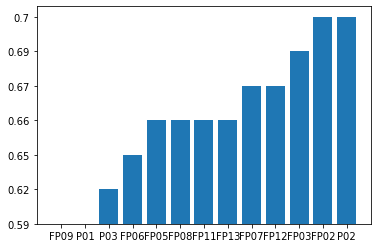

In [79]:
plt.bar(subj_res_df.Subject, subj_res_df.Accuracy)
# plt.ylim(0, 1)
plt.plot()